# Retraining EasyOCR on custom data

---------------------------------------------------- Loading Libraries --------------------------------------------

In [1]:
import os
import torch.backends.cudnn as cudnn
import yaml
import pandas as pd
import numpy as np
import torch.optim as optim
import time
from torch.cuda.amp import autocast, GradScaler
from torch._utils import _accumulate
import torch
import re
from torch.utils.data import Dataset, ConcatDataset, Subset
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import math
import string
import argparse
import torch.utils.data
import torch.nn.functional as F
from nltk.metrics.distance import edit_distance
import sys
import random
import torch.nn.init as init
import pickle
import six
import glob



cudnn.benchmark = True
cudnn.deterministic = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


!rm -r all_data/en_train_filtered/.ipynb_checkpoints
!rm -r all_data/en_val/.ipynb_checkpoints

rm: cannot remove 'all_data/en_train_filtered/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'all_data/en_val/.ipynb_checkpoints': No such file or directory


------------------------------------------ Training Code --------------------------------------------------

In [2]:
class CTCLabelConverter(object):
    """ Convert between text-label and text-index """

    #def __init__(self, character, separator = []):
    def __init__(self, character, separator_list = {}, dict_pathlist = {}):
        # character (str): set of the possible characters.
        dict_character = list(character)

        #special_character = ['\xa2', '\xa3', '\xa4','\xa5']
        #self.separator_char = special_character[:len(separator)]

        self.dict = {}
        #for i, char in enumerate(self.separator_char + dict_character):
        for i, char in enumerate(dict_character):
            # NOTE: 0 is reserved for 'blank' token required by CTCLoss
            self.dict[char] = i + 1

        self.character = ['[blank]'] + dict_character  # dummy '[blank]' token for CTCLoss (index 0)
        #self.character = ['[blank]']+ self.separator_char + dict_character  # dummy '[blank]' token for CTCLoss (index 0)
        self.separator_list = separator_list

        separator_char = []
        for lang, sep in separator_list.items():
            separator_char += sep

        self.ignore_idx = [0] + [i+1 for i,item in enumerate(separator_char)]

        dict_list = {}
        for lang, dict_path in dict_pathlist.items():
            with open(dict_path, "rb") as input_file:
                word_count = pickle.load(input_file)
            dict_list[lang] = word_count
        self.dict_list = dict_list #checkpoint

    def encode(self, text, batch_max_length=25):
        """convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]
        output:
            text: concatenated text index for CTCLoss.
                    [sum(text_lengths)] = [text_index_0 + text_index_1 + ... + text_index_(n - 1)]
            length: length of each text. [batch_size]
        """
        length = [len(s) for s in text]
        text = ''.join(text)
        text = [self.dict[char] for char in text]

        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode_greedy(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        index = 0
        for l in length:
            t = text_index[index:index + l]

            char_list = []
            for i in range(l):
                if t[i] not in self.ignore_idx and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank (and separator).
                #if (t[i] != 0) and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank (and separator).
                    char_list.append(self.character[t[i]])
            text = ''.join(char_list)

            texts.append(text)
            index += l
        return texts

    def decode_beamsearch(self, mat, beamWidth=5):
        texts = []

        for i in range(mat.shape[0]):
            t = ctcBeamSearch(mat[i], self.character, self.ignore_idx, None, beamWidth=beamWidth)
            texts.append(t)
        return texts

    def decode_wordbeamsearch(self, mat, beamWidth=5):
        texts = []
        argmax = np.argmax(mat, axis = 2)
        for i in range(mat.shape[0]):
            words = word_segmentation(argmax[i])
            string = ''
            for word in words:
                matrix = mat[i, word[1][0]:word[1][1]+1,:]
                if word[0] == '': dict_list = []
                else: dict_list = self.dict_list[word[0]]
                t = ctcBeamSearch(matrix, self.character, self.ignore_idx, None, beamWidth=beamWidth, dict_list=dict_list)
                string += t
            texts.append(string)
        return texts

In [3]:
class AttnLabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        # character (str): set of the possible characters.
        # [GO] for the start token of the attention decoder. [s] for end-of-sentence token.
        list_token = ['[GO]', '[s]']  # ['[s]','[UNK]','[PAD]','[GO]']
        list_character = list(character)
        self.character = list_token + list_character

        self.dict = {}
        for i, char in enumerate(self.character):
            # print(i, char)
            self.dict[char] = i

    def encode(self, text, batch_max_length=25):
        """ convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]
            batch_max_length: max length of text label in the batch. 25 by default
        output:
            text : the input of attention decoder. [batch_size x (max_length+2)] +1 for [GO] token and +1 for [s] token.
                text[:, 0] is [GO] token and text is padded with [GO] token after [s] token.
            length : the length of output of attention decoder, which count [s] token also. [3, 7, ....] [batch_size]
        """
        length = [len(s) + 1 for s in text]  # +1 for [s] at end of sentence.
        # batch_max_length = max(length) # this is not allowed for multi-gpu setting
        batch_max_length += 1
        # additional +1 for [GO] at first step. batch_text is padded with [GO] token after [s] token.
        batch_text = torch.LongTensor(len(text), batch_max_length + 1).fill_(0)
        for i, t in enumerate(text):
            text = list(t)
            text.append('[s]')
            text = [self.dict[char] for char in text]
            batch_text[i][1:1 + len(text)] = torch.LongTensor(text)  # batch_text[:, 0] = [GO] token
        return (batch_text.to(device), torch.IntTensor(length).to(device))

    def decode(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        for index, l in enumerate(length):
            text = ''.join([self.character[i] for i in text_index[index, :]])
            texts.append(text)
        return texts




In [4]:
class Averager(object):
    """Compute average for torch.Tensor, used for loss average."""

    def __init__(self):
        self.reset()

    def add(self, v):
        count = v.data.numel()
        v = v.data.sum()
        self.n_count += count
        self.sum += v

    def reset(self):
        self.n_count = 0
        self.sum = 0

    def val(self):
        res = 0
        if self.n_count != 0:
            res = self.sum / float(self.n_count)
        return 

In [5]:
def hierarchical_dataset(root, opt, select_data='/'):
    """ select_data='/' contains all sub-directory of root directory """
    dataset_list = []
    dataset_log = f'dataset_root:    {root}\t dataset: {select_data[0]}'
    print(dataset_log)
    dataset_log += '\n'
    for dirpath, dirnames, filenames in os.walk(root+'/'):
        if not dirnames:
            select_flag = False
            for selected_d in select_data:
                if selected_d in dirpath:
                    select_flag = True
                    break

            if select_flag:
                dataset = OCRDataset(dirpath, opt)
                sub_dataset_log = f'sub-directory:\t/{os.path.relpath(dirpath, root)}\t num samples: {len(dataset)}'
                print(sub_dataset_log)
                dataset_log += f'{sub_dataset_log}\n'
                dataset_list.append(dataset)

    concatenated_dataset = ConcatDataset(dataset_list)

    return concatenated_dataset, dataset_log

In [6]:
class AlignCollate(object):

    def __init__(self, imgH=32, imgW=100, keep_ratio_with_pad=False, contrast_adjust = 0.):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio_with_pad = keep_ratio_with_pad
        self.contrast_adjust = contrast_adjust

    def __call__(self, batch):
        batch = filter(lambda x: x is not None, batch)
        images, labels = zip(*batch)

        if self.keep_ratio_with_pad:  # same concept with 'Rosetta' paper
            resized_max_w = self.imgW
            input_channel = 3 if images[0].mode == 'RGB' else 1
            transform = NormalizePAD((input_channel, self.imgH, resized_max_w))

            resized_images = []
            for image in images:
                w, h = image.size

                #### augmentation here - change contrast
                if self.contrast_adjust > 0:
                    image = np.array(image.convert("L"))
                    image = adjust_contrast_grey(image, target = self.contrast_adjust)
                    image = Image.fromarray(image, 'L')

                ratio = w / float(h)
                if math.ceil(self.imgH * ratio) > self.imgW:
                    resized_w = self.imgW
                else:
                    resized_w = math.ceil(self.imgH * ratio)

                resized_image = image.resize((resized_w, self.imgH), Image.Resampling.BICUBIC)
                resized_images.append(transform(resized_image))
                # resized_image.save('./image_test/%d_test.jpg' % w)

            image_tensors = torch.cat([t.unsqueeze(0) for t in resized_images], 0)

        else:
            transform = ResizeNormalize((self.imgW, self.imgH))
            image_tensors = [transform(image) for image in images]
            image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)

        return image_tensors, labels

In [7]:
class Batch_Balanced_Dataset(object):

    def __init__(self, opt):
        """
        Modulate the data ratio in the batch.
        For example, when select_data is "MJ-ST" and batch_ratio is "0.5-0.5",
        the 50% of the batch is filled with MJ and the other 50% of the batch is filled with ST.
        """
        log = open(f'./saved_models/{opt.experiment_name}/log_dataset.txt', 'a')
        dashed_line = '-' * 80
        print(dashed_line)
        log.write(dashed_line + '\n')
        print(f'dataset_root: {opt.train_data}\nopt.select_data: {opt.select_data}\nopt.batch_ratio: {opt.batch_ratio}')
        log.write(f'dataset_root: {opt.train_data}\nopt.select_data: {opt.select_data}\nopt.batch_ratio: {opt.batch_ratio}\n')
        assert len(opt.select_data) == len(opt.batch_ratio)

        _AlignCollate = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD, contrast_adjust = opt.contrast_adjust)
        self.data_loader_list = []
        self.dataloader_iter_list = []
        batch_size_list = []
        Total_batch_size = 0
        for selected_d, batch_ratio_d in zip(opt.select_data, opt.batch_ratio):
            _batch_size = max(round(opt.batch_size * float(batch_ratio_d)), 1)
            print(dashed_line)
            log.write(dashed_line + '\n')
            _dataset, _dataset_log = hierarchical_dataset(root=opt.train_data, opt=opt, select_data=[selected_d])
            total_number_dataset = len(_dataset)
            log.write(_dataset_log)

            """
            The total number of data can be modified with opt.total_data_usage_ratio.
            ex) opt.total_data_usage_ratio = 1 indicates 100% usage, and 0.2 indicates 20% usage.
            See 4.2 section in our paper.
            """
            number_dataset = int(total_number_dataset * float(opt.total_data_usage_ratio))
            dataset_split = [number_dataset, total_number_dataset - number_dataset]
            indices = range(total_number_dataset)
            _dataset, _ = [Subset(_dataset, indices[offset - length:offset])
                           for offset, length in zip(_accumulate(dataset_split), dataset_split)]
            selected_d_log = f'num total samples of {selected_d}: {total_number_dataset} x {opt.total_data_usage_ratio} (total_data_usage_ratio) = {len(_dataset)}\n'
            selected_d_log += f'num samples of {selected_d} per batch: {opt.batch_size} x {float(batch_ratio_d)} (batch_ratio) = {_batch_size}'
            print(selected_d_log)
            log.write(selected_d_log + '\n')
            batch_size_list.append(str(_batch_size))
            Total_batch_size += _batch_size

            _data_loader = torch.utils.data.DataLoader(
                _dataset, batch_size=_batch_size,
                shuffle=True,
                num_workers=int(opt.workers), #prefetch_factor=2,persistent_workers=True,
                collate_fn=_AlignCollate, pin_memory=True)
            self.data_loader_list.append(_data_loader)
            self.dataloader_iter_list.append(iter(_data_loader))

        Total_batch_size_log = f'{dashed_line}\n'
        batch_size_sum = '+'.join(batch_size_list)
        Total_batch_size_log += f'Total_batch_size: {batch_size_sum} = {Total_batch_size}\n'
        Total_batch_size_log += f'{dashed_line}'
        opt.batch_size = Total_batch_size

        print(Total_batch_size_log)
        log.write(Total_batch_size_log + '\n')
        log.close()

    def get_batch(self):
        balanced_batch_images = []
        balanced_batch_texts = []

        for i, data_loader_iter in enumerate(self.dataloader_iter_list):
            try:

                data_loader_iter = iter(data_loader_iter)

                image, text = next(data_loader_iter)#.next()
                balanced_batch_images.append(image)
                balanced_batch_texts += text
            except StopIteration:
                self.dataloader_iter_list[i] = iter(self.data_loader_list[i])
                image, text = next(self.dataloader_iter_list[i])#.next()
                balanced_batch_images.append(image)
                balanced_batch_texts += text
            except ValueError:
                pass

        balanced_batch_images = torch.cat(balanced_batch_images, 0)

        return balanced_batch_images, balanced_batch_texts

In [8]:
class Model(nn.Module):

    def __init__(self, opt):
        super(Model, self).__init__()
        self.opt = opt
        self.stages = {'Trans': opt.Transformation, 'Feat': opt.FeatureExtraction,
                       'Seq': opt.SequenceModeling, 'Pred': opt.Prediction}

        """ Transformation """
        if opt.Transformation == 'TPS':
            self.Transformation = TPS_SpatialTransformerNetwork(
                F=opt.num_fiducial, I_size=(opt.imgH, opt.imgW), I_r_size=(opt.imgH, opt.imgW), I_channel_num=opt.input_channel)
        else:
            print('No Transformation module specified')

        """ FeatureExtraction """
        if opt.FeatureExtraction == 'VGG':
            self.FeatureExtraction = VGG_FeatureExtractor(opt.input_channel, opt.output_channel)
        elif opt.FeatureExtraction == 'RCNN':
            self.FeatureExtraction = RCNN_FeatureExtractor(opt.input_channel, opt.output_channel)
        elif opt.FeatureExtraction == 'ResNet':
            self.FeatureExtraction = ResNet_FeatureExtractor(opt.input_channel, opt.output_channel)
        else:
            raise Exception('No FeatureExtraction module specified')
        self.FeatureExtraction_output = opt.output_channel  # int(imgH/16-1) * 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))  # Transform final (imgH/16-1) -> 1

        """ Sequence modeling"""
        if opt.SequenceModeling == 'BiLSTM':
            self.SequenceModeling = nn.Sequential(
                BidirectionalLSTM(self.FeatureExtraction_output, opt.hidden_size, opt.hidden_size),
                BidirectionalLSTM(opt.hidden_size, opt.hidden_size, opt.hidden_size))
            self.SequenceModeling_output = opt.hidden_size
        else:
            print('No SequenceModeling module specified')
            self.SequenceModeling_output = self.FeatureExtraction_output

        """ Prediction """
        if opt.Prediction == 'CTC':
            self.Prediction = nn.Linear(self.SequenceModeling_output, opt.num_class)
        elif opt.Prediction == 'Attn':
            self.Prediction = Attention(self.SequenceModeling_output, opt.hidden_size, opt.num_class)
        else:
            raise Exception('Prediction is neither CTC or Attn')

    def forward(self, input, text, is_train=True):
        """ Transformation stage """
        if not self.stages['Trans'] == "None":
            input = self.Transformation(input)

        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        if self.stages['Seq'] == 'BiLSTM':
            contextual_feature = self.SequenceModeling(visual_feature)
        else:
            contextual_feature = visual_feature  # for convenience. this is NOT contextually modeled by BiLSTM

        """ Prediction stage """
        if self.stages['Pred'] == 'CTC':
            prediction = self.Prediction(contextual_feature.contiguous())
        else:
            prediction = self.Prediction(contextual_feature.contiguous(), text, is_train, batch_max_length=self.opt.batch_max_length)

        return prediction

In [9]:
def validation(model, criterion, evaluation_loader, converter, opt, device):
    """ validation or evaluation """
    n_correct = 0
    norm_ED = 0
    length_of_data = 0
    infer_time = 0
    valid_loss_avg = Averager()

    for i, (image_tensors, labels) in enumerate(evaluation_loader):
        batch_size = image_tensors.size(0)
        length_of_data = length_of_data + batch_size
        image = image_tensors.to(device)
        # For max length prediction
        length_for_pred = torch.IntTensor([opt.batch_max_length] * batch_size).to(device)
        text_for_pred = torch.LongTensor(batch_size, opt.batch_max_length + 1).fill_(0).to(device)

        text_for_loss, length_for_loss = converter.encode(labels, batch_max_length=opt.batch_max_length)
        
        start_time = time.time()
        if 'CTC' in opt.Prediction:
            preds = model(image, text_for_pred)
            forward_time = time.time() - start_time

            # Calculate evaluation loss for CTC decoder.
            preds_size = torch.IntTensor([preds.size(1)] * batch_size)
            # permute 'preds' to use CTCloss format
            cost = criterion(preds.log_softmax(2).permute(1, 0, 2), text_for_loss, preds_size, length_for_loss)
            if opt.decode == 'greedy':
                # Select max probabilty (greedy decoding) then decode index to character
                _, preds_index = preds.max(2)
                preds_index = preds_index.view(-1)
                preds_str = converter.decode_greedy(preds_index.data, preds_size.data)
            elif opt.decode == 'beamsearch':
                preds_str = converter.decode_beamsearch(preds, beamWidth=2)

        else:
            preds = model(image, text_for_pred, is_train=False)
            forward_time = time.time() - start_time

            preds = preds[:, :text_for_loss.shape[1] - 1, :]
            target = text_for_loss[:, 1:]  # without [GO] Symbol
            cost = criterion(preds.contiguous().view(-1, preds.shape[-1]), target.contiguous().view(-1))

            # select max probabilty (greedy decoding) then decode index to character
            _, preds_index = preds.max(2)
            preds_str = converter.decode(preds_index, length_for_pred)
            labels = converter.decode(text_for_loss[:, 1:], length_for_loss)

        infer_time += forward_time
        valid_loss_avg.add(cost)

        # calculate accuracy & confidence score
        preds_prob = F.softmax(preds, dim=2)
        preds_max_prob, _ = preds_prob.max(dim=2)
        confidence_score_list = []
        
        for gt, pred, pred_max_prob in zip(labels, preds_str, preds_max_prob):
            if 'Attn' in opt.Prediction:
                gt = gt[:gt.find('[s]')]
                pred_EOS = pred.find('[s]')
                pred = pred[:pred_EOS]  # prune after "end of sentence" token ([s])
                pred_max_prob = pred_max_prob[:pred_EOS]

            if pred == gt:
                n_correct += 1

            '''
            (old version) ICDAR2017 DOST Normalized Edit Distance https://rrc.cvc.uab.es/?ch=7&com=tasks
            "For each word we calculate the normalized edit distance to the length of the ground truth transcription." 
            if len(gt) == 0:
                norm_ED += 1
            else:
                norm_ED += edit_distance(pred, gt) / len(gt)
            '''
            
            # ICDAR2019 Normalized Edit Distance 
            if len(gt) == 0 or len(pred) ==0:
                norm_ED += 0
            elif len(gt) > len(pred):
                norm_ED += 1 - edit_distance(pred, gt) / len(gt)
            else:
                norm_ED += 1 - edit_distance(pred, gt) / len(pred)

            # calculate confidence score (= multiply of pred_max_prob)
            try:
                confidence_score = pred_max_prob.cumprod(dim=0)[-1]
            except:
                confidence_score = 0  # for empty pred case, when prune after "end of sentence" token ([s])
            confidence_score_list.append(confidence_score)
            # print(pred, gt, pred==gt, confidence_score)

    accuracy = n_correct / float(length_of_data) * 100
    norm_ED = norm_ED / float(length_of_data) # ICDAR2019 Normalized Edit Distance

    return valid_loss_avg.val(), accuracy, norm_ED, preds_str, confidence_score_list, labels, infer_time, 

In [10]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [11]:
def get_config(file_path):
    with open(file_path, 'r', encoding="utf8") as stream:
        opt = yaml.safe_load(stream)
    opt = AttrDict(opt)
    if opt.lang_char == 'None':
        characters = ''
        for data in opt['select_data'].split('-'):
            #print('check data content: ', data)
            csv_path = os.path.join(opt['train_data'], data, 'labels.csv')
            #csv_path = 'all_data/en_train_filtered/labels.csv'
            #print('csv_path: ', csv_path)
            df = pd.read_csv(csv_path, sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
            #df = pd.read_csv('all_data/en_train_filtered/labels.csv', sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
            all_char = ''.join(df['words'])
            characters += ''.join(set(all_char))
        characters = sorted(set(characters))
        opt.character= ''.join(characters)
    else:
        opt.character = opt.number + opt.symbol + opt.lang_char
    os.makedirs(f'./saved_models/{opt.experiment_name}', exist_ok=True)
    return opt

In [12]:
class NormalizePAD(object):

    def __init__(self, max_size, PAD_type='right'):
        self.toTensor = transforms.ToTensor()
        self.max_size = max_size
        self.max_width_half = math.floor(max_size[2] / 2)
        self.PAD_type = PAD_type

    def __call__(self, img):
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        c, h, w = img.size()
        Pad_img = torch.FloatTensor(*self.max_size).fill_(0)
        Pad_img[:, :, :w] = img  # right pad
        if self.max_size[2] != w:  # add border Pad
            Pad_img[:, :, w:] = img[:, :, w - 1].unsqueeze(2).expand(c, h, self.max_size[2] - w)

        return Pad_img

In [13]:
class OCRDataset(Dataset):

    def __init__(self, root, opt):

        self.root = root
        self.opt = opt
        #root = glob.glob("all_data/en_train_filtered/[!.]**.csv")
        #root = root[0]
        #print('root: ',root)
        self.df = pd.read_csv(os.path.join(root,'labels.csv'), sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
        #self.df = pd.read_csv(root, sep='^([^,]+),', engine='python', usecols=['filename', 'words'], keep_default_na=False)
        #self.df = self.df.loc[:, ~df.columns.str.contains('^Unnamed')]
        self.nSamples = len(self.df)

        if self.opt.data_filtering_off:
            self.filtered_index_list = [index + 1 for index in range(self.nSamples)]
        else:
            self.filtered_index_list = []
            for index in range(self.nSamples):
                label = self.df.at[index,'words']
                try:
                    if len(label) > self.opt.batch_max_length:
                        continue
                except:
                    print(label)
                out_of_char = f'[^{self.opt.character}]'
                #label = str(label).lower()
                #if re.search(out_of_char, label.lower()):
                if re.search(out_of_char, str(label).lower()):
                    continue
                self.filtered_index_list.append(index)
            self.nSamples = len(self.filtered_index_list)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        index = self.filtered_index_list[index]
        img_fname = self.df.at[index,'filename']
        img_fpath = os.path.join(self.root, img_fname)
        label = self.df.at[index,'words']

        if self.opt.rgb:
            img = Image.open(img_fpath).convert('RGB')  # for color image
        else:
            img = Image.open(img_fpath).convert('L')

        if not self.opt.sensitive:
            label = label.lower()

        # We only train and evaluate on alphanumerics (or pre-defined character set in train.py)
        out_of_char = f'[^{self.opt.character}]'
        label = str(label).lower()
        label = re.sub(out_of_char, '', label)
        

        return (img, label)

In [14]:
class VGG_FeatureExtractor(nn.Module):
    """ FeatureExtractor of CRNN (https://arxiv.org/pdf/1507.05717.pdf) """

    def __init__(self, input_channel, output_channel=512):
        super(VGG_FeatureExtractor, self).__init__()
        self.output_channel = [int(output_channel / 8), int(output_channel / 4),
                               int(output_channel / 2), output_channel]  # [64, 128, 256, 512]
        self.ConvNet = nn.Sequential(
            nn.Conv2d(input_channel, self.output_channel[0], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 64x16x50
            nn.Conv2d(self.output_channel[0], self.output_channel[1], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 128x8x25
            nn.Conv2d(self.output_channel[1], self.output_channel[2], 3, 1, 1), nn.ReLU(True),  # 256x8x25
            nn.Conv2d(self.output_channel[2], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 256x4x25
            nn.Conv2d(self.output_channel[2], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),  # 512x4x25
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),  # 512x2x25
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 2, 1, 0), nn.ReLU(True))  # 512x1x24

    def forward(self, input):
        return self.ConvNet(input)


In [15]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        try:
            self.rnn.flatten_parameters()
        except:
            pass
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output

In [16]:
def count_parameters(model):
    print("Modules, Parameters")
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        #table.add_row([name, param])
        total_params+=param
        print(name, param)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [17]:
def train(opt, show_number = 2, amp=False):
    """ dataset preparation """
    if not opt.data_filtering_off:
        print('Filtering the images containing characters which are not in opt.character')
        print('Filtering the images whose label is longer than opt.batch_max_length')

    opt.select_data = opt.select_data.split('-')
    opt.batch_ratio = opt.batch_ratio.split('-')
    train_dataset = Batch_Balanced_Dataset(opt)

    log = open(f'./saved_models/{opt.experiment_name}/log_dataset.txt', 'a', encoding="utf8")
    AlignCollate_valid = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD, contrast_adjust=opt.contrast_adjust)
    valid_dataset, valid_dataset_log = hierarchical_dataset(root=opt.valid_data, opt=opt)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=min(32, opt.batch_size),
        shuffle=True,  # 'True' to check training progress with validation function.
        num_workers=int(opt.workers), prefetch_factor=512,
        collate_fn=AlignCollate_valid, pin_memory=True)
    log.write(valid_dataset_log)
    print('-' * 80)
    log.write('-' * 80 + '\n')
    log.close()
    
    """ model configuration """
    if 'CTC' in opt.Prediction:
        converter = CTCLabelConverter(opt.character)
    else:
        converter = AttnLabelConverter(opt.character)
    opt.num_class = len(converter.character)

    if opt.rgb:
        opt.input_channel = 3
    model = Model(opt)
    print('model input parameters', opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel,
          opt.hidden_size, opt.num_class, opt.batch_max_length, opt.Transformation, opt.FeatureExtraction,
          opt.SequenceModeling, opt.Prediction)

    if opt.saved_model != '':
        #check from here
        #print("checking if this condition runs!!")
        pretrained_dict = torch.load(opt.saved_model)
        if opt.new_prediction:
            model.Prediction = nn.Linear(model.SequenceModeling_output, len(pretrained_dict['module.Prediction.weight']))  
        
        model = torch.nn.DataParallel(model).to(device) 
        print(f'loading pretrained model from {opt.saved_model}')
        if opt.FT:
            model.load_state_dict(pretrained_dict, strict=False)
        else:
            model.load_state_dict(pretrained_dict)
        if opt.new_prediction:
            model.module.Prediction = nn.Linear(model.module.SequenceModeling_output, opt.num_class)  
            for name, param in model.module.Prediction.named_parameters():
                if 'bias' in name:
                    init.constant_(param, 0.0)
                elif 'weight' in name:
                    init.kaiming_normal_(param)
            model = model.to(device) 
    else:
        # weight initialization
        for name, param in model.named_parameters():
            if 'localization_fc2' in name:
                print(f'Skip {name} as it is already initialized')
                continue
            try:
                if 'bias' in name:
                    init.constant_(param, 0.0)
                elif 'weight' in name:
                    init.kaiming_normal_(param)
            except Exception as e:  # for batchnorm.
                if 'weight' in name:
                    param.data.fill_(1)
                continue
        model = torch.nn.DataParallel(model).to(device)
    
    model.train() 
    print("Model:")
    print(model)
    count_parameters(model)
    
    """ setup loss """
    if 'CTC' in opt.Prediction:
        criterion = torch.nn.CTCLoss(zero_infinity=True).to(device)
    else:
        criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)  # ignore [GO] token = ignore index 0
    # loss averager
    loss_avg = Averager()

    # freeze some layers
    try:
        if opt.freeze_FeatureFxtraction:
            for param in model.module.FeatureExtraction.parameters():
                param.requires_grad = False
        if opt.freeze_SequenceModeling:
            for param in model.module.SequenceModeling.parameters():
                param.requires_grad = False
    except:
        pass
    
    # filter that only require gradient decent
    filtered_parameters = []
    params_num = []
    for p in filter(lambda p: p.requires_grad, model.parameters()):
        filtered_parameters.append(p)
        params_num.append(np.prod(p.size()))
    print('Trainable params num : ', sum(params_num))
    # [print(name, p.numel()) for name, p in filter(lambda p: p[1].requires_grad, model.named_parameters())]

    # setup optimizer
    if opt.optim=='adam':
        #optimizer = optim.Adam(filtered_parameters, lr=opt.lr, betas=(opt.beta1, 0.999))
        optimizer = optim.Adam(filtered_parameters)
    else:
        optimizer = optim.Adadelta(filtered_parameters, lr=opt.lr, rho=opt.rho, eps=opt.eps)
    print("Optimizer:")
    print(optimizer)

    """ final options """
    # print(opt)
    with open(f'./saved_models/{opt.experiment_name}/opt.txt', 'a', encoding="utf8") as opt_file:
        opt_log = '------------ Options -------------\n'
        args = vars(opt)
        for k, v in args.items():
            opt_log += f'{str(k)}: {str(v)}\n'
        opt_log += '---------------------------------------\n'
        print(opt_log)
        opt_file.write(opt_log)

    """ start training """
    start_iter = 0
    if opt.saved_model != '':
        try:
            start_iter = int(opt.saved_model.split('_')[-1].split('.')[0])
            print(f'continue to train, start_iter: {start_iter}')
        except:
            pass

    start_time = time.time()
    best_accuracy = -1
    best_norm_ED = -1
    i = start_iter

    scaler = GradScaler()
    t1= time.time()
        
    while(True):
        # train part
        optimizer.zero_grad(set_to_none=True)
        
        if amp:
            with autocast():
                image_tensors, labels = train_dataset.get_batch()
                image = image_tensors.to(device)
                text, length = converter.encode(labels, batch_max_length=opt.batch_max_length)
                batch_size = image.size(0)

                if 'CTC' in opt.Prediction:
                    preds = model(image, text).log_softmax(2)
                    preds_size = torch.IntTensor([preds.size(1)] * batch_size)
                    preds = preds.permute(1, 0, 2)
                    torch.backends.cudnn.enabled = False
                    cost = criterion(preds, text.to(device), preds_size.to(device), length.to(device))
                    torch.backends.cudnn.enabled = True
                else:
                    preds = model(image, text[:, :-1])  # align with Attention.forward
                    target = text[:, 1:]  # without [GO] Symbol
                    cost = criterion(preds.view(-1, preds.shape[-1]), target.contiguous().view(-1))
            scaler.scale(cost).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            image_tensors, labels = train_dataset.get_batch()
            image = image_tensors.to(device)
            text, length = converter.encode(labels, batch_max_length=opt.batch_max_length)
            batch_size = image.size(0)
            if 'CTC' in opt.Prediction:
                preds = model(image, text).log_softmax(2)
                preds_size = torch.IntTensor([preds.size(1)] * batch_size)
                preds = preds.permute(1, 0, 2)
                torch.backends.cudnn.enabled = False
                cost = criterion(preds, text.to(device), preds_size.to(device), length.to(device))
                torch.backends.cudnn.enabled = True
            else:
                preds = model(image, text[:, :-1])  # align with Attention.forward
                target = text[:, 1:]  # without [GO] Symbol
                cost = criterion(preds.view(-1, preds.shape[-1]), target.contiguous().view(-1))
            cost.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_clip) 
            optimizer.step()
        loss_avg.add(cost)

        # validation part
        if (i % opt.valInterval == 0) and (i!=0):
            print('training time: ', time.time()-t1)
            t1=time.time()
            elapsed_time = time.time() - start_time
            # for log
            with open(f'./saved_models/{opt.experiment_name}/log_train.txt', 'a', encoding="utf8") as log:
                model.eval()
                with torch.no_grad():
                    #valid_loss, current_accuracy, current_norm_ED, preds, confidence_score, labels, \
                    valid_loss, current_accuracy, current_norm_ED, preds, confidence_score, labels, infer_time = validation(model, criterion, valid_loader, converter, opt, device)
                    #infer_time, length_of_data = validation(model, criterion, valid_loader, converter, opt, device)
                model.train()

                # training loss and validation loss
                
                #print("check type -> loss_avg: {}".format(loss_avg.val()))
                #print("check type -> valid_loss: {}".format(valid_loss))
                #print("check type -> elapsed_time: {}".format(elapsed_time))
                
                loss_average = loss_avg.val()
                default_value = 0

                if loss_average is None:
                    loss_average = default_value
                
                if valid_loss is None:
                    valid_loss = default_value
                    
                if elapsed_time is None:
                    elapsed_time = default_value
                
                
                loss_log = f'[{i}/{opt.num_iter}] Train loss: {loss_average:0.5f}, Valid loss: {valid_loss:0.5f}, Elapsed_time: {elapsed_time:0.5f}'
                loss_avg.reset()

                current_model_log = f'{"Current_accuracy":17s}: {current_accuracy:0.3f}, {"Current_norm_ED":17s}: {current_norm_ED:0.4f}'

                # keep best accuracy model (on valid dataset)
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy
                    torch.save(model.state_dict(), f'./saved_models/{opt.experiment_name}/best_accuracy.pth')
                if current_norm_ED > best_norm_ED:
                    best_norm_ED = current_norm_ED
                    torch.save(model.state_dict(), f'./saved_models/{opt.experiment_name}/best_norm_ED.pth')
                best_model_log = f'{"Best_accuracy":17s}: {best_accuracy:0.3f}, {"Best_norm_ED":17s}: {best_norm_ED:0.4f}'

                loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
                print(loss_model_log)
                log.write(loss_model_log + '\n')

                # show some predicted results
                dashed_line = '-' * 80
                head = f'{"Ground Truth":25s} | {"Prediction":25s} | Confidence Score & T/F'
                predicted_result_log = f'{dashed_line}\n{head}\n{dashed_line}\n'
                
                #show_number = min(show_number, len(labels))
                
                
                #print("check -> labels: {}".format(labels))
                #print("check -> show_number: {}".format(show_number))
                
                start = random.randint(0,len(labels) - show_number )    
                
                for gt, pred, confidence in zip(labels[start:start+show_number], preds[start:start+show_number], confidence_score[start:start+show_number]):
                #list_zip = zip(labels[start:start+show_number], preds[start:start+show_number], confidence_score[start:start+show_number])
                 
                #for gt, pred, confidence in list_zip: 
                    
                    if 'Attn' in opt.Prediction:
                        gt = gt[:gt.find('[s]')]
                        pred = pred[:pred.find('[s]')]

                    predicted_result_log += f'{gt:25s} | {pred:25s} | {confidence:0.4f}\t{str(pred == gt)}\n'
                predicted_result_log += f'{dashed_line}'
                print(predicted_result_log)
                log.write(predicted_result_log + '\n')
                print('validation time: ', time.time()-t1)
                t1=time.time()
        # save model per 1e+4 iter.
        if (i + 1) % 1e+4 == 0:
            torch.save(
                model.state_dict(), f'./saved_models/{opt.experiment_name}/iter_{i+1}.pth')

        if i == opt.num_iter:
            print('end the training')
            sys.exit()
        i += 1




opt = get_config("config_files/en_filtered_config.yaml")
train(opt, amp=False)

Filtering the images containing characters which are not in opt.character
Filtering the images whose label is longer than opt.batch_max_length
--------------------------------------------------------------------------------
dataset_root: all_data
opt.select_data: ['en_train_filtered']
opt.batch_ratio: ['10']
--------------------------------------------------------------------------------
dataset_root:    all_data	 dataset: en_train_filtered
sub-directory:	/en_train_filtered	 num samples: 1000
num total samples of en_train_filtered: 1000 x 1.0 (total_data_usage_ratio) = 1000
num samples of en_train_filtered per batch: 32 x 10.0 (batch_ratio) = 320
--------------------------------------------------------------------------------
Total_batch_size: 320 = 320
--------------------------------------------------------------------------------
dataset_root:    all_data/en_val	 dataset: /
sub-directory:	/.	 num samples: 500
--------------------------------------------------------------------------

SystemExit: 

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


-------------------------------------------------------------------- Testing -------------------------------------------------------------

In [1]:
#from .recognition import get_recognizer, get_text

#from my_model.recognition import get_recognizer, get_text
'''
from .utils import group_text_box, get_image_list, calculate_md5, get_paragraph,\
                   download_and_unzip, printProgressBar, diff, reformat_input,\
                   make_rotated_img_list, set_result_with_confidence,\
                   reformat_input_batched

'''
'''
from my_model.utils import group_text_box, get_image_list, calculate_md5, get_paragraph,\
                   download_and_unzip, printProgressBar, diff, reformat_input,\
                   make_rotated_img_list, set_result_with_confidence,\
                   reformat_input_batched
'''
#from .config import *

#from my_model.config import config
!pip install python-bidi
from bidi.algorithm import get_display
import numpy as np
import cv2
import torch
import os
import sys
from PIL import Image
from logging import getLogger
import yaml
import json
import logging
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

if sys.version_info[0] == 2:
    from io import open
    from six.moves.urllib.request import urlretrieve
    from pathlib2 import Path
else:
    from urllib.request import urlretrieve
    from pathlib import Path

In [2]:
"""  
Copyright (c) 2019-present NAVER Corp.
MIT License
"""

# -*- coding: utf-8 -*-
import numpy as np
from skimage import io
import cv2

def loadImage(img_file):
    img = io.imread(img_file)           # RGB order
    if img.shape[0] == 2: img = img[0]
    if len(img.shape) == 2 : img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:   img = img[:,:,:3]
    img = np.array(img)

    return img

def normalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy().astype(np.float32)

    img -= np.array([mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0], dtype=np.float32)
    img /= np.array([variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0], dtype=np.float32)
    return img

def denormalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy()
    img *= variance
    img += mean
    img *= 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def resize_aspect_ratio(img, square_size, interpolation, mag_ratio=1):
    height, width, channel = img.shape

    # magnify image size
    target_size = mag_ratio * max(height, width)

    # set original image size
    if target_size > square_size:
        target_size = square_size
    
    ratio = target_size / max(height, width)    

    target_h, target_w = int(height * ratio), int(width * ratio)
    proc = cv2.resize(img, (target_w, target_h), interpolation = interpolation)


    # make canvas and paste image
    target_h32, target_w32 = target_h, target_w
    if target_h % 32 != 0:
        target_h32 = target_h + (32 - target_h % 32)
    if target_w % 32 != 0:
        target_w32 = target_w + (32 - target_w % 32)
    resized = np.zeros((target_h32, target_w32, channel), dtype=np.float32)
    resized[0:target_h, 0:target_w, :] = proc
    target_h, target_w = target_h32, target_w32

    size_heatmap = (int(target_w/2), int(target_h/2))

    return resized, ratio, size_heatmap

def cvt2HeatmapImg(img):
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img

INFO:matplotlib.font_manager:generated new fontManager


In [3]:
from __future__ import print_function

import torch
import pickle
import numpy as np
import math
import cv2
from PIL import Image, JpegImagePlugin
from scipy import ndimage
import hashlib
import sys, os
from zipfile import ZipFile
#from .imgproc import loadImage

if sys.version_info[0] == 2:
    from six.moves.urllib.request import urlretrieve
else:
    from urllib.request import urlretrieve

def consecutive(data, mode ='first', stepsize=1):
    group = np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    group = [item for item in group if len(item)>0]

    if mode == 'first': result = [l[0] for l in group]
    elif mode == 'last': result = [l[-1] for l in group]
    return result

def word_segmentation(mat, separator_idx =  {'th': [1,2],'en': [3,4]}, separator_idx_list = [1,2,3,4]):
    result = []
    sep_list = []
    start_idx = 0
    sep_lang = ''
    for sep_idx in separator_idx_list:
        if sep_idx % 2 == 0: mode ='first'
        else: mode ='last'
        a = consecutive( np.argwhere(mat == sep_idx).flatten(), mode)
        new_sep = [ [item, sep_idx] for item in a]
        sep_list += new_sep
    sep_list = sorted(sep_list, key=lambda x: x[0])

    for sep in sep_list:
        for lang in separator_idx.keys():
            if sep[1] == separator_idx[lang][0]: # start lang
                sep_lang = lang
                sep_start_idx = sep[0]
            elif sep[1] == separator_idx[lang][1]: # end lang
                if sep_lang == lang: # check if last entry if the same start lang
                    new_sep_pair = [lang, [sep_start_idx+1, sep[0]-1]]
                    if sep_start_idx > start_idx:
                        result.append( ['', [start_idx, sep_start_idx-1] ] )
                    start_idx = sep[0]+1
                    result.append(new_sep_pair)
                sep_lang = ''# reset

    if start_idx <= len(mat)-1:
        result.append( ['', [start_idx, len(mat)-1] ] )
    return result

# code is based from https://github.com/githubharald/CTCDecoder/blob/master/src/BeamSearch.py
class BeamEntry:
    "information about one single beam at specific time-step"
    def __init__(self):
        self.prTotal = 0 # blank and non-blank
        self.prNonBlank = 0 # non-blank
        self.prBlank = 0 # blank
        self.prText = 1 # LM score
        self.lmApplied = False # flag if LM was already applied to this beam
        self.labeling = () # beam-labeling
        self.simplified = True  # To run simplyfiy label

class BeamState:
    "information about the beams at specific time-step"
    def __init__(self):
        self.entries = {}

    def norm(self):
        "length-normalise LM score"
        for (k, _) in self.entries.items():
            labelingLen = len(self.entries[k].labeling)
            self.entries[k].prText = self.entries[k].prText ** (1.0 / (labelingLen if labelingLen else 1.0))

    def sort(self):
        "return beam-labelings, sorted by probability"
        beams = [v for (_, v) in self.entries.items()]
        sortedBeams = sorted(beams, reverse=True, key=lambda x: x.prTotal*x.prText)
        return [x.labeling for x in sortedBeams]

    def wordsearch(self, classes, ignore_idx, maxCandidate, dict_list):
        beams = [v for (_, v) in self.entries.items()]
        sortedBeams = sorted(beams, reverse=True, key=lambda x: x.prTotal*x.prText)
        if len(sortedBeams) >  maxCandidate: sortedBeams = sortedBeams[:maxCandidate]

        for j, candidate in enumerate(sortedBeams):
            idx_list = candidate.labeling
            text = ''
            for i,l in enumerate(idx_list):
                if l not in ignore_idx and (not (i > 0 and idx_list[i - 1] == idx_list[i])):
                    text += classes[l]

            if j == 0: best_text = text
            if text in dict_list:
                #print('found text: ', text)
                best_text = text
                break
            else:
                pass
                #print('not in dict: ', text)
        return best_text

def applyLM(parentBeam, childBeam, classes, lm):
    "calculate LM score of child beam by taking score from parent beam and bigram probability of last two chars"
    if lm and not childBeam.lmApplied:
        c1 = classes[parentBeam.labeling[-1] if parentBeam.labeling else classes.index(' ')] # first char
        c2 = classes[childBeam.labeling[-1]] # second char
        lmFactor = 0.01 # influence of language model
        bigramProb = lm.getCharBigram(c1, c2) ** lmFactor # probability of seeing first and second char next to each other
        childBeam.prText = parentBeam.prText * bigramProb # probability of char sequence
        childBeam.lmApplied = True # only apply LM once per beam entry

def simplify_label(labeling, blankIdx = 0):
    labeling = np.array(labeling)

    # collapse blank
    idx = np.where(~((np.roll(labeling,1) == labeling) & (labeling == blankIdx)))[0]
    labeling = labeling[idx]

    # get rid of blank between different characters
    idx = np.where( ~((np.roll(labeling,1) != np.roll(labeling,-1)) & (labeling == blankIdx)) )[0]

    if len(labeling) > 0:
        last_idx = len(labeling)-1
        if last_idx not in idx: idx = np.append(idx, [last_idx])
    labeling = labeling[idx]

    return tuple(labeling)

def fast_simplify_label(labeling, c, blankIdx=0):

    # Adding BlankIDX after Non-Blank IDX
    if labeling and c == blankIdx and labeling[-1] != blankIdx:
        newLabeling = labeling + (c,)

    # Case when a nonBlankChar is added after BlankChar |len(char) - 1
    elif labeling and c != blankIdx and labeling[-1] == blankIdx:

        # If Blank between same character do nothing | As done by Simplify label
        if labeling[-2] == c:
            newLabeling = labeling + (c,)

        # if blank between different character, remove it | As done by Simplify Label
        else:
            newLabeling = labeling[:-1] + (c,)

    # if consecutive blanks : Keep the original label
    elif labeling and c == blankIdx and labeling[-1] == blankIdx:
        newLabeling = labeling

    # if empty beam & first index is blank
    elif not labeling and c == blankIdx:
        newLabeling = labeling

    # if empty beam & first index is non-blank
    elif not labeling and c != blankIdx:
        newLabeling = labeling + (c,)

    elif labeling and c != blankIdx:
        newLabeling = labeling + (c,)

    # Cases that might still require simplyfying
    else:
        newLabeling = labeling + (c,)
        newLabeling = simplify_label(newLabeling, blankIdx)

    return newLabeling

def addBeam(beamState, labeling):
    "add beam if it does not yet exist"
    if labeling not in beamState.entries:
        beamState.entries[labeling] = BeamEntry()

def ctcBeamSearch(mat, classes, ignore_idx, lm, beamWidth=25, dict_list = []):
    blankIdx = 0
    maxT, maxC = mat.shape

    # initialise beam state
    last = BeamState()
    labeling = ()
    last.entries[labeling] = BeamEntry()
    last.entries[labeling].prBlank = 1
    last.entries[labeling].prTotal = 1

    # go over all time-steps
    for t in range(maxT):
        curr = BeamState()
        # get beam-labelings of best beams
        bestLabelings = last.sort()[0:beamWidth]
        # go over best beams
        for labeling in bestLabelings:
            # probability of paths ending with a non-blank
            prNonBlank = 0
            # in case of non-empty beam
            if labeling:
                # probability of paths with repeated last char at the end
                prNonBlank = last.entries[labeling].prNonBlank * mat[t, labeling[-1]]

            # probability of paths ending with a blank
            prBlank = (last.entries[labeling].prTotal) * mat[t, blankIdx]

            # add beam at current time-step if needed
            prev_labeling = labeling
            if not last.entries[labeling].simplified:
                labeling = simplify_label(labeling, blankIdx)

            # labeling = simplify_label(labeling, blankIdx)
            addBeam(curr, labeling)

            # fill in data
            curr.entries[labeling].labeling = labeling
            curr.entries[labeling].prNonBlank += prNonBlank
            curr.entries[labeling].prBlank += prBlank
            curr.entries[labeling].prTotal += prBlank + prNonBlank
            curr.entries[labeling].prText = last.entries[prev_labeling].prText
            # beam-labeling not changed, therefore also LM score unchanged from

            #curr.entries[labeling].lmApplied = True # LM already applied at previous time-step for this beam-labeling

            # extend current beam-labeling
            # char_highscore = np.argpartition(mat[t, :], -5)[-5:] # run through 5 highest probability
            char_highscore = np.where(mat[t, :] >= 0.5/maxC)[0] # run through all probable characters
            for c in char_highscore:
            #for c in range(maxC - 1):
                # add new char to current beam-labeling
                # newLabeling = labeling + (c,)
                # newLabeling = simplify_label(newLabeling, blankIdx)
                newLabeling = fast_simplify_label(labeling, c, blankIdx)

                # if new labeling contains duplicate char at the end, only consider paths ending with a blank
                if labeling and labeling[-1] == c:
                    prNonBlank = mat[t, c] * last.entries[prev_labeling].prBlank
                else:
                    prNonBlank = mat[t, c] * last.entries[prev_labeling].prTotal

                # add beam at current time-step if needed
                addBeam(curr, newLabeling)

                # fill in data
                curr.entries[newLabeling].labeling = newLabeling
                curr.entries[newLabeling].prNonBlank += prNonBlank
                curr.entries[newLabeling].prTotal += prNonBlank

                # apply LM
                #applyLM(curr.entries[labeling], curr.entries[newLabeling], classes, lm)

        # set new beam state

        last = curr

    # normalise LM scores according to beam-labeling-length
    last.norm()

    if dict_list == []:
        bestLabeling = last.sort()[0] # get most probable labeling
        res = ''
        for i,l in enumerate(bestLabeling):
            # removing repeated characters and blank.
            if l not in ignore_idx and (not (i > 0 and bestLabeling[i - 1] == bestLabeling[i])):
                res += classes[l]
    else:
        res = last.wordsearch(classes, ignore_idx, 20, dict_list)
    return res


class CTCLabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character, separator_list = {}, dict_pathlist = {}):
        # character (str): set of the possible characters.
        dict_character = list(character)

        self.dict = {}
        for i, char in enumerate(dict_character):
            self.dict[char] = i + 1

        self.character = ['[blank]'] + dict_character  # dummy '[blank]' token for CTCLoss (index 0)

        self.separator_list = separator_list
        separator_char = []
        for lang, sep in separator_list.items():
            separator_char += sep
        self.ignore_idx = [0] + [i+1 for i,item in enumerate(separator_char)]

        ####### latin dict
        if len(separator_list) == 0:
            dict_list = []
            for lang, dict_path in dict_pathlist.items():
                try:
                    with open(dict_path, "r", encoding = "utf-8-sig") as input_file:
                        word_count =  input_file.read().splitlines()
                    dict_list += word_count
                except:
                    pass
        else:
            dict_list = {}
            for lang, dict_path in dict_pathlist.items():
                with open(dict_path, "r", encoding = "utf-8-sig") as input_file:
                    word_count =  input_file.read().splitlines()
                dict_list[lang] = word_count

        self.dict_list = dict_list

    def encode(self, text, batch_max_length=25):
        """convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]

        output:
            text: concatenated text index for CTCLoss.
                    [sum(text_lengths)] = [text_index_0 + text_index_1 + ... + text_index_(n - 1)]
            length: length of each text. [batch_size]
        """
        length = [len(s) for s in text]
        text = ''.join(text)
        text = [self.dict[char] for char in text]

        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode_greedy(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        index = 0
        for l in length:
            t = text_index[index:index + l]
            # Returns a boolean array where true is when the value is not repeated
            a = np.insert(~((t[1:]==t[:-1])),0,True)
            # Returns a boolean array where true is when the value is not in the ignore_idx list
            b = ~np.isin(t,np.array(self.ignore_idx))
            # Combine the two boolean array
            c = a & b
            # Gets the corresponding character according to the saved indexes
            text = ''.join(np.array(self.character)[t[c.nonzero()]])
            texts.append(text)
            index += l
        return texts

    def decode_beamsearch(self, mat, beamWidth=5):
        texts = []
        for i in range(mat.shape[0]):
            t = ctcBeamSearch(mat[i], self.character, self.ignore_idx, None, beamWidth=beamWidth)
            texts.append(t)
        return texts

    def decode_wordbeamsearch(self, mat, beamWidth=5):
        texts = []
        argmax = np.argmax(mat, axis = 2)

        for i in range(mat.shape[0]):
            string = ''
            # without separators - use space as separator
            if len(self.separator_list) == 0:
                space_idx = self.dict[' ']

                data = np.argwhere(argmax[i]!=space_idx).flatten()
                group = np.split(data, np.where(np.diff(data) != 1)[0]+1)
                group = [ list(item) for item in group if len(item)>0]

                for j, list_idx in enumerate(group):
                    matrix = mat[i, list_idx,:]
                    t = ctcBeamSearch(matrix, self.character, self.ignore_idx, None,\
                                      beamWidth=beamWidth, dict_list=self.dict_list)
                    if j == 0: string += t
                    else: string += ' '+t

            # with separators
            else:
                words = word_segmentation(argmax[i])

                for word in words:
                    matrix = mat[i, word[1][0]:word[1][1]+1,:]
                    if word[0] == '': dict_list = []
                    else: dict_list = self.dict_list[word[0]]
                    t = ctcBeamSearch(matrix, self.character, self.ignore_idx, None, beamWidth=beamWidth, dict_list=dict_list)
                    string += t
            texts.append(string)
        return texts

def four_point_transform(image, rect):
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0],[maxWidth - 1, 0],[maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def group_text_box(polys, slope_ths = 0.1, ycenter_ths = 0.5, height_ths = 0.5, width_ths = 1.0, add_margin = 0.05, sort_output = True):
    # poly top-left, top-right, low-right, low-left
    horizontal_list, free_list,combined_list, merged_list = [],[],[],[]

    for poly in polys:
        slope_up = (poly[3]-poly[1])/np.maximum(10, (poly[2]-poly[0]))
        slope_down = (poly[5]-poly[7])/np.maximum(10, (poly[4]-poly[6]))
        if max(abs(slope_up), abs(slope_down)) < slope_ths:
            x_max = max([poly[0],poly[2],poly[4],poly[6]])
            x_min = min([poly[0],poly[2],poly[4],poly[6]])
            y_max = max([poly[1],poly[3],poly[5],poly[7]])
            y_min = min([poly[1],poly[3],poly[5],poly[7]])
            horizontal_list.append([x_min, x_max, y_min, y_max, 0.5*(y_min+y_max), y_max-y_min])
        else:
            height = np.linalg.norm([poly[6]-poly[0],poly[7]-poly[1]])
            width = np.linalg.norm([poly[2]-poly[0],poly[3]-poly[1]])

            margin = int(1.44*add_margin*min(width, height))

            theta13 = abs(np.arctan( (poly[1]-poly[5])/np.maximum(10, (poly[0]-poly[4]))))
            theta24 = abs(np.arctan( (poly[3]-poly[7])/np.maximum(10, (poly[2]-poly[6]))))
            # do I need to clip minimum, maximum value here?
            x1 = poly[0] - np.cos(theta13)*margin
            y1 = poly[1] - np.sin(theta13)*margin
            x2 = poly[2] + np.cos(theta24)*margin
            y2 = poly[3] - np.sin(theta24)*margin
            x3 = poly[4] + np.cos(theta13)*margin
            y3 = poly[5] + np.sin(theta13)*margin
            x4 = poly[6] - np.cos(theta24)*margin
            y4 = poly[7] + np.sin(theta24)*margin

            free_list.append([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
    if sort_output:
        horizontal_list = sorted(horizontal_list, key=lambda item: item[4])

    # combine box
    new_box = []
    for poly in horizontal_list:

        if len(new_box) == 0:
            b_height = [poly[5]]
            b_ycenter = [poly[4]]
            new_box.append(poly)
        else:
            # comparable height and comparable y_center level up to ths*height
            if abs(np.mean(b_ycenter) - poly[4]) < ycenter_ths*np.mean(b_height):
                b_height.append(poly[5])
                b_ycenter.append(poly[4])
                new_box.append(poly)
            else:
                b_height = [poly[5]]
                b_ycenter = [poly[4]]
                combined_list.append(new_box)
                new_box = [poly]
    combined_list.append(new_box)

    # merge list use sort again
    for boxes in combined_list:
        if len(boxes) == 1: # one box per line
            box = boxes[0]
            margin = int(add_margin*min(box[1]-box[0],box[5]))
            merged_list.append([box[0]-margin,box[1]+margin,box[2]-margin,box[3]+margin])
        else: # multiple boxes per line
            boxes = sorted(boxes, key=lambda item: item[0])

            merged_box, new_box = [],[]
            for box in boxes:
                if len(new_box) == 0:
                    b_height = [box[5]]
                    x_max = box[1]
                    new_box.append(box)
                else:
                    if (abs(np.mean(b_height) - box[5]) < height_ths*np.mean(b_height)) and ((box[0]-x_max) < width_ths *(box[3]-box[2])): # merge boxes
                        b_height.append(box[5])
                        x_max = box[1]
                        new_box.append(box)
                    else:
                        b_height = [box[5]]
                        x_max = box[1]
                        merged_box.append(new_box)
                        new_box = [box]
            if len(new_box) >0: merged_box.append(new_box)

            for mbox in merged_box:
                if len(mbox) != 1: # adjacent box in same line
                    # do I need to add margin here?
                    x_min = min(mbox, key=lambda x: x[0])[0]
                    x_max = max(mbox, key=lambda x: x[1])[1]
                    y_min = min(mbox, key=lambda x: x[2])[2]
                    y_max = max(mbox, key=lambda x: x[3])[3]

                    box_width = x_max - x_min
                    box_height = y_max - y_min
                    margin = int(add_margin * (min(box_width, box_height)))

                    merged_list.append([x_min-margin, x_max+margin, y_min-margin, y_max+margin])
                else: # non adjacent box in same line
                    box = mbox[0]

                    box_width = box[1] - box[0]
                    box_height = box[3] - box[2]
                    margin = int(add_margin * (min(box_width, box_height)))

                    merged_list.append([box[0]-margin,box[1]+margin,box[2]-margin,box[3]+margin])
    # may need to check if box is really in image
    return merged_list, free_list

def calculate_ratio(width,height):
    '''
    Calculate aspect ratio for normal use case (w>h) and vertical text (h>w)
    '''
    ratio = width/height
    if ratio<1.0:
        ratio = 1./ratio
    return ratio

def compute_ratio_and_resize(img,width,height,model_height):
    '''
    Calculate ratio and resize correctly for both horizontal text
    and vertical case
    '''
    ratio = width/height
    if ratio<1.0:
        ratio = calculate_ratio(width,height)
        img = cv2.resize(img,(model_height,int(model_height*ratio)), interpolation=Image.ANTIALIAS)
    else:
        img = cv2.resize(img,(int(model_height*ratio),model_height),interpolation=Image.ANTIALIAS)
    return img,ratio


def get_image_list(horizontal_list, free_list, img, model_height = 64, sort_output = True):
    image_list = []
    maximum_y,maximum_x = img.shape

    max_ratio_hori, max_ratio_free = 1,1
    for box in free_list:
        rect = np.array(box, dtype = "float32")
        transformed_img = four_point_transform(img, rect)
        ratio = calculate_ratio(transformed_img.shape[1],transformed_img.shape[0])
        new_width = int(model_height*ratio)
        if new_width == 0:
            pass
        else:
            crop_img,ratio = compute_ratio_and_resize(transformed_img,transformed_img.shape[1],transformed_img.shape[0],model_height)
            image_list.append( (box,crop_img) ) # box = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
            max_ratio_free = max(ratio, max_ratio_free)


    max_ratio_free = math.ceil(max_ratio_free)

    for box in horizontal_list:
        x_min = max(0,box[0])
        x_max = min(box[1],maximum_x)
        y_min = max(0,box[2])
        y_max = min(box[3],maximum_y)
        crop_img = img[y_min : y_max, x_min:x_max]
        width = x_max - x_min
        height = y_max - y_min
        ratio = calculate_ratio(width,height)
        new_width = int(model_height*ratio)
        if new_width == 0:
            pass
        else:
            crop_img,ratio = compute_ratio_and_resize(crop_img,width,height,model_height)
            image_list.append( ( [[x_min,y_min],[x_max,y_min],[x_max,y_max],[x_min,y_max]] ,crop_img) )
            max_ratio_hori = max(ratio, max_ratio_hori)

    max_ratio_hori = math.ceil(max_ratio_hori)
    max_ratio = max(max_ratio_hori, max_ratio_free)
    max_width = math.ceil(max_ratio)*model_height

    if sort_output:
        image_list = sorted(image_list, key=lambda item: item[0][0][1]) # sort by vertical position
    return image_list, max_width

def download_and_unzip(url, filename, model_storage_directory, verbose=True):
    zip_path = os.path.join(model_storage_directory, 'craft_mlt_25k.zip')
    #zip_path=model_storage_directory
    reporthook = printProgressBar(prefix='Progress:', suffix='Complete', length=50) if verbose else None
    urlretrieve(url, zip_path, reporthook=reporthook)
    with ZipFile(zip_path, 'r') as zipObj:
        zipObj.extract(filename, model_storage_directory)
    os.remove(zip_path)

def calculate_md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def diff(input_list):
    return max(input_list)-min(input_list)

def get_paragraph(raw_result, x_ths=1, y_ths=0.5, mode = 'ltr'):
    # create basic attributes
    box_group = []
    for box in raw_result:
        all_x = [int(coord[0]) for coord in box[0]]
        all_y = [int(coord[1]) for coord in box[0]]
        min_x = min(all_x)
        max_x = max(all_x)
        min_y = min(all_y)
        max_y = max(all_y)
        height = max_y - min_y
        box_group.append([box[1], min_x, max_x, min_y, max_y, height, 0.5*(min_y+max_y), 0]) # last element indicates group
    # cluster boxes into paragraph
    current_group = 1
    while len([box for box in box_group if box[7]==0]) > 0:
        box_group0 = [box for box in box_group if box[7]==0] # group0 = non-group
        # new group
        if len([box for box in box_group if box[7]==current_group]) == 0:
            box_group0[0][7] = current_group # assign first box to form new group
        # try to add group
        else:
            current_box_group = [box for box in box_group if box[7]==current_group]
            mean_height = np.mean([box[5] for box in current_box_group])
            min_gx = min([box[1] for box in current_box_group]) - x_ths*mean_height
            max_gx = max([box[2] for box in current_box_group]) + x_ths*mean_height
            min_gy = min([box[3] for box in current_box_group]) - y_ths*mean_height
            max_gy = max([box[4] for box in current_box_group]) + y_ths*mean_height
            add_box = False
            for box in box_group0:
                same_horizontal_level = (min_gx<=box[1]<=max_gx) or (min_gx<=box[2]<=max_gx)
                same_vertical_level = (min_gy<=box[3]<=max_gy) or (min_gy<=box[4]<=max_gy)
                if same_horizontal_level and same_vertical_level:
                    box[7] = current_group
                    add_box = True
                    break
            # cannot add more box, go to next group
            if add_box==False:
                current_group += 1
    # arrage order in paragraph
    result = []
    for i in set(box[7] for box in box_group):
        current_box_group = [box for box in box_group if box[7]==i]
        mean_height = np.mean([box[5] for box in current_box_group])
        min_gx = min([box[1] for box in current_box_group])
        max_gx = max([box[2] for box in current_box_group])
        min_gy = min([box[3] for box in current_box_group])
        max_gy = max([box[4] for box in current_box_group])

        text = ''
        while len(current_box_group) > 0:
            highest = min([box[6] for box in current_box_group])
            candidates = [box for box in current_box_group if box[6]<highest+0.4*mean_height]
            # get the far left
            if mode == 'ltr':
                most_left = min([box[1] for box in candidates])
                for box in candidates:
                    if box[1] == most_left: best_box = box
            elif mode == 'rtl':
                most_right = max([box[2] for box in candidates])
                for box in candidates:
                    if box[2] == most_right: best_box = box
            text += ' '+best_box[0]
            current_box_group.remove(best_box)

        result.append([ [[min_gx,min_gy],[max_gx,min_gy],[max_gx,max_gy],[min_gx,max_gy]], text[1:]])

    return result


def printProgressBar(prefix='', suffix='', decimals=1, length=100, fill='█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    def progress_hook(count, blockSize, totalSize):
        progress = count * blockSize / totalSize
        percent = ("{0:." + str(decimals) + "f}").format(progress * 100)
        filledLength = int(length * progress)
        bar = fill * filledLength + '-' * (length - filledLength)
        print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='')

    return progress_hook

def reformat_input(image):
    if type(image) == str:
        if image.startswith('http://') or image.startswith('https://'):
            tmp, _ = urlretrieve(image , reporthook=printProgressBar(prefix = 'Progress:', suffix = 'Complete', length = 50))
            img_cv_grey = cv2.imread(tmp, cv2.IMREAD_GRAYSCALE)
            os.remove(tmp)
        else:
            img_cv_grey = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            image = os.path.expanduser(image)
        img = loadImage(image)  # can accept URL
    elif type(image) == bytes:
        nparr = np.frombuffer(image, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_cv_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    elif type(image) == np.ndarray:
        if len(image.shape) == 2: # grayscale
            img_cv_grey = image
            img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif len(image.shape) == 3 and image.shape[2] == 1:
            img_cv_grey = np.squeeze(image)
            img = cv2.cvtColor(img_cv_grey, cv2.COLOR_GRAY2BGR)
        elif len(image.shape) == 3 and image.shape[2] == 3: # BGRscale
            img = image
            img_cv_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        elif len(image.shape) == 3 and image.shape[2] == 4: # RGBAscale
            img = image[:,:,:3]
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img_cv_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif type(image) == JpegImagePlugin.JpegImageFile:
        image_array = np.array(image)
        img = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
        img_cv_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError('Invalid input type. Supporting format = string(file path or url), bytes, numpy array')

    return img, img_cv_grey


def reformat_input_batched(image, n_width=None, n_height=None):
    """
    reformats an image or list of images or a 4D numpy image array &
    returns a list of corresponding img, img_cv_grey nd.arrays
    image:
        [file path, numpy-array, byte stream object,
        list of file paths, list of numpy-array, 4D numpy array,
        list of byte stream objects]
    """
    if ((isinstance(image, np.ndarray) and len(image.shape) == 4) or isinstance(image, list)):
        # process image batches if image is list of image np arr, paths, bytes
        img, img_cv_grey = [], []
        for single_img in image:
            clr, gry = reformat_input(single_img)
            if n_width is not None and n_height is not None:
                clr = cv2.resize(clr, (n_width, n_height))
                gry = cv2.resize(gry, (n_width, n_height))
            img.append(clr)
            img_cv_grey.append(gry)
        img, img_cv_grey = np.array(img), np.array(img_cv_grey)
        # ragged tensors created when all input imgs are not of the same size
        if len(img.shape) == 1 and len(img_cv_grey.shape) == 1:
            raise ValueError("The input image array contains images of different sizes. " +
                             "Please resize all images to same shape or pass n_width, n_height to auto-resize")
    else:
        img, img_cv_grey = reformat_input(image)
    return img, img_cv_grey



def make_rotated_img_list(rotationInfo, img_list):

    result_img_list = img_list[:]

    # add rotated images to original image_list
    max_ratio=1
    
    for angle in rotationInfo:
        for img_info in img_list : 
            rotated = ndimage.rotate(img_info[1], angle, reshape=True) 
            height,width = rotated.shape
            ratio = calculate_ratio(width,height)
            max_ratio = max(max_ratio,ratio)
            result_img_list.append((img_info[0], rotated))
    return result_img_list


def set_result_with_confidence(results):
    """ Select highest confidence augmentation for TTA
    Given a list of lists of results (outer list has one list per augmentation,
    inner lists index the images being recognized), choose the best result 
    according to confidence level.
    Each "result" is of the form (box coords, text, confidence)
    A final_result is returned which contains one result for each image
    """
    final_result = []
    for col_ix in range(len(results[0])):
        # Take the row_ix associated with the max confidence
        best_row = max(
            [(row_ix, results[row_ix][col_ix][2]) for row_ix in range(len(results))],
            key=lambda x: x[1])[0]
        final_result.append(results[best_row][col_ix])

    return final_result

In [4]:
from PIL import Image
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from collections import OrderedDict
import importlib
#from .utils import CTCLabelConverter
import math

from my_model.my_model import Model

model_obj = Model

def custom_mean(x):
    return x.prod()**(2.0/np.sqrt(len(x)))

def contrast_grey(img):
    high = np.percentile(img, 90)
    low  = np.percentile(img, 10)
    return (high-low)/np.maximum(10, high+low), high, low

def adjust_contrast_grey(img, target = 0.4):
    contrast, high, low = contrast_grey(img)
    if contrast < target:
        img = img.astype(int)
        ratio = 200./np.maximum(10, high-low)
        img = (img - low + 25)*ratio
        img = np.maximum(np.full(img.shape, 0) ,np.minimum(np.full(img.shape, 255), img)).astype(np.uint8)
    return img

class NormalizePAD(object):

    def __init__(self, max_size, PAD_type='right'):
        self.toTensor = transforms.ToTensor()
        self.max_size = max_size
        self.max_width_half = math.floor(max_size[2] / 2)
        self.PAD_type = PAD_type

    def __call__(self, img):
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        c, h, w = img.size()
        Pad_img = torch.FloatTensor(*self.max_size).fill_(0)
        Pad_img[:, :, :w] = img  # right pad
        if self.max_size[2] != w:  # add border Pad
            Pad_img[:, :, w:] = img[:, :, w - 1].unsqueeze(2).expand(c, h, self.max_size[2] - w)

        return Pad_img

class ListDataset(torch.utils.data.Dataset):

    def __init__(self, image_list):
        self.image_list = image_list
        self.nSamples = len(image_list)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        img = self.image_list[index]
        return Image.fromarray(img, 'L')

class AlignCollate(object):

    def __init__(self, imgH=32, imgW=100, keep_ratio_with_pad=False, adjust_contrast = 0.):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio_with_pad = keep_ratio_with_pad
        self.adjust_contrast = adjust_contrast

    def __call__(self, batch):
        batch = filter(lambda x: x is not None, batch)
        images = batch

        resized_max_w = self.imgW
        input_channel = 1
        transform = NormalizePAD((input_channel, self.imgH, resized_max_w))

        resized_images = []
        for image in images:
            w, h = image.size
            #### augmentation here - change contrast
            if self.adjust_contrast > 0:
                image = np.array(image.convert("L"))
                image = adjust_contrast_grey(image, target = self.adjust_contrast)
                image = Image.fromarray(image, 'L')

            ratio = w / float(h)
            if math.ceil(self.imgH * ratio) > self.imgW:
                resized_w = self.imgW
            else:
                resized_w = math.ceil(self.imgH * ratio)

            resized_image = image.resize((resized_w, self.imgH), Image.BICUBIC)
            resized_images.append(transform(resized_image))

        image_tensors = torch.cat([t.unsqueeze(0) for t in resized_images], 0)
        return image_tensors

def recognizer_predict(model, converter, test_loader, batch_max_length,\
                       ignore_idx, char_group_idx, decoder = 'greedy', beamWidth= 5, device = 'cpu'):
    model.eval()
    result = []
    with torch.no_grad():
        for image_tensors in test_loader:
            batch_size = image_tensors.size(0)
            image = image_tensors.to(device)
            # For max length prediction
            length_for_pred = torch.IntTensor([batch_max_length] * batch_size).to(device)
            text_for_pred = torch.LongTensor(batch_size, batch_max_length + 1).fill_(0).to(device)

            preds = model(image, text_for_pred)

            # Select max probabilty (greedy decoding) then decode index to character
            preds_size = torch.IntTensor([preds.size(1)] * batch_size)

            ######## filter ignore_char, rebalance
            preds_prob = F.softmax(preds, dim=2)
            preds_prob = preds_prob.cpu().detach().numpy()
            preds_prob[:,:,ignore_idx] = 0.
            pred_norm = preds_prob.sum(axis=2)
            preds_prob = preds_prob/np.expand_dims(pred_norm, axis=-1)
            preds_prob = torch.from_numpy(preds_prob).float().to(device)

            if decoder == 'greedy':
                # Select max probabilty (greedy decoding) then decode index to character
                _, preds_index = preds_prob.max(2)
                preds_index = preds_index.view(-1)
                preds_str = converter.decode_greedy(preds_index.data.cpu().detach().numpy(), preds_size.data)
            elif decoder == 'beamsearch':
                k = preds_prob.cpu().detach().numpy()
                preds_str = converter.decode_beamsearch(k, beamWidth=beamWidth)
            elif decoder == 'wordbeamsearch':
                k = preds_prob.cpu().detach().numpy()
                preds_str = converter.decode_wordbeamsearch(k, beamWidth=beamWidth)

            preds_prob = preds_prob.cpu().detach().numpy()
            values = preds_prob.max(axis=2)
            indices = preds_prob.argmax(axis=2)
            preds_max_prob = []
            for v,i in zip(values, indices):
                max_probs = v[i!=0]
                if len(max_probs)>0:
                    preds_max_prob.append(max_probs)
                else:
                    preds_max_prob.append(np.array([0]))

            for pred, pred_max_prob in zip(preds_str, preds_max_prob):
                confidence_score = custom_mean(pred_max_prob)
                result.append([pred, confidence_score])

    return result

def get_recognizer(model, recog_network, network_params, character,\
                   separator_list, dict_list, model_path,\
                   device = 'cpu', quantize = True):

    converter = CTCLabelConverter(character, separator_list, dict_list)
    num_class = len(converter.character)
    #print("check this -> model:", model)

    if recog_network == 'generation1':
        #model_pkg = importlib.import_module("easyocr.model.model")
        model_pkg = model
    elif recog_network == 'generation2':
        model_pkg = importlib.import_module("easyocr.model.vgg_model")
    else:
        model_pkg = importlib.import_module(recog_network)
    #model = model_pkg.Model(num_class=num_class, **network_params) model_obj
    model = model_obj(num_class=num_class, **network_params)
    
    if device == 'cpu':
        state_dict = torch.load(model_path, map_location=device)
        new_state_dict = OrderedDict()
        for key, value in state_dict.items():
            new_key = key[7:]
            new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict)
        if quantize:
            try:
                torch.quantization.quantize_dynamic(model, dtype=torch.qint8, inplace=True)
            except:
                pass
    else:
        model = torch.nn.DataParallel(model).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))

    return model, converter

def get_text(character, imgH, imgW, recognizer, converter, image_list,\
             ignore_char = '',decoder = 'greedy', beamWidth =5, batch_size=1, contrast_ths=0.1,\
             adjust_contrast=0.5, filter_ths = 0.003, workers = 1, device = 'cpu'):
    batch_max_length = int(imgW/10)

    char_group_idx = {}
    ignore_idx = []
    for char in ignore_char:
        try: ignore_idx.append(character.index(char)+1)
        except: pass

    coord = [item[0] for item in image_list]
    img_list = [item[1] for item in image_list]
    AlignCollate_normal = AlignCollate(imgH=imgH, imgW=imgW, keep_ratio_with_pad=True)
    test_data = ListDataset(img_list)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, shuffle=False,
        num_workers=int(workers), collate_fn=AlignCollate_normal, pin_memory=True)

    # predict first round
    result1 = recognizer_predict(recognizer, converter, test_loader,batch_max_length,\
                                 ignore_idx, char_group_idx, decoder, beamWidth, device = device)

    # predict second round
    low_confident_idx = [i for i,item in enumerate(result1) if (item[1] < contrast_ths)]
    if len(low_confident_idx) > 0:
        img_list2 = [img_list[i] for i in low_confident_idx]
        AlignCollate_contrast = AlignCollate(imgH=imgH, imgW=imgW, keep_ratio_with_pad=True, adjust_contrast=adjust_contrast)
        test_data = ListDataset(img_list2)
        test_loader = torch.utils.data.DataLoader(
                        test_data, batch_size=batch_size, shuffle=False,
                        num_workers=int(workers), collate_fn=AlignCollate_contrast, pin_memory=True)
        result2 = recognizer_predict(recognizer, converter, test_loader, batch_max_length,\
                                     ignore_idx, char_group_idx, decoder, beamWidth, device = device)

    result = []
    for i, zipped in enumerate(zip(coord, result1)):
        box, pred1 = zipped
        if i in low_confident_idx:
            pred2 = result2[low_confident_idx.index(i)]
            if pred1[1]>pred2[1]:
                result.append( (box, pred1[0], pred1[1]) )
            else:
                result.append( (box, pred2[0], pred2[1]) )
        else:
            result.append( (box, pred1[0], pred1[1]) )

    return result

In [5]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
from torchvision import models
from collections import namedtuple
from packaging import version


def init_weights(modules):
    for m in modules:
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

class vgg16_bn(torch.nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(vgg16_bn, self).__init__()
        if version.parse(torchvision.__version__) >= version.parse('0.13'):
            vgg_pretrained_features = models.vgg16_bn(
                weights=models.VGG16_BN_Weights.DEFAULT if pretrained else None
            ).features
        else: #torchvision.__version__ < 0.13
            models.vgg.model_urls['vgg16_bn'] = models.vgg.model_urls['vgg16_bn'].replace('https://', 'http://')
            vgg_pretrained_features = models.vgg16_bn(pretrained=pretrained).features

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(12):         # conv2_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 19):         # conv3_3
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(19, 29):         # conv4_3
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(29, 39):         # conv5_3
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        # fc6, fc7 without atrous conv
        self.slice5 = torch.nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
                nn.Conv2d(1024, 1024, kernel_size=1)
        )

        if not pretrained:
            init_weights(self.slice1.modules())
            init_weights(self.slice2.modules())
            init_weights(self.slice3.modules())
            init_weights(self.slice4.modules())

        init_weights(self.slice5.modules())        # no pretrained model for fc6 and fc7

        if freeze:
            for param in self.slice1.parameters():      # only first conv
                param.requires_grad= False

    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_2 = h
        h = self.slice3(h)
        h_relu4_3 = h
        h = self.slice4(h)
        h_relu5_3 = h
        h = self.slice5(h)
        h_fc7 = h
        vgg_outputs = namedtuple("VggOutputs", ['fc7', 'relu5_3', 'relu4_3', 'relu3_2', 'relu2_2'])
        out = vgg_outputs(h_fc7, h_relu5_3, h_relu4_3, h_relu3_2, h_relu2_2)
        return out

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from .model.modules import vgg16_bn, init_weights

class double_conv(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + mid_ch, mid_ch, kernel_size=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class CRAFT(nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(CRAFT, self).__init__()

        """ Base network """
        self.basenet = vgg16_bn(pretrained, freeze)

        """ U network """
        self.upconv1 = double_conv(1024, 512, 256)
        self.upconv2 = double_conv(512, 256, 128)
        self.upconv3 = double_conv(256, 128, 64)
        self.upconv4 = double_conv(128, 64, 32)

        num_class = 2
        self.conv_cls = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, num_class, kernel_size=1),
        )

        init_weights(self.upconv1.modules())
        init_weights(self.upconv2.modules())
        init_weights(self.upconv3.modules())
        init_weights(self.upconv4.modules())
        init_weights(self.conv_cls.modules())

    def forward(self, x):
        """ Base network """
        sources = self.basenet(x)

        """ U network """
        y = torch.cat([sources[0], sources[1]], dim=1)
        y = self.upconv1(y)

        y = F.interpolate(y, size=sources[2].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[2]], dim=1)
        y = self.upconv2(y)

        y = F.interpolate(y, size=sources[3].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[3]], dim=1)
        y = self.upconv3(y)

        y = F.interpolate(y, size=sources[4].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[4]], dim=1)
        feature = self.upconv4(y)

        y = self.conv_cls(feature)

        return y.permute(0,2,3,1), feature

In [7]:
"""  
Copyright (c) 2019-present NAVER Corp.
MIT License
"""

# -*- coding: utf-8 -*-
import numpy as np
import cv2
import math
from scipy.ndimage import label

""" auxiliary functions """
# unwarp corodinates
def warpCoord(Minv, pt):
    out = np.matmul(Minv, (pt[0], pt[1], 1))
    return np.array([out[0]/out[2], out[1]/out[2]])
""" end of auxiliary functions """


def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text, estimate_num_chars=False):
    # prepare data
    linkmap = linkmap.copy()
    textmap = textmap.copy()
    img_h, img_w = textmap.shape

    """ labeling method """
    ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
    ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

    text_score_comb = np.clip(text_score + link_score, 0, 1)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

    det = []
    mapper = []
    for k in range(1,nLabels):
        # size filtering
        size = stats[k, cv2.CC_STAT_AREA]
        if size < 10: continue

        # thresholding
        if np.max(textmap[labels==k]) < text_threshold: continue

        # make segmentation map
        segmap = np.zeros(textmap.shape, dtype=np.uint8)
        segmap[labels==k] = 255
        if estimate_num_chars:
            _, character_locs = cv2.threshold((textmap - linkmap) * segmap /255., text_threshold, 1, 0)
            _, n_chars = label(character_locs)
            mapper.append(n_chars)
        else:
            mapper.append(k)
        segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area
        x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
        w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
        niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
        sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
        # boundary check
        if sx < 0 : sx = 0
        if sy < 0 : sy = 0
        if ex >= img_w: ex = img_w
        if ey >= img_h: ey = img_h
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
        segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

        # make box
        np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
        rectangle = cv2.minAreaRect(np_contours)
        box = cv2.boxPoints(rectangle)

        # align diamond-shape
        w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
        box_ratio = max(w, h) / (min(w, h) + 1e-5)
        if abs(1 - box_ratio) <= 0.1:
            l, r = min(np_contours[:,0]), max(np_contours[:,0])
            t, b = min(np_contours[:,1]), max(np_contours[:,1])
            box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

        # make clock-wise order
        startidx = box.sum(axis=1).argmin()
        box = np.roll(box, 4-startidx, 0)
        box = np.array(box)

        det.append(box)

    return det, labels, mapper

def getPoly_core(boxes, labels, mapper, linkmap):
    # configs
    num_cp = 5
    max_len_ratio = 0.7
    expand_ratio = 1.45
    max_r = 2.0
    step_r = 0.2

    polys = []  
    for k, box in enumerate(boxes):
        # size filter for small instance
        w, h = int(np.linalg.norm(box[0] - box[1]) + 1), int(np.linalg.norm(box[1] - box[2]) + 1)
        if w < 10 or h < 10:
            polys.append(None); continue

        # warp image
        tar = np.float32([[0,0],[w,0],[w,h],[0,h]])
        M = cv2.getPerspectiveTransform(box, tar)
        word_label = cv2.warpPerspective(labels, M, (w, h), flags=cv2.INTER_NEAREST)
        try:
            Minv = np.linalg.inv(M)
        except:
            polys.append(None); continue

        # binarization for selected label
        cur_label = mapper[k]
        word_label[word_label != cur_label] = 0
        word_label[word_label > 0] = 1

        """ Polygon generation """
        # find top/bottom contours
        cp = []
        max_len = -1
        for i in range(w):
            region = np.where(word_label[:,i] != 0)[0]
            if len(region) < 2 : continue
            cp.append((i, region[0], region[-1]))
            length = region[-1] - region[0] + 1
            if length > max_len: max_len = length

        # pass if max_len is similar to h
        if h * max_len_ratio < max_len:
            polys.append(None); continue

        # get pivot points with fixed length
        tot_seg = num_cp * 2 + 1
        seg_w = w / tot_seg     # segment width
        pp = [None] * num_cp    # init pivot points
        cp_section = [[0, 0]] * tot_seg
        seg_height = [0] * num_cp
        seg_num = 0
        num_sec = 0
        prev_h = -1
        for i in range(0,len(cp)):
            (x, sy, ey) = cp[i]
            if (seg_num + 1) * seg_w <= x and seg_num <= tot_seg:
                # average previous segment
                if num_sec == 0: break
                cp_section[seg_num] = [cp_section[seg_num][0] / num_sec, cp_section[seg_num][1] / num_sec]
                num_sec = 0

                # reset variables
                seg_num += 1
                prev_h = -1

            # accumulate center points
            cy = (sy + ey) * 0.5
            cur_h = ey - sy + 1
            cp_section[seg_num] = [cp_section[seg_num][0] + x, cp_section[seg_num][1] + cy]
            num_sec += 1

            if seg_num % 2 == 0: continue # No polygon area

            if prev_h < cur_h:
                pp[int((seg_num - 1)/2)] = (x, cy)
                seg_height[int((seg_num - 1)/2)] = cur_h
                prev_h = cur_h

        # processing last segment
        if num_sec != 0:
            cp_section[-1] = [cp_section[-1][0] / num_sec, cp_section[-1][1] / num_sec]

        # pass if num of pivots is not sufficient or segment width is smaller than character height 
        if None in pp or seg_w < np.max(seg_height) * 0.25:
            polys.append(None); continue

        # calc median maximum of pivot points
        half_char_h = np.median(seg_height) * expand_ratio / 2

        # calc gradiant and apply to make horizontal pivots
        new_pp = []
        for i, (x, cy) in enumerate(pp):
            dx = cp_section[i * 2 + 2][0] - cp_section[i * 2][0]
            dy = cp_section[i * 2 + 2][1] - cp_section[i * 2][1]
            if dx == 0:     # gradient if zero
                new_pp.append([x, cy - half_char_h, x, cy + half_char_h])
                continue
            rad = - math.atan2(dy, dx)
            c, s = half_char_h * math.cos(rad), half_char_h * math.sin(rad)
            new_pp.append([x - s, cy - c, x + s, cy + c])

        # get edge points to cover character heatmaps
        isSppFound, isEppFound = False, False
        grad_s = (pp[1][1] - pp[0][1]) / (pp[1][0] - pp[0][0]) + (pp[2][1] - pp[1][1]) / (pp[2][0] - pp[1][0])
        grad_e = (pp[-2][1] - pp[-1][1]) / (pp[-2][0] - pp[-1][0]) + (pp[-3][1] - pp[-2][1]) / (pp[-3][0] - pp[-2][0])
        for r in np.arange(0.5, max_r, step_r):
            dx = 2 * half_char_h * r
            if not isSppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_s * dx
                p = np.array(new_pp[0]) - np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    spp = p
                    isSppFound = True
            if not isEppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_e * dx
                p = np.array(new_pp[-1]) + np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    epp = p
                    isEppFound = True
            if isSppFound and isEppFound:
                break

        # pass if boundary of polygon is not found
        if not (isSppFound and isEppFound):
            polys.append(None); continue

        # make final polygon
        poly = []
        poly.append(warpCoord(Minv, (spp[0], spp[1])))
        for p in new_pp:
            poly.append(warpCoord(Minv, (p[0], p[1])))
        poly.append(warpCoord(Minv, (epp[0], epp[1])))
        poly.append(warpCoord(Minv, (epp[2], epp[3])))
        for p in reversed(new_pp):
            poly.append(warpCoord(Minv, (p[2], p[3])))
        poly.append(warpCoord(Minv, (spp[2], spp[3])))

        # add to final result
        polys.append(np.array(poly))

    return polys

def getDetBoxes(textmap, linkmap, text_threshold, link_threshold, low_text, poly=False, estimate_num_chars=False):
    if poly and estimate_num_chars:
        raise Exception("Estimating the number of characters not currently supported with poly.")
    boxes, labels, mapper = getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text, estimate_num_chars)

    if poly:
        polys = getPoly_core(boxes, labels, mapper, linkmap)
    else:
        polys = [None] * len(boxes)

    return boxes, polys, mapper

def adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net = 2):
    if len(polys) > 0:
        polys = np.array(polys)
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

In [8]:
import os

os.environ["LRU_CACHE_CAPACITY"] = "1"
'''
BASE_PATH = os.path.dirname(__file__)
MODULE_PATH = os.environ.get("EASYOCR_MODULE_PATH") or \
              os.environ.get("MODULE_PATH") or \
              os.path.expanduser("~/.EasyOCR/")
'''

BASE_PATH = 'my_model'

# detector parameters
detection_models = {
    'craft' : {
        'filename': 'craft_mlt_25k.pth',
        'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/craft_mlt_25k.zip',
        'md5sum': '2f8227d2def4037cdb3b34389dcf9ec1'
    },
    'dbnet18' : {
        'filename': 'pretrained_ic15_res18.pt',
        'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.6.0/pretrained_ic15_res18.zip',
        'md5sum': 'aee04f8ffe5fc5bd5abea73223800425'
    },
    'dbnet50' : {
        'filename': 'pretrained_ic15_res50.pt',
        'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.6.0/pretrained_ic15_res50.zip',
        'md5sum': 'a8e90144c131c2467d1eb7886c2e93a6'
    } 
    
}


# recognizer parameters
latin_lang_list = ['af','az','bs','cs','cy','da','de','en','es','et','fr','ga',\
                   'hr','hu','id','is','it','ku','la','lt','lv','mi','ms','mt',\
                   'nl','no','oc','pi','pl','pt','ro','rs_latin','sk','sl','sq',\
                   'sv','sw','tl','tr','uz','vi']
arabic_lang_list = ['ar','fa','ug','ur']
my_model_list = ['my_model']
bengali_lang_list = ['bn','as','mni']
cyrillic_lang_list = ['ru','rs_cyrillic','be','bg','uk','mn','abq','ady','kbd',\
                      'ava','dar','inh','che','lbe','lez','tab','tjk']
devanagari_lang_list = ['hi','mr','ne','bh','mai','ang','bho','mah','sck','new',\
                        'gom','sa','bgc']
other_lang_list = ['th','ch_sim','ch_tra','ja','ko','ta','te','kn']

all_lang_list = latin_lang_list + arabic_lang_list+ cyrillic_lang_list +\
                devanagari_lang_list + bengali_lang_list + other_lang_list + my_model_list
imgH = 64
separator_list = {
    'th': ['\xa2', '\xa3'],
    'en': ['\xa4', '\xa5']
}
separator_char = []
for lang, sep in separator_list.items():
    separator_char += sep

recognition_models = {
    'gen1' : {
        'latin_g1':{
            'filename': 'latin.pth',
            'model_script': 'latin',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/latin.zip',
            'md5sum': 'fb91b9abf65aeeac95a172291b4a6176',
            'characters': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÄÅÆÇÈÉÊËÍÎÑÒÓÔÕÖØÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿąęĮįıŁłŒœŠšųŽž",
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ "
        },
        'zh_tra_g1':{
            'filename': 'chinese.pth',
            'model_script': 'chinese_tra',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/chinese.zip',
            'md5sum': 'dfba8e364cd98ed4fed7ad54d71e3965',
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ一丁七丈三上下不丑且丕世丘丙丞丟並丫中丰串丸丹主乃久么之乍乎乏乒乓乖乘乙九乞也乳乾亂了予事二于云互五井些亞亟亡亢交亥亦亨享京亭亮亳亶人什仁仃仄仆仇今介仍仔仕他仗付仙仞仡代令以仰仲件价任份仿企伉伊伍伎伏伐休伕伙伯估伴伶伸伺似伽佃但佈位低住佐佑佔何佗佘余佚佛作佝佞佟你佣佤佩佬佯佰佳併佻佼使侃侄來侈例侍侏侑侖侗供依侮侯侵侶侷便係促俄俊俏俐俑俗俘俚保俞俟俠信俬修俯俱俳俵俸俺俾倀倆倉個倍們倒倔倖倘候倚倜借倡倣倦倨倩倪倫倬倭值偃假偈偉偌偏偕做停健側偵偶偷偽傀傅傌傍傑傘備傚傢傣催傭傲傳債傷傻傾僂僅僉像僑僕僖僚僥僧僭僮僰僱僳僵價僻儀儂億儆儉儋儐儒儘償儡優儲儸儻儼儿兀允元兄充兆兇先光克兌免兒兔兕兗兜入內全兩八公六兮共兵其具典兼冀冉冊再冑冒冕冗冠冢冤冥冬冰冶冷冼准凋凌凍凜凝几凡凰凱凳凶凸凹出函刀刁刃分切刈刊刎刑划列初判別刨利刪刮到制刷券刺刻剁剃則削剌前剎剔剖剛剝剡剩剪副割創剷剽剿劃劇劈劉劍劑力功加劣助努劫劭劾勁勃勇勉勒動勖勗勘務勛勝勞募勢勤勦勰勳勵勸勺勻勾勿包匆匈匍匐匕化北匙匝匠匡匣匪匯匱匹匾匿區十千卅升午卉半卑卒卓協南博卜卞占卡卦卯印危即卵卷卸卹卻卿厄厘厚厝原厥厭厲去參又叉及友反叔取受叛叟叡叢口古句另叨叩只叫召叭叮可台叱史右司叻叼吁吃各合吉吊吋同名后吏吐向吒君吝吞吟吠否吧吩含听吳吵吶吸吹吻吼吾呀呂呃呆呈告呎呢呤周味呵呸呻呼命咀咁咄咆和咎咐咒咕咖咚咧咨咩咪咫咬咭咯咱咳咸咽哀品哄哆哇哈哉員哥哦哨哩哪哭哮哲哺哼哿唁唄唆唇唉唐唑唔唧唬售唯唱唸唾啃啄商啊問啕啞啟啡啣啤啥啦啶啼啾喀喂喃善喇喉喊喋喔喘喙喚喜喝喟喧喪喫喬單喱喻嗅嗎嗓嗔嗜嗟嗡嗣嗦嗩嗯嗲嗶嗽嘆嘈嘉嘌嘎嘔嘖嘗嘛嘧嘩嘮嘯嘲嘴嘸嘻嘿噁噎器噩噪噬噴噶噸噹嚇嚎嚏嚐嚥嚨嚮嚴嚼囂囉囊囍囑囚四回因囤困囹固圃圄圈國圍園圓圖團圜土在圩圭圮地圳圻圾址均坊坌坍坎坏坐坑坡坤坦坨坪坭坳坷坻垂垃型垓垚垛垠垢垣垮埂埃埋城埏埒埔埕域埠埤埭執埸培基埼堀堂堅堆堇堉堊堍堠堡堤堪堯堰報場堵塊塌塑塔塗塘塚塞塢塤填塵塾墀境墅墉墊墓墘墜增墟墨墩墮墳墾壁壅壇壑壓壕壘壙壞壟壢壤壩士壬壯壹壺壼壽夏夔夕外夙多夜夠夢夥大天太夫夭央夯失夷夸夾奄奇奈奉奎奏奐契奔奕套奘奚奠奢奧奪奭奮女奴奶奸她好如妃妄妊妍妒妓妖妙妝妞妣妤妥妨妮妲妳妹妻妾姆姊始姐姑姒姓委姚姜姝姣姥姦姨姪姬姮姻姿威娃娑娘娛娜娟娠娣娥娩娶娼婁婆婉婕婚婢婦婧婪婭婷婺婿媒媚媛媧媲媳媽嫁嫂嫉嫌嫖嫚嫡嫣嫦嫩嫻嬉嬋嬌嬗嬛嬤嬪嬬嬰嬴嬸嬿孀孃孌子孔孕孖字存孚孛孜孝孟孢季孤孩孫孱孵學孺孽孿宁它宅宇守安宋完宏宓宕宗官宙定宛宜客宣室宥宦宮宰害宴宵家宸容宿寂寄寅密寇富寐寒寓寞察寡寢寥實寧寨審寫寬寮寰寵寶寸寺封射將專尉尊尋對導小少尕尖尚尤尪尬就尷尸尹尺尻尼尾尿局屁居屆屈屋屍屎屏屑展屜屠屢層履屬屯山岌岐岑岔岡岩岫岬岱岳岷岸峇峋峒峙峨峪峭峰島峻峽崁崆崇崎崑崔崖崗崙崚崛崞崢崤崧崩崮崴崽嵊嵌嵎嵐嵩嵬嵯嶄嶇嶙嶲嶷嶺嶼嶽巍巒巔巖川州巡巢工左巧巨巫差巰己已巳巴巷巽巾市布帆希帑帕帖帘帚帛帝帥師席帳帶帷常帽幄幅幌幕幗幘幟幡幢幣幫干平年并幸幹幻幼幽幾庄庇床庋序底庖店庚府庠度座庫庭庵庶康庸庹庾廁廂廈廉廊廒廓廕廖廚廝廟廠廡廢廣廩廬廳延廷建廿弁弄弈弊弋式弒弓弔引弗弘弛弟弢弦弧弩弱張強弼彆彈彊彌彎彗彘彙形彤彥彧彩彪彬彭彰影彷役彼彿往征待徇很徊律後徐徑徒得徘徙從徠御徨復循徬徭微徵德徹徽心必忌忍忐忑忒忖志忘忙忠忡忤快忭忱念忸忻忽忿怎怒怕怖思怠怡急性怨怩怪怯恁恂恃恆恉恍恐恕恙恢恣恤恥恨恩恪恫恬恭息恰恿悄悅悉悌悍悔悖悚悝悟悠患您悱悲悵悶悸悼悽情惆惇惊惋惑惕惚惜惟惠惡惦惰惱想惶惹惺惻愁愆愈愉愍意愕愚愛感愧愫愷愿慄慈態慌慎慕慘慚慟慢慣慧慨慫慮慰慵慶慷慾憂憊憎憐憑憚憤憧憨憩憫憬憲憶憾懂懃懇懈應懊懋懣懦懲懶懷懸懺懼懾懿戀戇戈戊戌戍戎成我戒戕或戚戛戟戡截戮戰戲戳戴戶戾房所扁扇扈手才扎扑扒打扔托扛扣扦扭扮扯扳扶批扼找承技抃抄抉把抑抒抓投抖抗折抨披抬抱抵抹押抽拂拄拆拇拈拉拋拌拍拎拐拒拓拔拖拗拘拙拚招拜括拭拮拯拱拳拴拷拼拽拾拿持挂指按挑挖挨挪挫振挹挺挽挾捂捅捆捉捍捎捏捐捕捧捨捩捫据捱捲捶捷捺捻掀掃掄授掉掌掎掏掐排掖掘掙掛掟掠採探掣接控推掩措掰掾揀揆揉揍描提插揖揚換握揣揩揪揭揮援揹損搏搐搓搖搗搜搞搡搥搪搬搭搶摒摔摘摧摩摭摯摶摸摹摺摻摽撂撇撈撐撒撓撕撞撤撥撩撫撬播撮撰撲撻撼撾撿擁擂擄擅擇擊擋操擎擒擔擘據擠擢擦擬擭擱擲擴擺擾攀攄攏攔攘攙攜攝攣攤攪攫攬支收攸改攻放政故效敏救敔敕敖敗敘教敝敞敢散敦敬敲整敵敷數斂斃文斌斐斑斗料斛斜斟斡斤斥斧斫斬斯新斷方於施旁旃旄旅旋旌族旒旗既日旦旨早旬旭旱旺旻昀昂昃昆昇昊昌明昏易昔昕昝星映昤春昧昨昭是昱昴昵昶時晃晉晏晒晙晚晝晞晟晤晦晨普景晰晴晶晸智晾暄暇暈暉暌暐暑暖暗暝暠暢暨暫暮暱暴暹曄曆曉曖曙曜曝曠曦曩曬曰曲曳更書曹曼曾替最會月有朋服朔朕朗望朝期木未末本札朱朴朵朽杆杉李杏材村杖杜杞束杠杭杯杰東杲杳杵杷杻杼松板枇枉枋析枕林枚果枝枯架枷枸柁柄柏某柑染柔柘柚柜柝柞柢查柩柬柯柰柱柳柴柵柿栓栖栗栝校栩株栲核根格栽桀桂桃桅框案桉桌桎桐桑桓桴桶桿梁梅梆梏梓梗條梟梢梧梨梭梯械梳梵棄棉棋棍棐棒棕棗棘棚棟棠棣棧棨棪棫森棱棲棵棹棺棻棼椅椋植椎椏椒椰椴椿楊楓楔楙楚楞楠楢楣楨楫業極楷楹概榆榎榔榕榛榜榨榭榮榴榷榻榿槃槊構槍槎槐槓槙槤槭槳槻槽槿樁樂樊樑樓樗標樞樟模樣樵樸樹樺樽橄橇橈橋橘橙機橡橢橫橿檀檄檎檐檔檗檜檢檬檯檳檸檻櫃櫓櫚櫛櫟櫥櫧櫨櫬櫸櫻欄權欒欖欠次欣欲欹欺欽款歃歆歇歉歌歎歐歙歜歟歡止正此步武歧歪歲歷歸歹死殂殃殆殉殊殖殘殫殭殮殯殲段殷殺殼殿毀毅毆毋母每毒毓比毖毗毘毛毫毬毯毽氏氐民氓气氘氙氚氛氟氣氦氧氨氫氬氮氯氰水永氾汀汁求汊汎汐汕汗汙汛汜汝汞江池污汨汪汰汲汴汶決汽汾沁沂沃沅沈沉沌沐沒沓沔沖沙沚沛沫沭沮沱河沸油治沼沽沾沿況泄泅泉泊泌泓法泖泗泚泛泡波泣泥注泫泮泰泳泵洄洋洌洒洗洙洛洞津洩洪洮洱洲洵洶洸洹活洽派流浙浚浦浩浪浮浴海浸涂涅涇消涉涌涕涪涮涯液涵涼涿淀淄淅淆淇淋淌淑淒淖淘淙淚淞淡淤淦淨淪淫淮淯深淳淵混淹淺添淼清渚減渝渠渡渣渤渥渦測渭港渲渴游渺渾湃湄湊湍湖湘湛湜湟湣湧湮湯溉源準溘溜溝溟溢溥溧溪溫溯溲溴溶溺溼溽滁滂滄滅滇滋滌滎滑滓滔滕滘滬滯滲滴滷滸滾滿漁漂漆漏漓演漕漠漢漣漩漪漫漬漱漲漳漶漸漾漿潁潑潔潘潛潞潟潢潤潭潮潯潰潸潼澀澂澄澆澈澍澎澔澗澡澤澧澮澱澳澹激濁濂濃濉濕濘濛濟濠濡濤濫濬濮濰濱濺濾瀆瀉瀋瀏瀑瀕瀘瀚瀛瀝瀟瀦瀧瀨瀾灌灑灘灝灞灣火灰灶灸灼災炅炊炎炒炕炖炙炤炫炬炭炮炯炳炸為烜烤烯烴烷烹烽焉焊焙焚焜無焦焯焰然煃煇煉煌煎煒煙煜煞煤煥照煩煬煮煲煽熄熊熏熒熔熙熟熨熬熱熵熹熾燁燃燄燈燉燊燎燒燕燙營燥燦燧燬燭燮燹燼燾爆爇爍爐爛爪爬爭爰爵父爸爹爺爽爾牂牆片版牌牒牘牙牛牟牠牡牢牧物牲特牽犀犁犍犒犛犢犧犬犯狀狂狄狌狐狗狙狠狡狩狸狹狼狽猁猖猗猛猜猝猞猥猩猴猶猷猾猿獄獅獎獗獠獨獲獵獷獸獻獼獾玄率玉王玕玖玟玠玥玦玩玫玲玳玷玻珀珂珈珊珍珙珞珠珩珪班珮珽現球琅理琇琉琊琍琚琛琢琥琦琨琪琮琯琰琳琴琵琶瑁瑋瑕瑙瑚瑛瑜瑞瑟瑣瑤瑩瑪瑭瑯瑰瑾璀璃璆璇璉璋璐璘璜璞璟璦璧璨璫環璽璿瓊瓏瓚瓜瓢瓣瓦瓮瓶瓷甄甕甘甚甜生產甥甦用甩甫甬甯田由甲申男甸町甾畀畈畋界畏畔留畜畝畢畤略畦番畫異當畸畿疆疇疊疏疑疙疚疝疣疤疥疫疲疳疵疹疼疾病症痊痍痔痕痘痙痛痞痢痣痰痲痳痴痹痺痿瘀瘁瘉瘋瘍瘓瘟瘠瘡瘤瘦瘧瘩瘳瘴療癆癌癒癘癟癡癢癬癮癱癸登發白百皂的皆皇皈皋皎皓皖皚皮皰皺皿盂盃盅盆盈益盎盒盔盛盜盞盟盡監盤盥盧盪目盯盱盲直相盼盾省眈眉看眙真眠眨眩眭眯眶眷眸眺眼眾睇睛睜睞睡睢督睦睪睫睬睹睽睾睿瞄瞇瞋瞎瞑瞞瞢瞧瞪瞬瞭瞰瞳瞻瞿矗矚矛矜矢矣知矩短矮矯石矻矽砂砆砌砍研砝砟砢砦砧砭砲破砵砸硃硅硒硝硤硨硫硬确硯硼硿碇碌碎碑碓碗碘碚碟碣碧碩碭碰碳碴確碻碼碾磁磅磊磋磐磔磚磡磧磨磬磯磲磷磺礁礎礑礙礦礪礫示礽社祀祁祂祇祈祉祊祐祕祖祗祚祛祜祝神祟祠祥祧票祭祺祿禁禍禎福禕禦禧禪禮禱禳禹禺禽禾禿秀私秉秋科秒秕秘租秣秤秦秧秩秫秸移稀稃稅程稍稔稗稙稚稜稞稟稠種稱稷稻稼稽稿穀穆穌積穎穗穢穩穫穴究穹空穿突窄窆窈窒窕窖窗窘窟窠窨窩窪窮窯窺窿竄竅竇竊立竑站竟章竣童竭端競竹竺竽竿笈笏笑笘笙笛笞笠符笨第笭筅筆等筊筋筍筏筐筑筒答策筠筩筮筱筲筵筷箇箋箍箏箔箕算管箬箭箱箴箸節範篆篇築篙篚篠篡篤篦篩篷篾簇簋簑簡簧簪簷簸簽簾簿籀籃籌籍籙籠籤籬籲米籽粉粑粒粕粗粘粟粥粱粲粵粹粽精粿糊糌糕糖糙糜糞糟糠糧糯糰糴糸系糾紀約紅紆紉紊紋納紐紓純紗紘紙級紛紜素紡索紫紮累細紳紹紺絀終絃組結絕絛絜絞絡絢給絨絮統絲絳絹綁綏綑經綜綠綢綦綬維綱網綴綵綸綺綻綽綾綿緊緋緒線緝緞締緣編緩緬緯練緻縉縊縑縛縝縞縣縫縮縯縱縷總績繁繃繆織繕繖繞繡繩繪繫繭繳繹繼纂纇纈續纏纓纖纘纛纜缶缸缺缽罄罌罐罔罕罘罟罩罪置罰署罵罷罹羅羆羈羊羌美羔羚羞群羥羧羨義羯羰羲羸羹羽羿翁翅翊翌翎習翔翟翠翡翥翦翩翮翰翱老考耄者耆耋而耍耐耒耕耖耗耘耙耜耦耳耶耽耿聆聊聒聖聘聚聞聯聰聲聳聶職聽聾聿肄肅肆肇肉肋肌肖肘肚肛肜肝股肢肥肩肪肫肯肱育肺胂胃胄背胎胖胚胛胞胡胤胥胭胯胰胱胸胺能脂脅脆脈脊脖脛脣脩脫脹脾腆腊腋腌腎腐腑腓腔腕腥腦腧腫腰腱腳腴腸腹腺腿膀膂膈膊膏膚膛膜膝膠膨膩膳膺膽膾膿臀臂臃臆臉臊臘臚臞臟臣臥臧臨自臬臭至致臺臻臼臾舀舂舅與興舉舊舌舍舒舔舖舜舞舟航般舵舶舷舸船舺艇艮良艱色艷艾芊芋芍芎芒芙芝芡芥芩芫芬芭芮芯花芳芷芸芹芽芾苑苒苓苔苕苗苛苜苞苟苡苣若苦苧苯英苳苹苻苾茁茂范茄茅茆茉茌茗茛茜茨茫茯茱茲茴茵茶茸茹荀荃荅草荊荏荐荒荔荖荷荸荻荼荽莆莉莊莎莒莓莖莘莞莢莪莫莽菀菁菅菇菊菌菏菑菘菜菠菡菩華菱菲菴菸萁萃萄萇萊萌萍萎萩萬萱萸萼落葆葉著葛葡董葦葫葬葳葵葶葺蒂蒐蒔蒙蒜蒞蒡蒨蒯蒲蒴蒸蒺蒼蒿蓀蓄蓆蓉蓋蓑蓓蓬蓮蓼蔑蔓蔗蔚蔡蔣蔥蔬蔭蔻蔽蕃蕈蕉蕊蕙蕞蕨蕩蕪蕭蕾薄薇薈薊薑薙薛薜薦薨薩薪薯薰薹薺藉藍藏藐藕藜藝藤藥藨藩藪藻蘄蘅蘆蘇蘊蘋蘑蘚蘧蘭蘸蘼蘿虎虐虔處虖虛虜虞號虧虫虱虹蚊蚌蚓蚕蚜蚣蚤蚨蚩蚪蚵蚺蛄蛆蛇蛉蛋蛐蛔蛙蛛蛟蛤蛩蛭蛹蛺蛻蛾蜀蜂蜆蜈蜊蜑蜒蜓蜘蜚蜜蜡蜥蜱蜴蜷蜻蜿蝌蝕蝗蝘蝙蝠蝦蝮蝴蝶蝸螂螃螈融螞螟螢螭螯螳螺螽蟀蟄蟆蟈蟋蟑蟠蟬蟲蟹蟻蟾蠃蠅蠆蠍蠑蠓蠔蠕蠟蠡蠢蠣蠱蠲蠶蠻血行衍術街衙衛衝衡衢衣表衫衰衷衹袁袋袍袒袖袛袞袪被袱裁裂裔裕裘裙補裝裡裨裱裲裳裴裸裹製裾褂複褐褒褚褡褥褪褫褲褶褸褻襄襖襟襠襤襦襪襬襯襲西要覃覆見規覓視覘親覲覺覽觀角觔觚觝解觴觸觿言訂訃訇計訊訌討訐訓訕訖託記訛訝訟訢訣訥訪設許訴訶診註証詐詒詔評詗詛詞詠詢試詩詫詬詭詮詰話該詳詹詼誅誇誌認誓誕誘語誠誡誣誤誥誦誨說誰課誼調諂談請諍諏諒論諛諜諡諤諦諧諫諭諮諱諳諷諸諺諾謀謁謂謄謇謊謎謗謙謚講謝謠謨謫謬謳謹謾譁證譏識譙譚譜警譬譯議譴護譽讀變讓讖讙讚讞谷谿豁豆豈豉豊豌豎豐豔豚象豢豹豺貂貉貊貌貍貓貝貞負財貢貧貨販貪貫責貴貶買貸費貼貽貿賀賁賂賃賄資賈賊賑賓賚賜賞賠賡賢賣賤賦質賬賭賴賸賺購賽贇贈贊贏贓贖贛赤赦赫赭走赴赶起趁超越趕趙趟趣趨足趴趵趾跆跋跌跑跖跗跛距跟跡跣跤跨跪路跳踊踏踐踝踞踢踩踰踴踵踹蹂蹄蹇蹈蹊蹋蹔蹟蹠蹤蹦蹬蹭蹯蹲蹴蹶蹼躁身躬躲躺軀車軋軌軍軒軔軛軟軫軸軾較輅載輒輓輔輕輛輜輝輟輩輪輯輸輻輾輿轂轄轅轉轍轎轟辛辜辟辣辦辨辭辯辰辱農迂迄迅迎近返迢迤迥迦迨迪迫迭述迴迷迺追退送适逃逄逅逆逋逍透逐逑途逕逗這通逛逝逞速造逢連逮逯週進逵逶逸逼逾遁遂遇遊運遍過遏遐遑遒道達違遘遙遜遞遠遣遨適遭遮遲遴遵遶遷選遺遼遽避邀邁邂還邇邈邊邏邑邕邛邠邢那邦邪邯邰邱邳邴邵邸邽邾郁郃郅郇郊郎郛郜郝郡郢部郭郯郴郵都郾鄂鄉鄒鄔鄙鄞鄧鄭鄯鄰鄱鄴鄺酆酉酊酋酌配酐酒酗酚酣酥酩酪酬酮酯酴酵酷酸醅醇醉醋醍醐醒醚醛醜醞醣醫醬醮醯醴釀釁采釉釋里重野量釐金釗釘釜針釣釦釧釵釷鈉鈍鈔鈕鈞鈣鈴鈷鈸鈺鈾鉀鉅鉉鉑鉗鉚鉛鉞鉤鉬鉸鉻銀銃銅銓銖銘銜銥銨銫銳銷銼鋁鋅鋆鋒鋤鋪鋰鋸鋼錄錐錒錕錘錚錠錡錢錦錨錫錮錯錳錶鍊鍋鍍鍛鍥鍬鍰鍱鍵鍶鍼鍾鎂鎊鎌鎖鎗鎚鎡鎧鎩鎬鎮鎳鏈鏖鏗鏘鏞鏟鏡鏢鏤鏽鐘鐙鐮鐵鐸鑄鑊鑑鑒鑣鑫鑰鑱鑲鑷鑼鑽鑾鑿長門閂閃閉開閏閑閒間閔閘閡閣閤閥閨閩閫閭閱閹閻閼閾闆闇闈闊闌闓闔闕闖關闞闡闢阜阡阪阮阱防阻阽阿陀陂附陋陌降限陛陝陞陟陡院陣除陪陰陲陳陵陶陷陸陽隄隅隆隈隊隋隍階隔隕隗隘隙際障隧隨險隱隴隸隹隻隼雀雁雄雅集雇雉雋雌雍雎雒雕雖雘雙雛雜雞離難雨雪雯雰雲零雷雹電需霄霆震霉霍霎霏霑霓霖霙霜霞霧霨霰露霸霹霽霾靂靄靈青靖靚靛靜非靠靡面靨革靳靴靶靼鞅鞋鞍鞏鞘鞠鞣鞭韁韃韋韌韓韜韞韭音韶韻響頁頂頃項順須頊頌頏預頑頒頓頗領頜頡頤頦頭頰頷頸頹頻顆題額顎顏顒顓願顙顛類顥顧顫顯顱風颯颱颶飄飆飛食飢飩飪飭飯飲飴飼飽飾餅餉養餌餐餒餓餘餚餛餞餡館餬餵餽餾饅饈饋饌饑饒饕饗首馗香馥馨馬馭馮馳馴駁駐駒駕駙駛駝駭駱駿騁騎騏騑騙騧騫騰騷騾驁驃驄驅驊驍驕驗驚驛驟驢驤驩驪骨骰骷骸骼髀髏髒髓體髖高髦髮髯髻鬃鬆鬍鬘鬚鬟鬣鬥鬧鬩鬯鬱鬲鬻鬼魁魂魄魅魋魏魔魚魨魯魴魷鮆鮑鮚鮠鮨鮪鮫鮭鮮鮸鯁鯉鯊鯔鯖鯛鯡鯧鯨鯰鯽鰈鰍鰓鰨鰭鰲鰻鱄鱈鱔鱗鱘鱠鱧鱨鱷鱸鱺鳥鳩鳳鳴鳶鴉鴒鴛鴞鴦鴨鴻鴿鵝鵠鵡鵪鵬鵰鵲鶉鶩鶯鶴鶿鷗鷳鷸鷹鷺鸕鸚鸛鸞鹵鹹鹼鹽鹿麂麇麋麒麓麗麝麟麥麩麴麵麻麼麾黃黎黏黑黔默黛黜點黠黧黨黯黴黷黼鼎鼐鼓鼠鼬鼻齊齋齒齡齣齦齧龍龐龔龕龜龢',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ "
        },
        'zh_sim_g1':{
            'filename': 'chinese_sim.pth',
            'model_script': 'chinese_sim',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/chinese_sim.zip',
            'md5sum': '0e19a9d5902572e5237b04ee29bdb636',
            'characters': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ一丁七万丈三上下不与丐丑专且丕世丘丙业丛东丝丞丢两严丧个丫中丰串临丸丹为主丽举乃久么义之乌乍乎乏乐乒乓乔乖乘乙乜九乞也习乡书乩买乱乳乾了予争事二亍于亏云互亓五井亘亚些亟亡亢交亥亦产亨亩享京亭亮亲亳亵人亿什仁仂仃仄仅仆仇仉今介仍从仑仓仔仕他仗付仙仞仟仡代令以仨仪仫们仰仲仳仵件价任份仿企伉伊伍伎伏伐休众优伙会伛伞伟传伢伤伦伧伪伫伯估伴伶伸伺似伽佃但位低住佐佑体何佗佘余佚佛作佝佞佟你佣佤佥佩佬佯佰佳佴佶佻佼佾使侃侄侈侉例侍侏侑侔侗供依侠侣侥侦侧侨侩侪侬侮侯侵便促俄俅俊俎俏俐俑俗俘俚俜保俞俟信俣俦俨俩俪俭修俯俱俳俸俺俾倌倍倏倒倔倘候倚倜借倡倥倦倨倩倪倬倭债值倾偃假偈偌偎偏偕做停健偬偶偷偻偾偿傀傅傈傍傣傥傧储傩催傲傻像僖僚僦僧僬僭僮僳僵僻儆儇儋儒儡儿兀允元兄充兆先光克免兑兔兕兖党兜兢入全八公六兮兰共关兴兵其具典兹养兼兽冀冁内冈冉册再冒冕冗写军农冠冢冤冥冬冯冰冱冲决况冶冷冻冼冽净凄准凇凉凋凌减凑凛凝几凡凤凫凭凯凰凳凶凸凹出击凼函凿刀刁刃分切刈刊刍刎刑划刖列刘则刚创初删判刨利别刭刮到刳制刷券刹刺刻刽刿剀剁剂剃削剌前剐剑剔剖剜剞剡剥剧剩剪副割剽剿劁劂劈劐劓力劝办功加务劢劣动助努劫劬劭励劲劳劾势勃勇勉勋勐勒勖勘募勤勰勺勾勿匀包匆匈匍匏匐匕化北匙匝匠匡匣匦匪匮匹区医匾匿十千卅升午卉半华协卑卒卓单卖南博卜卞卟占卡卢卣卤卦卧卫卮卯印危即却卵卷卸卺卿厂厄厅历厉压厌厍厕厘厚厝原厢厣厥厦厨厩厮去县叁参又叉及友双反发叔取受变叙叛叟叠口古句另叨叩只叫召叭叮可台叱史右叵叶号司叹叻叼叽吁吃各吆合吉吊同名后吏吐向吒吓吕吗君吝吞吟吠吡吣否吧吨吩含听吭吮启吱吲吴吵吸吹吻吼吾呀呃呆呈告呋呐呓呔呕呖呗员呙呛呜呢呤呦周呱呲味呵呶呷呸呻呼命咀咂咄咆咋和咎咏咐咒咔咕咖咙咚咛咝咣咤咦咧咨咩咪咫咬咭咯咱咳咴咸咻咽咿哀品哂哄哆哇哈哉哌响哎哏哐哑哓哔哕哗哙哚哝哞哟哥哦哧哨哩哪哭哮哲哳哺哼哽哿唁唆唇唉唏唐唑唔唛唠唢唣唤唧唪唬售唯唱唳唷唼唾唿啁啃啄商啉啊啐啕啖啜啡啤啥啦啧啪啬啭啮啵啶啷啸啻啼啾喀喁喂喃善喇喈喉喊喋喏喑喔喘喙喜喝喟喧喱喳喵喷喹喻喽喾嗄嗅嗉嗌嗍嗑嗒嗓嗔嗖嗜嗝嗟嗡嗣嗤嗥嗦嗨嗪嗫嗬嗯嗲嗳嗵嗷嗽嗾嘀嘁嘈嘉嘌嘎嘏嘘嘛嘞嘟嘣嘤嘧嘬嘭嘱嘲嘴嘶嘹嘻嘿噌噍噎噔噗噙噜噢噤器噩噪噫噬噱噶噻噼嚅嚆嚎嚏嚓嚣嚯嚷嚼囊囔囚四囝回囟因囡团囤囫园困囱围囵囹固国图囿圃圄圆圈圉圊圜土圣在圩圪圬圭圮圯地圳圹场圻圾址坂均坊坌坍坎坏坐坑块坚坛坜坝坞坟坠坡坤坦坨坩坪坫坭坯坳坷坻坼垂垃垄垅垆型垌垒垓垛垠垡垢垣垤垦垧垩垫垭垮垲垸埂埃埋城埏埒埔埕埘埙埚埝域埠埤埭埯埴埸培基埽堂堆堇堋堍堑堕堙堞堠堡堤堪堰堵塄塌塍塑塔塘塞塥填塬塾墀墁境墅墉墒墓墙增墟墨墩墼壁壅壑壕壤士壬壮声壳壶壹处备复夏夔夕外夙多夜够夤夥大天太夫夭央夯失头夷夸夹夺夼奁奂奄奇奈奉奋奎奏契奔奕奖套奘奚奠奢奥女奴奶奸她好妁如妃妄妆妇妈妊妍妒妓妖妗妙妞妣妤妥妨妩妪妫妮妯妲妹妻妾姆姊始姐姑姒姓委姗姘姚姜姝姣姥姨姬姹姻姿威娃娄娅娆娇娈娉娌娑娓娘娜娟娠娣娥娩娱娲娴娶娼婀婆婉婊婕婚婢婧婪婴婵婶婷婺婿媒媚媛媪媲媳媵媸媾嫁嫂嫉嫌嫒嫔嫖嫘嫜嫠嫡嫣嫦嫩嫫嫱嬉嬖嬗嬴嬷孀子孑孓孔孕字存孙孚孛孜孝孟孢季孤孥学孩孪孬孰孱孳孵孺孽宁它宄宅宇守安宋完宏宓宕宗官宙定宛宜宝实宠审客宣室宥宦宪宫宰害宴宵家宸容宽宾宿寂寄寅密寇富寐寒寓寝寞察寡寤寥寨寮寰寸对寺寻导寿封射将尉尊小少尔尕尖尘尚尜尝尤尥尧尬就尴尸尹尺尻尼尽尾尿局屁层居屈屉届屋屎屏屐屑展屙属屠屡屣履屦屯山屹屺屿岁岂岈岌岍岐岑岔岖岗岘岙岚岛岢岣岩岫岬岭岱岳岵岷岸岿峁峄峋峒峙峡峤峥峦峨峪峭峰峻崂崃崆崇崎崔崖崛崞崤崦崧崩崭崮崴崽嵇嵊嵋嵌嵘嵛嵝嵩嵫嵬嵯嵴嶂嶙嶝嶷巅巍川州巡巢工左巧巨巩巫差巯己已巳巴巷巽巾币市布帅帆师希帏帐帑帔帕帖帘帙帚帛帜帝带帧席帮帱帷常帻帼帽幂幄幅幌幔幕幛幞幡幢干平年并幸幺幻幼幽广庀庄庆庇床庋序庐庑库应底庖店庙庚府庞废庠庥度座庭庳庵庶康庸庹庾廉廊廒廓廖廛廨廪延廷建廿开弁异弃弄弈弊弋式弑弓引弗弘弛弟张弥弦弧弩弭弯弱弹强弼彀归当录彖彗彘彝形彤彦彩彪彬彭彰影彳彷役彻彼往征徂径待徇很徉徊律後徐徒徕得徘徙徜御徨循徭微徵德徼徽心必忆忉忌忍忏忐忑忒忖志忘忙忝忠忡忤忧忪快忭忮忱念忸忻忽忾忿怀态怂怃怄怅怆怊怍怎怏怒怔怕怖怙怛怜思怠怡急怦性怨怩怪怫怯怵总怼怿恁恂恃恋恍恐恒恕恙恚恝恢恣恤恧恨恩恪恫恬恭息恰恳恶恸恹恺恻恼恽恿悃悄悉悌悍悒悔悖悚悛悝悟悠患悦您悫悬悭悯悱悲悴悸悻悼情惆惊惋惑惕惘惚惜惝惟惠惦惧惨惩惫惬惭惮惯惰想惴惶惹惺愀愁愆愈愉愍愎意愕愚感愠愣愤愦愧愫愿慈慊慌慎慑慕慝慢慧慨慰慵慷憋憎憔憝憧憨憩憬憷憾懂懈懊懋懑懒懦懵懿戆戈戊戋戌戍戎戏成我戒戕或戗战戚戛戟戡戢戥截戬戮戳戴户戽戾房所扁扃扇扈扉手扌才扎扑扒打扔托扛扣扦执扩扪扫扬扭扮扯扰扳扶批扼找承技抄抉把抑抒抓投抖抗折抚抛抟抠抡抢护报抨披抬抱抵抹抻押抽抿拂拄担拆拇拈拉拊拌拍拎拐拒拓拔拖拗拘拙拚招拜拟拢拣拥拦拧拨择括拭拮拯拱拳拴拶拷拼拽拾拿持挂指挈按挎挑挖挚挛挝挞挟挠挡挢挣挤挥挨挪挫振挲挹挺挽捂捃捅捆捉捋捌捍捎捏捐捕捞损捡换捣捧捩捭据捱捶捷捺捻掀掂掇授掉掊掌掎掏掐排掖掘掠探掣接控推掩措掬掭掮掰掳掴掷掸掺掼掾揄揆揉揍揎描提插揖揞揠握揣揩揪揭援揶揸揽揿搀搁搂搅搋搌搏搐搓搔搛搜搞搠搡搦搪搬搭搴携搽摁摄摅摆摇摈摊摒摔摘摞摧摩摭摸摹摺撂撄撅撇撑撒撕撖撙撞撤撩撬播撮撰撵撷撸撺撼擀擂擅操擎擐擒擘擞擢擤擦攀攉攒攘攥攫攮支收攸改攻放政故效敉敌敏救敕敖教敛敝敞敢散敦敫敬数敲整敷文斋斌斐斑斓斗料斛斜斟斡斤斥斧斩斫断斯新方於施旁旃旄旅旆旋旌旎族旒旖旗无既日旦旧旨早旬旭旮旯旰旱时旷旺昀昂昃昆昊昌明昏易昔昕昙昝星映春昧昨昭是昱昴昵昶昼显晁晃晋晌晏晒晓晔晕晖晗晚晟晡晤晦晨普景晰晴晶晷智晾暂暄暇暌暑暖暗暝暧暨暮暴暹暾曙曛曜曝曦曩曰曲曳更曷曹曼曾替最月有朊朋服朐朔朕朗望朝期朦木未末本札术朱朴朵机朽杀杂权杆杈杉杌李杏材村杓杖杜杞束杠条来杨杪杭杯杰杲杳杵杷杼松板极构枇枉枋析枕林枘枚果枝枞枢枣枥枧枨枪枫枭枯枰枳枵架枷枸柁柃柄柏某柑柒染柔柘柙柚柜柝柞柠柢查柩柬柯柰柱柳柴柽柿栀栅标栈栉栊栋栌栎栏树栓栖栗栝校栩株栲栳样核根格栽栾桀桁桂桃桄桅框案桉桊桌桎桐桑桓桔桕桠桡桢档桤桥桦桧桨桩桫桴桶桷梁梃梅梆梏梓梗梢梦梧梨梭梯械梳梵检棂棉棋棍棒棕棘棚棠棣森棰棱棵棹棺棼椁椅椋植椎椐椒椟椠椤椭椰椴椹椽椿楂楔楗楚楝楞楠楣楦楫楮楷楸楹楼榀概榄榆榇榈榉榍榔榕榛榜榧榨榫榭榱榴榷榻槁槊槌槎槐槔槛槟槠槭槲槽槿樊樗樘樟模樨横樯樱樵樽樾橄橇橐橘橙橛橡橥橱橹橼檀檄檎檐檑檗檠檩檫檬欠次欢欣欤欧欲欷欺款歃歆歇歉歌歙止正此步武歧歪歹死歼殁殂殃殄殆殇殉殊残殍殒殓殖殚殛殡殪殳殴段殷殿毁毂毅毋母每毒毓比毕毖毗毙毛毡毪毫毯毳毵毹毽氅氆氇氍氏氐民氓气氕氖氘氙氚氛氟氡氢氤氦氧氨氩氪氮氯氰氲水永氽汀汁求汆汇汉汊汐汔汕汗汛汜汝汞江池污汤汨汩汪汰汲汴汶汹汽汾沁沂沃沅沆沈沉沌沏沐沓沔沙沛沟没沣沤沥沦沧沩沪沫沭沮沱河沸油治沼沽沾沿泄泅泉泊泌泐泓泔法泖泗泛泞泠泡波泣泥注泪泫泮泯泰泱泳泵泷泸泺泻泼泽泾洁洄洇洋洌洎洒洗洙洚洛洞津洧洪洫洮洱洲洳洵洹活洼洽派流浃浅浆浇浈浊测浍济浏浑浒浓浔浙浚浜浞浠浣浦浩浪浮浯浴海浸浼涂涅消涉涌涎涑涓涔涕涛涝涞涟涠涡涣涤润涧涨涩涪涫涮涯液涵涸涿淀淄淅淆淇淋淌淑淖淘淙淝淞淠淡淤淦淫淬淮深淳混淹添淼清渊渌渍渎渐渑渔渖渗渚渝渠渡渣渤渥温渫渭港渲渴游渺湃湄湍湎湔湖湘湛湟湫湮湾湿溃溅溆溉溏源溘溜溟溢溥溧溪溯溱溲溴溶溷溺溻溽滁滂滇滋滏滑滓滔滕滗滚滞滟滠满滢滤滥滦滨滩滴滹漂漆漉漏漓演漕漠漤漩漪漫漭漯漱漳漶漾潆潇潋潍潘潜潞潢潦潭潮潲潴潸潺潼澄澈澉澌澍澎澜澡澧澳澶澹激濂濉濑濒濞濠濡濮濯瀑瀚瀛瀣瀵瀹灌灏灞火灭灯灰灵灶灸灼灾灿炀炅炉炊炎炒炔炕炖炙炜炝炫炬炭炮炯炱炳炷炸点炻炼炽烀烁烂烃烈烊烘烙烛烟烤烦烧烨烩烫烬热烯烷烹烽焉焊焐焓焕焖焘焙焚焦焯焰焱然煅煊煌煎煜煞煤煦照煨煮煲煳煸煺煽熄熊熏熔熘熙熟熠熨熬熵熹燃燎燔燕燠燥燧燮燹爆爝爨爪爬爰爱爵父爷爸爹爻爽爿片版牌牍牒牖牙牛牝牟牡牢牦牧物牮牯牲牵特牺牾犀犁犄犊犋犍犏犒犟犬犯犰犴状犷犸犹狁狂狃狄狈狍狎狐狒狗狙狞狠狡狨狩独狭狮狯狰狱狲狳狴狷狸狺狻狼猁猃猊猎猕猖猗猛猜猝猞猡猢猥猩猪猫猬献猱猴猷猸猹猾猿獍獐獒獗獠獬獭獯獾玄率玉王玎玑玖玛玢玩玫玮环现玲玳玷玺玻珀珂珈珉珊珍珏珐珑珙珞珠珥珧珩班珲球琅理琉琏琐琚琛琢琥琦琨琪琬琮琰琳琴琵琶琼瑁瑕瑗瑙瑚瑛瑜瑞瑟瑭瑰瑶瑾璀璁璃璇璋璎璐璜璞璧璨璩瓒瓜瓞瓠瓢瓣瓤瓦瓮瓯瓴瓶瓷瓿甄甏甑甓甘甙甚甜生甥用甩甫甬甭田由甲申电男甸町画甾畀畅畈畋界畎畏畔留畚畛畜略畦番畲畴畸畹畿疃疆疋疏疑疔疖疗疙疚疝疟疠疡疣疤疥疫疬疮疯疰疱疲疳疴疵疸疹疼疽疾痂痃痄病症痈痉痊痍痒痔痕痘痛痞痢痣痤痦痧痨痪痫痰痱痴痹痼痿瘀瘁瘃瘅瘊瘌瘐瘗瘘瘙瘛瘟瘠瘢瘤瘥瘦瘩瘪瘫瘭瘰瘳瘴瘵瘸瘼瘾瘿癀癃癌癍癔癖癜癞癣癫癯癸登白百皂的皆皇皈皋皎皑皓皖皙皤皮皱皲皴皿盂盅盆盈益盍盎盏盐监盒盔盖盗盘盛盟盥目盯盱盲直相盹盼盾省眄眇眈眉看眍眙眚真眠眢眦眨眩眭眯眵眶眷眸眺眼着睁睃睇睐睑睚睛睡睢督睥睦睨睫睬睹睽睾睿瞀瞄瞅瞌瞍瞎瞑瞒瞟瞠瞢瞥瞧瞩瞪瞬瞰瞳瞵瞻瞽瞿矍矗矛矜矢矣知矧矩矫矬短矮石矶矸矽矾矿砀码砂砉砌砍砑砒研砖砗砘砚砜砝砟砣砥砧砭砰破砷砸砹砺砻砼砾础硅硇硌硎硐硒硕硖硗硝硪硫硬硭确硷硼碇碉碌碍碎碑碓碗碘碚碛碜碟碡碣碥碧碰碱碲碳碴碹碾磁磅磉磊磋磐磔磕磙磨磬磲磴磷磺礁礅礓礞礤礴示礻礼社祀祁祆祈祉祓祖祗祚祛祜祝神祟祠祢祥祧票祭祯祷祸祺禀禁禄禅禊福禚禧禳禹禺离禽禾秀私秃秆秉秋种科秒秕秘租秣秤秦秧秩秫秭积称秸移秽稀稂稆程稍税稔稗稚稞稠稣稳稷稻稼稽稿穆穑穗穰穴究穷穸穹空穿窀突窃窄窈窍窑窒窕窖窗窘窜窝窟窠窥窦窨窬窭窳窿立竖站竞竟章竣童竦竭端竹竺竽竿笃笄笆笈笊笋笏笑笔笕笙笛笞笠笤笥符笨笪笫第笮笱笳笸笺笼笾筅筇等筋筌筏筐筑筒答策筘筚筛筝筠筢筮筱筲筵筷筹筻签简箅箍箐箔箕算箜管箢箦箧箨箩箪箫箬箭箱箴箸篁篆篇篌篑篓篙篚篝篡篥篦篪篮篱篷篼篾簇簋簌簏簖簟簦簧簪簸簿籀籁籍米籴类籼籽粉粑粒粕粗粘粜粝粞粟粤粥粪粮粱粲粳粹粼粽精糁糅糇糈糊糌糍糕糖糗糙糜糟糠糨糯系紊素索紧紫累絮絷綦綮縻繁繇纂纛纠纡红纣纤纥约级纨纩纪纫纬纭纯纰纱纲纳纵纶纷纸纹纺纽纾线绀绁绂练组绅细织终绉绊绋绌绍绎经绐绑绒结绔绕绗绘给绚绛络绝绞统绠绡绢绣绥绦继绨绩绪绫续绮绯绰绲绳维绵绶绷绸绺绻综绽绾绿缀缁缂缃缄缅缆缇缈缉缌缎缏缑缒缓缔缕编缗缘缙缚缛缜缝缟缠缡缢缣缤缥缦缧缨缩缪缫缬缭缮缯缰缱缲缳缴缵缶缸缺罂罄罅罐网罔罕罗罘罚罟罡罢罨罩罪置罱署罴罹罾羁羊羌美羔羚羝羞羟羡群羧羯羰羲羸羹羼羽羿翁翅翊翌翎翔翕翘翟翠翡翥翦翩翮翰翱翳翻翼耀老考耄者耆耋而耍耐耒耔耕耖耗耘耙耜耠耢耥耦耧耨耩耪耱耳耵耶耷耸耻耽耿聂聃聆聊聋职聍聒联聘聚聩聪聱聿肃肄肆肇肉肋肌肓肖肘肚肛肝肟肠股肢肤肥肩肪肫肭肮肯肱育肴肷肺肼肽肾肿胀胁胂胃胄胆背胍胎胖胗胙胚胛胜胝胞胡胤胥胧胨胩胪胫胬胭胯胰胱胲胳胴胶胸胺胼能脂脆脉脊脍脎脏脐脑脒脓脔脖脘脚脞脬脯脱脲脶脸脾腆腈腊腋腌腐腑腓腔腕腙腚腠腥腧腩腭腮腰腱腴腹腺腻腼腽腾腿膀膂膈膊膏膑膘膛膜膝膦膨膪膳膺膻臀臁臂臃臆臊臌臣臧自臬臭至致臻臼臾舀舁舂舄舅舆舌舍舐舒舔舛舜舞舟舡舢舣舨航舫般舰舱舳舴舵舶舷舸船舻舾艄艇艋艘艚艟艨艮良艰色艳艴艺艽艾艿节芄芈芊芋芍芎芏芑芒芗芘芙芜芝芟芡芥芦芨芩芪芫芬芭芮芯芰花芳芴芷芸芹芽芾苁苄苇苈苊苋苌苍苎苏苑苒苓苔苕苗苘苛苜苞苟苠苡苣苤若苦苫苯英苴苷苹苻茁茂范茄茅茆茈茉茌茎茏茑茔茕茗茚茛茜茧茨茫茬茭茯茱茳茴茵茶茸茹茼荀荃荆荇草荏荐荑荒荔荚荛荜荞荟荠荡荣荤荥荦荧荨荩荪荫荬荭药荷荸荻荼荽莅莆莉莎莒莓莘莛莜莞莠莨莩莪莫莰莱莲莳莴莶获莸莹莺莼莽菀菁菅菇菊菌菏菔菖菘菜菝菟菠菡菥菩菪菰菱菲菹菽萁萃萄萋萌萍萎萏萑萘萜萝萤营萦萧萨萱萸萼落葆葑著葚葛葜葡董葩葫葬葭葱葳葵葶葸葺蒂蒇蒈蒉蒋蒌蒎蒗蒙蒜蒡蒯蒲蒴蒸蒹蒺蒽蒿蓁蓄蓉蓊蓍蓐蓑蓓蓖蓝蓟蓠蓣蓥蓦蓬蓰蓼蓿蔌蔑蔓蔗蔚蔟蔡蔫蔬蔷蔸蔹蔺蔻蔼蔽蕃蕈蕉蕊蕖蕙蕞蕤蕨蕲蕴蕹蕺蕻蕾薄薅薇薏薛薜薤薨薪薮薯薰薷薹藁藉藏藐藓藕藜藤藩藻藿蘅蘑蘖蘧蘩蘸蘼虎虏虐虑虔虚虞虢虫虬虮虱虹虺虻虼虽虾虿蚀蚁蚂蚊蚋蚌蚍蚓蚕蚜蚝蚣蚤蚧蚨蚩蚬蚯蚰蚱蚴蚶蚺蛀蛄蛆蛇蛉蛊蛋蛎蛏蛐蛑蛔蛘蛙蛛蛞蛟蛤蛩蛭蛮蛰蛱蛲蛳蛴蛸蛹蛾蜀蜂蜃蜇蜈蜉蜊蜍蜒蜓蜕蜗蜘蜚蜜蜞蜡蜢蜣蜥蜩蜮蜱蜴蜷蜻蜾蜿蝇蝈蝉蝌蝎蝓蝗蝙蝠蝣蝤蝥蝮蝰蝴蝶蝻蝼蝽蝾螂螃螅螈螋融螗螟螨螫螬螭螯螳螵螺螽蟀蟆蟊蟋蟑蟒蟛蟠蟥蟪蟮蟹蟾蠃蠊蠓蠕蠖蠡蠢蠲蠹蠼血衄衅行衍衔街衙衡衢衣补表衩衫衬衮衰衲衷衽衾衿袁袂袄袅袈袋袍袒袖袜袢袤被袭袱袼裁裂装裆裉裎裒裔裕裘裙裟裢裣裤裥裨裰裱裳裴裸裹裼裾褂褊褐褒褓褙褚褛褡褥褪褫褰褴褶襁襄襞襟襦襻西要覃覆见观规觅视觇览觉觊觋觌觎觏觐觑角觖觚觜觞解觥触觫觯觳言訇訾詈詹誉誊誓謇警譬计订讣认讥讦讧讨让讪讫训议讯记讲讳讴讵讶讷许讹论讼讽设访诀证诂诃评诅识诈诉诊诋诌词诎诏译诒诓诔试诖诗诘诙诚诛诜话诞诟诠诡询诣诤该详诧诨诩诫诬语诮误诰诱诲诳说诵请诸诹诺读诼诽课诿谀谁谂调谄谅谆谇谈谊谋谌谍谎谏谐谑谒谓谔谕谖谗谙谚谛谜谝谟谠谡谢谣谤谥谦谧谨谩谪谫谬谭谮谯谰谱谲谳谴谵谶谷豁豆豇豉豌豕豚象豢豪豫豳豸豹豺貂貅貉貊貌貔貘贝贞负贡财责贤败账货质贩贪贫贬购贮贯贰贱贲贳贴贵贶贷贸费贺贻贼贽贾贿赀赁赂赃资赅赆赇赈赉赊赋赌赍赎赏赐赓赔赖赘赙赚赛赜赝赞赠赡赢赣赤赦赧赫赭走赳赴赵赶起趁趄超越趋趑趔趟趣趱足趴趵趸趺趼趾趿跃跄跆跋跌跎跏跑跖跗跚跛距跞跟跣跤跨跪跬路跳践跷跸跹跺跻跽踅踉踊踌踏踔踝踞踟踢踣踩踪踬踮踯踱踵踹踺踽蹀蹁蹂蹄蹇蹈蹉蹊蹋蹑蹒蹙蹦蹩蹬蹭蹯蹰蹲蹴蹶蹼蹿躁躅躇躏躐躔躜躞身躬躯躲躺车轧轨轩轫转轭轮软轰轱轲轳轴轵轶轷轸轺轻轼载轾轿辁辂较辄辅辆辇辈辉辊辋辍辎辏辐辑输辔辕辖辗辘辙辚辛辜辞辟辣辨辩辫辰辱边辽达迁迂迄迅过迈迎运近迓返迕还这进远违连迟迢迤迥迦迨迩迪迫迭迮述迷迸迹追退送适逃逄逅逆选逊逋逍透逐逑递途逖逗通逛逝逞速造逡逢逦逭逮逯逵逶逸逻逼逾遁遂遄遇遍遏遐遑遒道遗遘遛遢遣遥遨遭遮遴遵遽避邀邂邃邈邋邑邓邕邗邙邛邝邡邢那邦邪邬邮邯邰邱邳邴邵邶邸邹邺邻邾郁郄郅郇郊郎郏郐郑郓郗郛郜郝郡郢郦郧部郫郭郯郴郸都郾鄂鄄鄙鄞鄢鄣鄯鄱鄹酃酆酉酊酋酌配酎酏酐酒酗酚酝酞酡酢酣酤酥酩酪酬酮酯酰酱酲酴酵酶酷酸酹酽酾酿醅醇醉醋醌醍醐醑醒醚醛醢醪醭醮醯醴醵醺采釉释里重野量金釜鉴銎銮鋈錾鍪鎏鏊鏖鐾鑫钆钇针钉钊钋钌钍钎钏钐钒钓钔钕钗钙钚钛钜钝钞钟钠钡钢钣钤钥钦钧钨钩钪钫钬钭钮钯钰钱钲钳钴钵钷钹钺钻钼钽钾钿铀铁铂铃铄铅铆铈铉铊铋铌铍铎铐铑铒铕铗铘铙铛铜铝铞铟铠铡铢铣铤铥铧铨铩铪铫铬铭铮铯铰铱铲铳铴铵银铷铸铹铺铼铽链铿销锁锂锃锄锅锆锇锈锉锊锋锌锎锏锐锑锒锓锔锕锖锗锘错锚锛锝锞锟锡锢锣锤锥锦锨锩锪锫锬锭键锯锰锱锲锴锵锶锷锸锹锺锻锾锿镀镁镂镄镅镆镇镉镊镌镍镎镏镐镑镒镓镔镖镗镘镛镜镝镞镡镢镣镤镥镦镧镨镩镪镫镬镭镯镰镱镲镳镶长门闩闪闫闭问闯闰闱闲闳间闵闶闷闸闹闺闻闼闽闾阀阁阂阃阄阅阆阈阉阊阋阌阍阎阏阐阑阒阔阕阖阗阙阚阜队阡阢阪阮阱防阳阴阵阶阻阼阽阿陀陂附际陆陇陈陉陋陌降限陔陕陛陟陡院除陧陨险陪陬陲陴陵陶陷隅隆隈隋隍随隐隔隗隘隙障隧隰隳隶隼隽难雀雁雄雅集雇雉雌雍雎雏雒雕雠雨雩雪雯雳零雷雹雾需霁霄霆震霈霉霍霎霏霓霖霜霞霪霭霰露霸霹霾青靓靖静靛非靠靡面靥革靳靴靶靼鞅鞋鞍鞑鞒鞘鞠鞣鞫鞭鞯鞲鞴韦韧韩韪韫韬韭音韵韶页顶顷顸项顺须顼顽顾顿颀颁颂颃预颅领颇颈颉颊颌颍颏颐频颓颔颖颗题颚颛颜额颞颟颠颡颢颤颥颦颧风飑飒飓飕飘飙飚飞食飧飨餍餐餮饔饕饥饧饨饩饪饫饬饭饮饯饰饱饲饴饵饶饷饺饼饽饿馀馁馄馅馆馇馈馊馋馍馏馐馑馒馓馔馕首馗馘香馥馨马驭驮驯驰驱驳驴驵驶驷驸驹驺驻驼驽驾驿骀骁骂骄骅骆骇骈骊骋验骏骐骑骒骓骖骗骘骚骛骜骝骞骟骠骡骢骣骤骥骧骨骰骶骷骸骺骼髀髁髂髅髋髌髑髓高髡髦髫髭髯髹髻鬃鬈鬏鬓鬟鬣鬯鬲鬻鬼魁魂魃魄魅魇魈魉魍魏魑魔鱼鱿鲁鲂鲅鲆鲇鲈鲋鲍鲎鲐鲑鲔鲚鲛鲜鲞鲟鲠鲡鲢鲣鲤鲥鲦鲧鲨鲩鲫鲭鲮鲰鲱鲲鲳鲴鲵鲷鲸鲺鲻鲼鲽鳃鳄鳅鳆鳇鳊鳌鳍鳎鳏鳐鳓鳔鳕鳖鳗鳘鳙鳜鳝鳞鳟鳢鸟鸠鸡鸢鸣鸥鸦鸨鸩鸪鸫鸬鸭鸯鸱鸲鸳鸵鸶鸷鸸鸹鸺鸽鸾鸿鹁鹂鹃鹄鹅鹆鹇鹈鹉鹊鹋鹌鹎鹏鹑鹕鹗鹘鹚鹛鹜鹞鹣鹤鹦鹧鹨鹩鹪鹫鹬鹭鹰鹱鹳鹿麂麇麈麋麒麓麝麟麦麸麻麽麾黄黉黍黎黏黑黔默黛黜黝黟黠黢黥黧黩黯黹黻黼黾鼋鼍鼎鼐鼓鼗鼙鼠鼢鼬鼯鼷鼹鼻鼾齐齑齿龀龃龄龅龆龇龈龉龊龋龌龙龚龛龟龠",
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ "
        },
        'japanese_g1':{
            'filename': 'japanese.pth',
            'model_script': 'japanese',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/japanese.zip',
            'md5sum': '6d891a4aad9cb7f492809515e4e9fd2e',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろわゐをんゝゞァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロヮワヰヱヲンヴヵヶ・ー一丁七万丈三上下不与丑且世丘丙丞両並中串丸丹主乃久之乍乎乏乗乙九乞也乱乳乾亀了予争事二云互五井亘亙亜亡交亥亦亨享京亭亮人什仁仇今介仏仔仕他付仙代令以仮仰仲件任企伊伍伎伏伐休会伝伯伴伶伸伺似伽佃但位低住佐佑体何余作佳併佼使侃例侍供依侠価侮侯侵侶便係促俄俊俗保信俣修俳俵俸俺倉個倍倒倖候借倣値倦倫倭倶倹偉偏停健偲側偵偶偽傍傑傘備催傭債傷傾僅働像僑僕僚僧僻儀億儒償優儲允元兄充兆兇先光克免兎児党兜入全八公六共兵其具典兼内円冊再冒冗写冠冥冨冬冴冶冷凄准凋凌凍凝凡処凪凱凶凸凹出函刀刃分切刈刊刑列初判別利到制刷券刺刻剃則削前剖剛剣剤剥副剰割創劃劇劉力功加劣助努励労効劾勃勅勇勉動勘務勝募勢勤勧勲勾勿匁匂包化北匝匠匡匹区医匿十千升午半卑卒卓協南単博卜占卯印危即却卵卸卿厄厘厚原厨厩厭厳去参又叉及友双反収叔取受叙叛叡叢口古句叩只叫召可台叱史右叶号司吃各合吉吊同名后吏吐向君吟吠否含吸吹吻吾呂呆呈呉告呑周呪味呼命咋和咲咳咽哀品哉員哨哲唄唆唇唐唯唱唾商問啓善喉喋喚喜喝喧喪喫喬喰営嗣嘆嘉嘗嘘嘩嘱噂噌噛器噴嚇嚢囚四回因団困囲図固国圃圏園土圧在圭地坂均坊坐坑坦坪垂型垢垣埋城埜域埠埴執培基埼堀堂堅堆堕堤堪堰報場堵堺塀塁塊塑塔塗塘塚塞塩填塵塾境墓増墜墨墳墾壁壇壊壌壕士壬壮声壱売壷変夏夕外多夜夢大天太夫央失夷奄奇奈奉奏契奔套奥奨奪奮女奴好如妃妄妊妓妖妙妥妨妬妹妻妾姉始姐姑姓委姥姦姪姫姶姻姿威娃娘娠娩娯娼婁婆婚婦婿媒媛嫁嫉嫌嫡嬉嬢嬰子孔字存孜孝孟季孤学孫宅宇守安宋完宍宏宕宗官宙定宛宜宝実客宣室宥宮宰害宴宵家容宿寂寄寅密富寒寓寛寝察寡寧審寮寵寸寺対寿封専射将尉尊尋導小少尖尚尤尭就尺尻尼尽尾尿局居屈届屋屍屑展属屠層履屯山岐岡岩岬岱岳岸峠峡峨峯峰島峻崇崎崖崩嵐嵩嵯嶋嶺巌川州巡巣工左巧巨差己巳巴巷巻巽巾市布帆希帖帝帥師席帯帰帳常帽幅幌幕幡幣干平年幸幹幻幼幽幾庁広庄庇床序底店庚府度座庫庭庵庶康庸廃廉廊廓廟廠延廷建廻廼廿弁弄弊式弐弓弔引弘弛弟弥弦弧弱張強弼弾彊当形彦彩彪彫彬彰影役彼往征径待律後徐徒従得御復循微徳徴徹徽心必忌忍志忘忙応忠快念忽怒怖怜思怠急性怨怪怯恋恐恒恕恢恥恨恩恭息恰恵悉悌悔悟悠患悦悩悪悲悶悼情惇惑惚惜惟惣惨惰想惹愁愉意愚愛感慈態慌慎慕慢慣慧慨慮慰慶憂憎憐憤憧憩憲憶憾懇懐懲懸戊戎成我戒或戚戟戦戯戴戸戻房所扇扉手才打払托扮扱扶批承技抄把抑投抗折抜択披抱抵抹押抽担拍拐拒拓拘拙招拝拠拡括拭拳拶拷拾持指按挑挙挟挨挫振挺挽挿捉捌捕捗捜捧捨据捲捷捻掃授掌排掘掛掠採探接控推掩措掲掴掻揃描提揖揚換握揮援揺損搬搭携搾摂摘摩摸摺撃撒撤撫播撮撰撲撹擁操擢擦擬擾支改攻放政故敏救敗教敢散敦敬数整敵敷文斉斌斎斐斑斗料斜斡斤斥斧斬断斯新方於施旅旋族旗既日旦旧旨早旬旭旺昂昆昇昌明昏易昔星映春昧昨昭是昼時晃晋晒晦晩普景晴晶智暁暇暑暖暗暢暦暫暮暴曇曙曜曝曲曳更書曹曽曾替最月有朋服朔朕朗望朝期木未末本札朱朴机朽杉李杏材村杖杜束条来杭杯東杵松板析枕林枚果枝枠枢枯架柄柊柏某柑染柔柘柚柱柳柴柵査柿栂栃栄栓栖栗校栢株核根格栽桁桂桃案桐桑桓桔桜桝桟桧桶梁梅梓梗梢梧梨梯械梱梶梼棄棋棒棚棟森棲棺椀椅椋植椎椙検椿楊楓楕楚楠楢業楯極楼楽概榊榎榛構槌槍様槙槻槽樋標樟模権横樫樵樹樺樽橋橘機橡橿檀檎櫓櫛欄欠次欣欧欲欺欽款歌歓止正此武歩歪歯歳歴死殆殉殊残殖殴段殺殻殿毅母毎毒比毘毛氏民気水氷永氾汀汁求汎汐汗汚汝江池汰汲決汽沃沈沌沓沖沙没沢沫河沸油治沼沿況泉泊泌法泡波泣泥注泰泳洋洗洛洞津洩洪洲活派流浄浅浜浦浩浪浬浮浴海浸消涌涙涛涜涯液涼淀淑淘淡淫深淳淵混添清渇済渉渋渓渚減渠渡渥渦温測港湊湖湘湛湧湯湾湿満源準溜溝溢溶溺滅滋滑滝滞滴漁漂漆漉漏演漕漠漢漣漫漬漸潔潜潟潤潮潰澄澗澱激濁濃濠濡濫濯瀕瀞瀧瀬灘火灯灰灸灼災炉炊炎炭点為烈烏焔焚無焦然焼煉煎煙煤照煩煮煽熊熟熱燃燈燐燕燥燦燭爆爪爵父爺爽爾片版牌牒牙牛牝牟牡牢牧物牲特牽犀犠犬犯状狂狐狗狙狛狩独狭狸狼猛猟猪猫献猶猷猿獄獅獣獲玄率玉王玖玩玲珂珊珍珠珪班現球理琉琢琳琴琵琶瑚瑛瑞瑠瑳璃環璽瓜瓢瓦瓶甘甚甜生産甥用甫田由甲申男町画界畏畑畔留畜畝畠畢略番異畳畷畿疋疎疏疑疫疲疹疾病症痕痘痛痢痩痴療癌癒癖発登白百的皆皇皐皮皿盃盆盈益盗盛盟監盤目盲直相盾省眉看県真眠眺眼着睡督睦瞬瞭瞳矛矢知矩短矯石砂研砕砦砧砲破砺硝硫硬碁碍碑碓碕碗碧碩確磁磐磨磯礁礎示礼社祁祇祈祉祐祖祝神祢祥票祭祷禁禄禅禍禎福禰禽禾禿秀私秋科秒秘租秤秦秩称移稀程税稔稗稚稜種稲稼稽稿穀穂穆積穏穣穫穴究空穿突窃窄窒窓窟窪窮窯窺立竜章竣童竪端競竹竺竿笈笑笛笠符第笹筆筈等筋筑筒答策箇箕算管箪箭箱箸節範篇築篠篤篭簡簾簿籍米粉粋粒粕粗粘粛粟粥粧精糊糖糞糟糠糧糸系糾紀約紅紋納紐純紗紘紙級紛素紡索紫累細紳紹紺終組経結絞絡絢給統絵絶絹継続綜綬維綱網綴綻綾綿緊緋総緑緒線締編緩緯練縁縄縛縞縦縫縮績繁繊繋繍織繕繭繰纂纏缶罪置罰署罵罷羅羊美群羨義羽翁翌習翠翰翻翼耀老考者而耐耕耗耳耶耽聖聞聡聯聴職聾肇肉肋肌肖肘肝股肢肥肩肪肯育肴肺胃胆背胎胞胡胤胴胸能脂脅脆脇脈脊脚脱脳脹腎腐腔腕腫腰腸腹腺腿膏膚膜膝膨膳膿臆臓臣臥臨自臭至致臼興舌舎舗舘舛舜舞舟航般舵舶舷船艇艦良色艶芋芙芝芥芦芭芯花芳芸芹芽苅苑苔苗苛若苦苫英茂茄茅茎茜茨茶草荊荏荒荘荷荻莞莫莱菅菊菌菓菖菜菟菩華菰菱萄萌萎萩萱落葉葎著葛葡董葦葬葱葵葺蒋蒐蒔蒙蒜蒲蒸蒼蓄蓉蓋蓑蓬蓮蔑蔓蔚蔦蔭蔵蔽蕃蕉蕊蕗蕨蕩蕪薄薙薦薩薪薫薬薮藁藍藤藩藻蘇蘭虎虐虚虜虞虫虹虻蚊蚕蛇蛋蛍蛭蛮蛸蜂蜘蜜蝉蝋蝕蝦蝶融螺蟹蟻血衆行術街衛衝衡衣表衰衷衿袈袋袖被袴裁裂装裏裕補裟裡裳裸製裾複褐褒襖襟襲西要覆覇見規視覗覚覧親観角解触言訂計訊討訓託記訟訣訪設許訳訴診註証詐詔評詞詠詣試詩詫詮詰話該詳誇誉誌認誓誕誘語誠誤説読誰課誹誼調談請諌諏諒論諜諦諭諮諸諺諾謀謁謂謎謙講謝謡謬謹識譜警議譲護讃讐谷豆豊豚象豪豹貌貝貞負財貢貧貨販貫責貯貰貴買貸費貼貿賀賂賃賄資賊賑賓賛賜賞賠賢賦質賭購贈贋赤赦赫走赴起超越趣趨足距跡跨路跳践踊踏蹄蹟蹴躍身躯車軌軍軒軟転軸軽較載輔輝輩輪輯輸輿轄轍轟辛辞辰辱農辺辻込辿迂迄迅迎近返迦迫迭述迷追退送逃逆透逐逓途逗這通逝速造逢連逮週進逸逼遁遂遅遇遊運遍過道達違遜遠遡遣遥適遭遮遵遷選遺遼避還邑那邦邪邸郁郊郎郡部郭郵郷都鄭酉酋酌配酎酒酔酢酪酬酵酷酸醇醍醐醒醜醤醸采釈里重野量金釘釜針釣釧鈍鈴鈷鉄鉛鉢鉱鉾銀銃銅銑銘銚銭鋒鋪鋭鋲鋳鋸鋼錆錐錘錠錦錨錫錬錯録鍋鍔鍛鍬鍵鍾鎌鎖鎗鎚鎧鎮鏑鏡鐘鐸鑑鑓長門閃閉開閏閑間関閣閤閥閲闇闘阜阪防阻阿陀附降限陛院陣除陥陪陰陳陵陶陸険陽隅隆隈隊階随隔隙際障隠隣隷隻隼雀雁雄雅集雇雌雑雛離難雨雪雫雰雲零雷電需震霊霜霞霧露青靖静非面革靭靴鞄鞍鞘鞠鞭韓韮音韻響頁頂頃項順須預頑頒頓頗領頚頬頭頴頻頼題額顎顔顕願顛類顧風飛食飢飯飲飴飼飽飾餅養餌餐餓館饗首香馨馬馳馴駁駄駅駆駈駐駒駕駿騎騒験騨騰驚骨骸髄高髪髭鬼魁魂魅魔魚魯鮎鮒鮫鮭鮮鯉鯖鯨鰐鰭鰻鱒鱗鳥鳩鳳鳴鳶鴎鴛鴨鴻鵜鵠鵡鵬鶏鶴鷲鷹鷺鹸鹿麓麗麟麦麹麺麻麿黄黒黙黛鼎鼓鼠鼻齢龍'
        },
        'korean_g1':{
            'filename': 'korean.pth',
            'model_script': 'korean',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/korean.zip',
            'md5sum': '45b3300e0f04ce4d03dda9913b20c336',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZㆍ가각간갇갈갉감갑값갓갔강갖같갚개객갤갭갯갱갸걀거걱건걷걸검겁것겉게겐겔겟겠겨격겪견결겸겹겼경곁계고곡곤곧골곰곱곳공곶과곽관괄괌광괘괜괭괴괼굉교굘구국군굳굴굵굶굽굿궁궂궈권궐궤귀귄귈규균귤그극근글긁금급긋긍기긴길김깁깃깊까깍깎깐깔깜깝깡깥깨깬꺼꺾껄껌껍껏껐껑께껴꼈꼬꼭꼴꼼꼽꽁꽂꽃꽈꽉꽝꽤꾀꾸꾼꿀꿇꿈꿔꿨꿰뀌뀐뀔끄끈끊끌끓끔끗끝끼낀낄낌나낙낚난날낡남납낫났낭낮낯낱낳내낸낼냄냅냇냈냉냐냥너넉넌널넓넘넛넣네넥넨넬넵넷녀녁년념녔녕녘녜녠노녹논놀놈놉농높놓놔놨뇌뇨뇰뇽누눅눈눌눔눕눙눠뉘뉜뉴늄느늑는늘늙늠능늦늪늬니닉닌닐님닙닛닝다닥닦단닫달닭닮닳담답닷당닻닿대댁댄댈댐댑댓더덕던덜덟덤덥덧덩덫덮데덱덴델뎀뎅뎌뎬도독돈돋돌돔돕돗동돛돼됐되된될됨됩두둑둔둘둠둡둥둬뒀뒤뒷듀듈듐드득든듣들듬듭듯등디딕딘딛딜딥딧딩딪따딱딴딸땀땃땄땅때땐땡떠떡떤떨떻떼또똑똔똘똥뚜뚝뚫뚱뛰뛴뛸뜀뜨뜩뜬뜯뜰뜸뜻띄띈띠띤라락란랄람랍랏랐랑랗래랙랜랠램랩랫랬랭랴략랸량러럭런럴럼럽럿렀렁렇레렉렌렐렘렙렛렝려력련렬렴렵렷렸령례롄로록론롤롬롭롯롱롸뢰룀료룡루룩룬룰룸룹룻룽뤄뤘뤼뤽륀륄류륙륜률륨륭르륵른를름릅릇릉릎리릭린릴림립릿링마막만많맏말맑맘맙맛망맞맡맣매맥맨맬맴맵맷맹맺먀머먹먼멀멈멋멍메멕멘멜멤멧멩며멱면멸몄명몇모목몫몬몰몸몹못몽뫼묀묘무묵묶문묻물뭄뭇뭉뭐뭔뭘뮌뮐뮤뮬므믈믐미믹민믿밀밈밋밍및밑바박밖반받발밝밟밤밥밧방밭배백밴밸뱀뱃뱅뱉뱌버벅번벌범법벗벙벚베벡벤벨벰벳벵벼벽변별볍병볕보복볶본볼봄봅봇봉봐봤뵈뵙뵤부북분불붉붐붓붕붙뷔뷘뷰브븐블비빅빈빌빔빕빗빙빚빛빠빡빤빨빵빼빽뺀뺏뺑뺨뻐뻔뻗뻘뻤뼈뽀뽑뾰뿌뿐뿔뿜쁘쁜쁨삐사삭산살삶삼삽삿샀상새색샌샐샘샛생샤샨샬샴샵샷샹섀서석섞선섣설섬섭섯섰성세섹센셀셈셉셋셍셔션셜셤셨셰셴셸소속손솔솜솟송솽쇄쇠쇼숀숄숍숏숑수숙순술숨숫숭숱숲숴쉐쉬쉴쉼쉽슈슐슘슛슝스슨슬슭슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌈쌌쌍쌓써썩썬썰썸썹썼썽쎄쏘쏙쏜쏟쏠쏴쐈쐐쑈쑤쑥쑨쑹쓰쓴쓸씀씌씨씩씬씹씻씽아악안앉않알앓암압앗았앙앞애액앤앨앰앱앳앴앵야약얀얄얇얌얏양얕얘어억언얹얻얼얽엄업없엇었엉엌엎에엑엔엘엠엡엣엥여역엮연열엷염엽엿였영옅옆예옌옐옙옛오옥온올옭옮옳옴옵옷옹옻와왁완왈왓왔왕왜외왼요욕욘욜용우욱운울움웁웃웅워웍원월웜웠웨웬웰웸웹위윅윈윌윔윗윙유육윤율윳융으은을음읍응의이익인일읽잃임입잇있잉잊잎자작잔잖잘잠잡잣장잦재잭잼잿쟁쟈쟝저적전절젊점접젓정젖제젝젠젤젭젯젱져젼졌조족존졸좀좁종좇좋좌좡죄죠주죽준줄줌줍중줘줬쥐쥔쥘쥬즈즉즌즐즘즙증지직진질짊짐집짓징짖짙짚짜짝짠짤짧짱째쨌쩌쩍쩐쩔쩡쪼쪽쫓쬐쭈쭉쭝쭤쯔쯤찌찍찐찔찢차착찬찮찰참찹찻창찾채책챈챌챔챗챙챠처척천철첨첩첫청체첸첼쳇쳐쳤초촉촌촐촘촛총촨촬최쵸추축춘출춤춥춧충춰췄췌취츄츠측츨츰츳층치칙친칠침칩칭카칸칼캄캅캇캉캐캔캘캠캡캣캥캬커컨컫컬컴컵컷컸컹케켁켄켈켐켓켜켰코콕콘콜콤콥콧콩콰콴콸쾌쾨쾰쿄쿠쿡쿤쿨쿰쿼퀀퀄퀘퀴퀸퀼큐큘크큰클큼키킥킨킬킴킵킷킹타탁탄탈탐탑탓탔탕태택탠탤탬탭탱탸터턱턴털텀텁텃텅테텍텐텔템텝텟텡톈토톡톤톨톰톱통퇴투툭툰툴툼퉁튀튕튜튠튬트특튼튿틀틈티틱틴틸팀팁팅파팍팎판팔팜팝팟팡팥패팩팬팰팹팻팽퍼퍽펀펄펌펑페펙펜펠펨펩펫펴편펼폄폈평폐포폭폰폴폼퐁푀표푸푹푼풀품풋풍퓌퓨퓰프픈플픔피픽핀필핌핍핏핑하학한할핥함합핫항해핵핸핼햄햇했행햐향허헉헌헐험헛헝헤헥헨헬헴헵혀혁현혈혐협혔형혜호혹혼홀홈홉홋홍화확환활황홰횃회획횟횡효후훅훈훌훑훔훗훙훤훨훼휘휜휠휩휴흉흐흑흔흘흙흠흡흥흩희흰히힉힌힐힘힙'
        },
        'thai_g1':{
            'filename': 'thai.pth',
            'model_script': 'thai',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/thai.zip',
            'md5sum': '40a06b563a2b3d7897e2d19df20dc709',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': ''.join(separator_char)+'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZกขคฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮฤเแโใไะาุูิีืึั่้๊๋็์ำํฺฯๆ0123456789๑๒๓๔๕๖๗๘๙'
        },
        'devanagari_g1':{
            'filename': 'devanagari.pth',
            'model_script': 'devanagari',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/devanagari.zip',
            'md5sum': 'db6b1f074fae3070f561675db908ac08',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.ँंःअअंअःआइईउऊऋएऐऑओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळवशषसह़ािीुूृॅेैॉोौ्ॐ॒क़ख़ग़ज़ड़ढ़फ़ॠ।०१२३४५६७८९॰'
        },
        'cyrillic_g1':{
            'filename': 'cyrillic.pth',
            'model_script': 'cyrillic',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/cyrillic.zip',
            'md5sum': '5a046f7be2a4f7da6ed50740f487efa8',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZЁЂЄІЇЈЉЊЋЎЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёђєіїјљњћўџҐґҮүө'
        },
        'my_model':{
            'filename': 'best_accuracy.pth',
            'model_script': 'custom_arabic',
            'url': 'my_model/best_accuracy.zip',
            'md5sum': 'AAC148AB2B83D6D5AF99E10FC1C1912B',
            #'symbols': '«»؟،؛٠١٢٣٤٥٦٧٨٩' + '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
            'symbols': '٠١٢٣٤٥٦٧٨٩',
            #'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ؟'
            'characters': '٠١٢٣٤٥٦٧٨٩'


        },
        'tamil_g1':{
            'filename': 'tamil.pth',
            'model_script': 'tamil',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.1.7/tamil.zip',
            'md5sum': '4b93972fdacdcdabe6d57097025d4dc2',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZஃஅஆஇஈஉஊஎஏஐஒஓஔகஙசஜஞடணதநனபமயரறலளழ'
        },
        'bengali_g1':{
            'filename': 'bengali.pth',
            'model_script': 'bengali',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.1.8/bengali.zip',
            'md5sum': 'cea9e897e2c0576b62cbb1554997ce1c',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ",
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ।ঁংঃঅআইঈউঊঋঌএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ািীুূৃেৈোৌ্ৎড়ঢ়য়০১২৩৪৫৬৭৮৯'
        },
    },
    'gen2' : {
        'english_g2':{
            'filename': 'english_g2.pth',
            'model_script': 'english',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.3/english_g2.zip',
            'md5sum': '5864788e1821be9e454ec108d61b887d',
            'symbols': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ €",
            'characters': "0123456789!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        },
        'latin_g2':{
            'filename': 'latin_g2.pth',
            'model_script': 'latin',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.3/latin_g2.zip',
            'md5sum': '469869130aad1a34e8f9086f4262bc59',
            'symbols': " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~ €",
            'characters': " !\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~ªÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿĀāĂăĄąĆćČčĎďĐđĒēĖėĘęĚěĞğĨĩĪīĮįİıĶķĹĺĻļĽľŁłŃńŅņŇňŒœŔŕŘřŚśŞşŠšŤťŨũŪūŮůŲųŸŹźŻżŽžƏƠơƯưȘșȚțə̇ḌḍḶḷṀṁṂṃṄṅṆṇṬṭẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ€"
        },
        'zh_sim_g2':{
            'filename': 'zh_sim_g2.pth',
            'model_script': 'chinese_sim',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.3/zh_sim_g2.zip',
            'md5sum': 'b601ce7143293387d3ec4f41a66edc07',
            'symbols': " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~。〈〉《》「」『』",
            'characters': " !\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~。〈〉《》「」『』一丁七万丈三上下不与丐丑专且丕世丘丙业丛东丝丞丢两严丧个丫中丰串临丸丹为主丽举乃久么义之乌乍乎乏乐乒乓乔乖乘乙乜九乞也习乡书乩买乱乳乾了予争事二亍于亏云互亓五井亘亚些亟亡亢交亥亦产亨亩享京亭亮亲亳亵人亿什仁仂仃仄仅仆仇仉今介仍从仑仓仔仕他仗付仙仞仟仡代令以仨仪仫们仰仲仳仵件价任份仿企伉伊伍伎伏伐休众优伙会伛伞伟传伢伤伦伧伪伫伯估伴伶伸伺似伽佃但位低住佐佑体何佗佘余佚佛作佝佞佟你佣佤佥佩佬佯佰佳佴佶佻佼佾使侃侄侈侉例侍侏侑侔侗供依侠侣侥侦侧侨侩侪侬侮侯侵便促俄俅俊俎俏俐俑俗俘俚俜保俞俟信俣俦俨俩俪俭修俯俱俳俸俺俾倌倍倏倒倔倘候倚倜借倡倥倦倨倩倪倬倭债值倾偃假偈偌偎偏偕做停健偬偶偷偻偾偿傀傅傈傍傣傥傧储傩催傲傻像僖僚僦僧僬僭僮僳僵僻儆儇儋儒儡儿兀允元兄充兆先光克免兑兔兕兖党兜兢入全八公六兮兰共关兴兵其具典兹养兼兽冀冁内冈冉册再冒冕冗写军农冠冢冤冥冬冯冰冱冲决况冶冷冻冼冽净凄准凇凉凋凌减凑凛凝几凡凤凫凭凯凰凳凶凸凹出击凼函凿刀刁刃分切刈刊刍刎刑划刖列刘则刚创初删判刨利别刭刮到刳制刷券刹刺刻刽刿剀剁剂剃削剌前剐剑剔剖剜剞剡剥剧剩剪副割剽剿劁劂劈劐劓力劝办功加务劢劣动助努劫劬劭励劲劳劾势勃勇勉勋勐勒勖勘募勤勰勺勾勿匀包匆匈匍匏匐匕化北匙匝匠匡匣匦匪匮匹区医匾匿十千卅升午卉半华协卑卒卓单卖南博卜卞卟占卡卢卣卤卦卧卫卮卯印危即却卵卷卸卺卿厂厄厅历厉压厌厍厕厘厚厝原厢厣厥厦厨厩厮去县叁参又叉及友双反发叔取受变叙叛叟叠口古句另叨叩只叫召叭叮可台叱史右叵叶号司叹叻叼叽吁吃各吆合吉吊同名后吏吐向吒吓吕吗君吝吞吟吠吡吣否吧吨吩含听吭吮启吱吲吴吵吸吹吻吼吾呀呃呆呈告呋呐呓呔呕呖呗员呙呛呜呢呤呦周呱呲味呵呶呷呸呻呼命咀咂咄咆咋和咎咏咐咒咔咕咖咙咚咛咝咣咤咦咧咨咩咪咫咬咭咯咱咳咴咸咻咽咿哀品哂哄哆哇哈哉哌响哎哏哐哑哓哔哕哗哙哚哝哞哟哥哦哧哨哩哪哭哮哲哳哺哼哽哿唁唆唇唉唏唐唑唔唛唠唢唣唤唧唪唬售唯唱唳唷唼唾唿啁啃啄商啉啊啐啕啖啜啡啤啥啦啧啪啬啭啮啵啶啷啸啻啼啾喀喁喂喃善喇喈喉喊喋喏喑喔喘喙喜喝喟喧喱喳喵喷喹喻喽喾嗄嗅嗉嗌嗍嗑嗒嗓嗔嗖嗜嗝嗟嗡嗣嗤嗥嗦嗨嗪嗫嗬嗯嗲嗳嗵嗷嗽嗾嘀嘁嘈嘉嘌嘎嘏嘘嘛嘞嘟嘣嘤嘧嘬嘭嘱嘲嘴嘶嘹嘻嘿噌噍噎噔噗噙噜噢噤器噩噪噫噬噱噶噻噼嚅嚆嚎嚏嚓嚣嚯嚷嚼囊囔囚四囝回囟因囡团囤囫园困囱围囵囹固国图囿圃圄圆圈圉圊圜土圣在圩圪圬圭圮圯地圳圹场圻圾址坂均坊坌坍坎坏坐坑块坚坛坜坝坞坟坠坡坤坦坨坩坪坫坭坯坳坷坻坼垂垃垄垅垆型垌垒垓垛垠垡垢垣垤垦垧垩垫垭垮垲垸埂埃埋城埏埒埔埕埘埙埚埝域埠埤埭埯埴埸培基埽堂堆堇堋堍堑堕堙堞堠堡堤堪堰堵塄塌塍塑塔塘塞塥填塬塾墀墁境墅墉墒墓墙增墟墨墩墼壁壅壑壕壤士壬壮声壳壶壹处备复夏夔夕外夙多夜够夤夥大天太夫夭央夯失头夷夸夹夺夼奁奂奄奇奈奉奋奎奏契奔奕奖套奘奚奠奢奥女奴奶奸她好妁如妃妄妆妇妈妊妍妒妓妖妗妙妞妣妤妥妨妩妪妫妮妯妲妹妻妾姆姊始姐姑姒姓委姗姘姚姜姝姣姥姨姬姹姻姿威娃娄娅娆娇娈娉娌娑娓娘娜娟娠娣娥娩娱娲娴娶娼婀婆婉婊婕婚婢婧婪婴婵婶婷婺婿媒媚媛媪媲媳媵媸媾嫁嫂嫉嫌嫒嫔嫖嫘嫜嫠嫡嫣嫦嫩嫫嫱嬉嬖嬗嬴嬷孀子孑孓孔孕字存孙孚孛孜孝孟孢季孤孥学孩孪孬孰孱孳孵孺孽宁它宄宅宇守安宋完宏宓宕宗官宙定宛宜宝实宠审客宣室宥宦宪宫宰害宴宵家宸容宽宾宿寂寄寅密寇富寐寒寓寝寞察寡寤寥寨寮寰寸对寺寻导寿封射将尉尊小少尔尕尖尘尚尜尝尤尥尧尬就尴尸尹尺尻尼尽尾尿局屁层居屈屉届屋屎屏屐屑展屙属屠屡屣履屦屯山屹屺屿岁岂岈岌岍岐岑岔岖岗岘岙岚岛岢岣岩岫岬岭岱岳岵岷岸岿峁峄峋峒峙峡峤峥峦峨峪峭峰峻崂崃崆崇崎崔崖崛崞崤崦崧崩崭崮崴崽嵇嵊嵋嵌嵘嵛嵝嵩嵫嵬嵯嵴嶂嶙嶝嶷巅巍川州巡巢工左巧巨巩巫差巯己已巳巴巷巽巾币市布帅帆师希帏帐帑帔帕帖帘帙帚帛帜帝带帧席帮帱帷常帻帼帽幂幄幅幌幔幕幛幞幡幢干平年并幸幺幻幼幽广庀庄庆庇床庋序庐庑库应底庖店庙庚府庞废庠庥度座庭庳庵庶康庸庹庾廉廊廒廓廖廛廨廪延廷建廿开弁异弃弄弈弊弋式弑弓引弗弘弛弟张弥弦弧弩弭弯弱弹强弼彀归当录彖彗彘彝形彤彦彩彪彬彭彰影彳彷役彻彼往征徂径待徇很徉徊律後徐徒徕得徘徙徜御徨循徭微徵德徼徽心必忆忉忌忍忏忐忑忒忖志忘忙忝忠忡忤忧忪快忭忮忱念忸忻忽忾忿怀态怂怃怄怅怆怊怍怎怏怒怔怕怖怙怛怜思怠怡急怦性怨怩怪怫怯怵总怼怿恁恂恃恋恍恐恒恕恙恚恝恢恣恤恧恨恩恪恫恬恭息恰恳恶恸恹恺恻恼恽恿悃悄悉悌悍悒悔悖悚悛悝悟悠患悦您悫悬悭悯悱悲悴悸悻悼情惆惊惋惑惕惘惚惜惝惟惠惦惧惨惩惫惬惭惮惯惰想惴惶惹惺愀愁愆愈愉愍愎意愕愚感愠愣愤愦愧愫愿慈慊慌慎慑慕慝慢慧慨慰慵慷憋憎憔憝憧憨憩憬憷憾懂懈懊懋懑懒懦懵懿戆戈戊戋戌戍戎戏成我戒戕或戗战戚戛戟戡戢戥截戬戮戳戴户戽戾房所扁扃扇扈扉手扌才扎扑扒打扔托扛扣扦执扩扪扫扬扭扮扯扰扳扶批扼找承技抄抉把抑抒抓投抖抗折抚抛抟抠抡抢护报抨披抬抱抵抹抻押抽抿拂拄担拆拇拈拉拊拌拍拎拐拒拓拔拖拗拘拙拚招拜拟拢拣拥拦拧拨择括拭拮拯拱拳拴拶拷拼拽拾拿持挂指挈按挎挑挖挚挛挝挞挟挠挡挢挣挤挥挨挪挫振挲挹挺挽捂捃捅捆捉捋捌捍捎捏捐捕捞损捡换捣捧捩捭据捱捶捷捺捻掀掂掇授掉掊掌掎掏掐排掖掘掠探掣接控推掩措掬掭掮掰掳掴掷掸掺掼掾揄揆揉揍揎描提插揖揞揠握揣揩揪揭援揶揸揽揿搀搁搂搅搋搌搏搐搓搔搛搜搞搠搡搦搪搬搭搴携搽摁摄摅摆摇摈摊摒摔摘摞摧摩摭摸摹摺撂撄撅撇撑撒撕撖撙撞撤撩撬播撮撰撵撷撸撺撼擀擂擅操擎擐擒擘擞擢擤擦攀攉攒攘攥攫攮支收攸改攻放政故效敉敌敏救敕敖教敛敝敞敢散敦敫敬数敲整敷文斋斌斐斑斓斗料斛斜斟斡斤斥斧斩斫断斯新方於施旁旃旄旅旆旋旌旎族旒旖旗无既日旦旧旨早旬旭旮旯旰旱时旷旺昀昂昃昆昊昌明昏易昔昕昙昝星映春昧昨昭是昱昴昵昶昼显晁晃晋晌晏晒晓晔晕晖晗晚晟晡晤晦晨普景晰晴晶晷智晾暂暄暇暌暑暖暗暝暧暨暮暴暹暾曙曛曜曝曦曩曰曲曳更曷曹曼曾替最月有朊朋服朐朔朕朗望朝期朦木未末本札术朱朴朵机朽杀杂权杆杈杉杌李杏材村杓杖杜杞束杠条来杨杪杭杯杰杲杳杵杷杼松板极构枇枉枋析枕林枘枚果枝枞枢枣枥枧枨枪枫枭枯枰枳枵架枷枸柁柃柄柏某柑柒染柔柘柙柚柜柝柞柠柢查柩柬柯柰柱柳柴柽柿栀栅标栈栉栊栋栌栎栏树栓栖栗栝校栩株栲栳样核根格栽栾桀桁桂桃桄桅框案桉桊桌桎桐桑桓桔桕桠桡桢档桤桥桦桧桨桩桫桴桶桷梁梃梅梆梏梓梗梢梦梧梨梭梯械梳梵检棂棉棋棍棒棕棘棚棠棣森棰棱棵棹棺棼椁椅椋植椎椐椒椟椠椤椭椰椴椹椽椿楂楔楗楚楝楞楠楣楦楫楮楷楸楹楼榀概榄榆榇榈榉榍榔榕榛榜榧榨榫榭榱榴榷榻槁槊槌槎槐槔槛槟槠槭槲槽槿樊樗樘樟模樨横樯樱樵樽樾橄橇橐橘橙橛橡橥橱橹橼檀檄檎檐檑檗檠檩檫檬欠次欢欣欤欧欲欷欺款歃歆歇歉歌歙止正此步武歧歪歹死歼殁殂殃殄殆殇殉殊残殍殒殓殖殚殛殡殪殳殴段殷殿毁毂毅毋母每毒毓比毕毖毗毙毛毡毪毫毯毳毵毹毽氅氆氇氍氏氐民氓气氕氖氘氙氚氛氟氡氢氤氦氧氨氩氪氮氯氰氲水永氽汀汁求汆汇汉汊汐汔汕汗汛汜汝汞江池污汤汨汩汪汰汲汴汶汹汽汾沁沂沃沅沆沈沉沌沏沐沓沔沙沛沟没沣沤沥沦沧沩沪沫沭沮沱河沸油治沼沽沾沿泄泅泉泊泌泐泓泔法泖泗泛泞泠泡波泣泥注泪泫泮泯泰泱泳泵泷泸泺泻泼泽泾洁洄洇洋洌洎洒洗洙洚洛洞津洧洪洫洮洱洲洳洵洹活洼洽派流浃浅浆浇浈浊测浍济浏浑浒浓浔浙浚浜浞浠浣浦浩浪浮浯浴海浸浼涂涅消涉涌涎涑涓涔涕涛涝涞涟涠涡涣涤润涧涨涩涪涫涮涯液涵涸涿淀淄淅淆淇淋淌淑淖淘淙淝淞淠淡淤淦淫淬淮深淳混淹添淼清渊渌渍渎渐渑渔渖渗渚渝渠渡渣渤渥温渫渭港渲渴游渺湃湄湍湎湔湖湘湛湟湫湮湾湿溃溅溆溉溏源溘溜溟溢溥溧溪溯溱溲溴溶溷溺溻溽滁滂滇滋滏滑滓滔滕滗滚滞滟滠满滢滤滥滦滨滩滴滹漂漆漉漏漓演漕漠漤漩漪漫漭漯漱漳漶漾潆潇潋潍潘潜潞潢潦潭潮潲潴潸潺潼澄澈澉澌澍澎澜澡澧澳澶澹激濂濉濑濒濞濠濡濮濯瀑瀚瀛瀣瀵瀹灌灏灞火灭灯灰灵灶灸灼灾灿炀炅炉炊炎炒炔炕炖炙炜炝炫炬炭炮炯炱炳炷炸点炻炼炽烀烁烂烃烈烊烘烙烛烟烤烦烧烨烩烫烬热烯烷烹烽焉焊焐焓焕焖焘焙焚焦焯焰焱然煅煊煌煎煜煞煤煦照煨煮煲煳煸煺煽熄熊熏熔熘熙熟熠熨熬熵熹燃燎燔燕燠燥燧燮燹爆爝爨爪爬爰爱爵父爷爸爹爻爽爿片版牌牍牒牖牙牛牝牟牡牢牦牧物牮牯牲牵特牺牾犀犁犄犊犋犍犏犒犟犬犯犰犴状犷犸犹狁狂狃狄狈狍狎狐狒狗狙狞狠狡狨狩独狭狮狯狰狱狲狳狴狷狸狺狻狼猁猃猊猎猕猖猗猛猜猝猞猡猢猥猩猪猫猬献猱猴猷猸猹猾猿獍獐獒獗獠獬獭獯獾玄率玉王玎玑玖玛玢玩玫玮环现玲玳玷玺玻珀珂珈珉珊珍珏珐珑珙珞珠珥珧珩班珲球琅理琉琏琐琚琛琢琥琦琨琪琬琮琰琳琴琵琶琼瑁瑕瑗瑙瑚瑛瑜瑞瑟瑭瑰瑶瑾璀璁璃璇璋璎璐璜璞璧璨璩瓒瓜瓞瓠瓢瓣瓤瓦瓮瓯瓴瓶瓷瓿甄甏甑甓甘甙甚甜生甥用甩甫甬甭田由甲申电男甸町画甾畀畅畈畋界畎畏畔留畚畛畜略畦番畲畴畸畹畿疃疆疋疏疑疔疖疗疙疚疝疟疠疡疣疤疥疫疬疮疯疰疱疲疳疴疵疸疹疼疽疾痂痃痄病症痈痉痊痍痒痔痕痘痛痞痢痣痤痦痧痨痪痫痰痱痴痹痼痿瘀瘁瘃瘅瘊瘌瘐瘗瘘瘙瘛瘟瘠瘢瘤瘥瘦瘩瘪瘫瘭瘰瘳瘴瘵瘸瘼瘾瘿癀癃癌癍癔癖癜癞癣癫癯癸登白百皂的皆皇皈皋皎皑皓皖皙皤皮皱皲皴皿盂盅盆盈益盍盎盏盐监盒盔盖盗盘盛盟盥目盯盱盲直相盹盼盾省眄眇眈眉看眍眙眚真眠眢眦眨眩眭眯眵眶眷眸眺眼着睁睃睇睐睑睚睛睡睢督睥睦睨睫睬睹睽睾睿瞀瞄瞅瞌瞍瞎瞑瞒瞟瞠瞢瞥瞧瞩瞪瞬瞰瞳瞵瞻瞽瞿矍矗矛矜矢矣知矧矩矫矬短矮石矶矸矽矾矿砀码砂砉砌砍砑砒研砖砗砘砚砜砝砟砣砥砧砭砰破砷砸砹砺砻砼砾础硅硇硌硎硐硒硕硖硗硝硪硫硬硭确硷硼碇碉碌碍碎碑碓碗碘碚碛碜碟碡碣碥碧碰碱碲碳碴碹碾磁磅磉磊磋磐磔磕磙磨磬磲磴磷磺礁礅礓礞礤礴示礻礼社祀祁祆祈祉祓祖祗祚祛祜祝神祟祠祢祥祧票祭祯祷祸祺禀禁禄禅禊福禚禧禳禹禺离禽禾秀私秃秆秉秋种科秒秕秘租秣秤秦秧秩秫秭积称秸移秽稀稂稆程稍税稔稗稚稞稠稣稳稷稻稼稽稿穆穑穗穰穴究穷穸穹空穿窀突窃窄窈窍窑窒窕窖窗窘窜窝窟窠窥窦窨窬窭窳窿立竖站竞竟章竣童竦竭端竹竺竽竿笃笄笆笈笊笋笏笑笔笕笙笛笞笠笤笥符笨笪笫第笮笱笳笸笺笼笾筅筇等筋筌筏筐筑筒答策筘筚筛筝筠筢筮筱筲筵筷筹筻签简箅箍箐箔箕算箜管箢箦箧箨箩箪箫箬箭箱箴箸篁篆篇篌篑篓篙篚篝篡篥篦篪篮篱篷篼篾簇簋簌簏簖簟簦簧簪簸簿籀籁籍米籴类籼籽粉粑粒粕粗粘粜粝粞粟粤粥粪粮粱粲粳粹粼粽精糁糅糇糈糊糌糍糕糖糗糙糜糟糠糨糯系紊素索紧紫累絮絷綦綮縻繁繇纂纛纠纡红纣纤纥约级纨纩纪纫纬纭纯纰纱纲纳纵纶纷纸纹纺纽纾线绀绁绂练组绅细织终绉绊绋绌绍绎经绐绑绒结绔绕绗绘给绚绛络绝绞统绠绡绢绣绥绦继绨绩绪绫续绮绯绰绲绳维绵绶绷绸绺绻综绽绾绿缀缁缂缃缄缅缆缇缈缉缌缎缏缑缒缓缔缕编缗缘缙缚缛缜缝缟缠缡缢缣缤缥缦缧缨缩缪缫缬缭缮缯缰缱缲缳缴缵缶缸缺罂罄罅罐网罔罕罗罘罚罟罡罢罨罩罪置罱署罴罹罾羁羊羌美羔羚羝羞羟羡群羧羯羰羲羸羹羼羽羿翁翅翊翌翎翔翕翘翟翠翡翥翦翩翮翰翱翳翻翼耀老考耄者耆耋而耍耐耒耔耕耖耗耘耙耜耠耢耥耦耧耨耩耪耱耳耵耶耷耸耻耽耿聂聃聆聊聋职聍聒联聘聚聩聪聱聿肃肄肆肇肉肋肌肓肖肘肚肛肝肟肠股肢肤肥肩肪肫肭肮肯肱育肴肷肺肼肽肾肿胀胁胂胃胄胆背胍胎胖胗胙胚胛胜胝胞胡胤胥胧胨胩胪胫胬胭胯胰胱胲胳胴胶胸胺胼能脂脆脉脊脍脎脏脐脑脒脓脔脖脘脚脞脬脯脱脲脶脸脾腆腈腊腋腌腐腑腓腔腕腙腚腠腥腧腩腭腮腰腱腴腹腺腻腼腽腾腿膀膂膈膊膏膑膘膛膜膝膦膨膪膳膺膻臀臁臂臃臆臊臌臣臧自臬臭至致臻臼臾舀舁舂舄舅舆舌舍舐舒舔舛舜舞舟舡舢舣舨航舫般舰舱舳舴舵舶舷舸船舻舾艄艇艋艘艚艟艨艮良艰色艳艴艺艽艾艿节芄芈芊芋芍芎芏芑芒芗芘芙芜芝芟芡芥芦芨芩芪芫芬芭芮芯芰花芳芴芷芸芹芽芾苁苄苇苈苊苋苌苍苎苏苑苒苓苔苕苗苘苛苜苞苟苠苡苣苤若苦苫苯英苴苷苹苻茁茂范茄茅茆茈茉茌茎茏茑茔茕茗茚茛茜茧茨茫茬茭茯茱茳茴茵茶茸茹茼荀荃荆荇草荏荐荑荒荔荚荛荜荞荟荠荡荣荤荥荦荧荨荩荪荫荬荭药荷荸荻荼荽莅莆莉莎莒莓莘莛莜莞莠莨莩莪莫莰莱莲莳莴莶获莸莹莺莼莽菀菁菅菇菊菌菏菔菖菘菜菝菟菠菡菥菩菪菰菱菲菹菽萁萃萄萋萌萍萎萏萑萘萜萝萤营萦萧萨萱萸萼落葆葑著葚葛葜葡董葩葫葬葭葱葳葵葶葸葺蒂蒇蒈蒉蒋蒌蒎蒗蒙蒜蒡蒯蒲蒴蒸蒹蒺蒽蒿蓁蓄蓉蓊蓍蓐蓑蓓蓖蓝蓟蓠蓣蓥蓦蓬蓰蓼蓿蔌蔑蔓蔗蔚蔟蔡蔫蔬蔷蔸蔹蔺蔻蔼蔽蕃蕈蕉蕊蕖蕙蕞蕤蕨蕲蕴蕹蕺蕻蕾薄薅薇薏薛薜薤薨薪薮薯薰薷薹藁藉藏藐藓藕藜藤藩藻藿蘅蘑蘖蘧蘩蘸蘼虎虏虐虑虔虚虞虢虫虬虮虱虹虺虻虼虽虾虿蚀蚁蚂蚊蚋蚌蚍蚓蚕蚜蚝蚣蚤蚧蚨蚩蚬蚯蚰蚱蚴蚶蚺蛀蛄蛆蛇蛉蛊蛋蛎蛏蛐蛑蛔蛘蛙蛛蛞蛟蛤蛩蛭蛮蛰蛱蛲蛳蛴蛸蛹蛾蜀蜂蜃蜇蜈蜉蜊蜍蜒蜓蜕蜗蜘蜚蜜蜞蜡蜢蜣蜥蜩蜮蜱蜴蜷蜻蜾蜿蝇蝈蝉蝌蝎蝓蝗蝙蝠蝣蝤蝥蝮蝰蝴蝶蝻蝼蝽蝾螂螃螅螈螋融螗螟螨螫螬螭螯螳螵螺螽蟀蟆蟊蟋蟑蟒蟛蟠蟥蟪蟮蟹蟾蠃蠊蠓蠕蠖蠡蠢蠲蠹蠼血衄衅行衍衔街衙衡衢衣补表衩衫衬衮衰衲衷衽衾衿袁袂袄袅袈袋袍袒袖袜袢袤被袭袱袼裁裂装裆裉裎裒裔裕裘裙裟裢裣裤裥裨裰裱裳裴裸裹裼裾褂褊褐褒褓褙褚褛褡褥褪褫褰褴褶襁襄襞襟襦襻西要覃覆见观规觅视觇览觉觊觋觌觎觏觐觑角觖觚觜觞解觥触觫觯觳言訇訾詈詹誉誊誓謇警譬计订讣认讥讦讧讨让讪讫训议讯记讲讳讴讵讶讷许讹论讼讽设访诀证诂诃评诅识诈诉诊诋诌词诎诏译诒诓诔试诖诗诘诙诚诛诜话诞诟诠诡询诣诤该详诧诨诩诫诬语诮误诰诱诲诳说诵请诸诹诺读诼诽课诿谀谁谂调谄谅谆谇谈谊谋谌谍谎谏谐谑谒谓谔谕谖谗谙谚谛谜谝谟谠谡谢谣谤谥谦谧谨谩谪谫谬谭谮谯谰谱谲谳谴谵谶谷豁豆豇豉豌豕豚象豢豪豫豳豸豹豺貂貅貉貊貌貔貘贝贞负贡财责贤败账货质贩贪贫贬购贮贯贰贱贲贳贴贵贶贷贸费贺贻贼贽贾贿赀赁赂赃资赅赆赇赈赉赊赋赌赍赎赏赐赓赔赖赘赙赚赛赜赝赞赠赡赢赣赤赦赧赫赭走赳赴赵赶起趁趄超越趋趑趔趟趣趱足趴趵趸趺趼趾趿跃跄跆跋跌跎跏跑跖跗跚跛距跞跟跣跤跨跪跬路跳践跷跸跹跺跻跽踅踉踊踌踏踔踝踞踟踢踣踩踪踬踮踯踱踵踹踺踽蹀蹁蹂蹄蹇蹈蹉蹊蹋蹑蹒蹙蹦蹩蹬蹭蹯蹰蹲蹴蹶蹼蹿躁躅躇躏躐躔躜躞身躬躯躲躺车轧轨轩轫转轭轮软轰轱轲轳轴轵轶轷轸轺轻轼载轾轿辁辂较辄辅辆辇辈辉辊辋辍辎辏辐辑输辔辕辖辗辘辙辚辛辜辞辟辣辨辩辫辰辱边辽达迁迂迄迅过迈迎运近迓返迕还这进远违连迟迢迤迥迦迨迩迪迫迭迮述迷迸迹追退送适逃逄逅逆选逊逋逍透逐逑递途逖逗通逛逝逞速造逡逢逦逭逮逯逵逶逸逻逼逾遁遂遄遇遍遏遐遑遒道遗遘遛遢遣遥遨遭遮遴遵遽避邀邂邃邈邋邑邓邕邗邙邛邝邡邢那邦邪邬邮邯邰邱邳邴邵邶邸邹邺邻邾郁郄郅郇郊郎郏郐郑郓郗郛郜郝郡郢郦郧部郫郭郯郴郸都郾鄂鄄鄙鄞鄢鄣鄯鄱鄹酃酆酉酊酋酌配酎酏酐酒酗酚酝酞酡酢酣酤酥酩酪酬酮酯酰酱酲酴酵酶酷酸酹酽酾酿醅醇醉醋醌醍醐醑醒醚醛醢醪醭醮醯醴醵醺采釉释里重野量金釜鉴銎銮鋈錾鍪鎏鏊鏖鐾鑫钆钇针钉钊钋钌钍钎钏钐钒钓钔钕钗钙钚钛钜钝钞钟钠钡钢钣钤钥钦钧钨钩钪钫钬钭钮钯钰钱钲钳钴钵钷钹钺钻钼钽钾钿铀铁铂铃铄铅铆铈铉铊铋铌铍铎铐铑铒铕铗铘铙铛铜铝铞铟铠铡铢铣铤铥铧铨铩铪铫铬铭铮铯铰铱铲铳铴铵银铷铸铹铺铼铽链铿销锁锂锃锄锅锆锇锈锉锊锋锌锎锏锐锑锒锓锔锕锖锗锘错锚锛锝锞锟锡锢锣锤锥锦锨锩锪锫锬锭键锯锰锱锲锴锵锶锷锸锹锺锻锾锿镀镁镂镄镅镆镇镉镊镌镍镎镏镐镑镒镓镔镖镗镘镛镜镝镞镡镢镣镤镥镦镧镨镩镪镫镬镭镯镰镱镲镳镶长门闩闪闫闭问闯闰闱闲闳间闵闶闷闸闹闺闻闼闽闾阀阁阂阃阄阅阆阈阉阊阋阌阍阎阏阐阑阒阔阕阖阗阙阚阜队阡阢阪阮阱防阳阴阵阶阻阼阽阿陀陂附际陆陇陈陉陋陌降限陔陕陛陟陡院除陧陨险陪陬陲陴陵陶陷隅隆隈隋隍随隐隔隗隘隙障隧隰隳隶隼隽难雀雁雄雅集雇雉雌雍雎雏雒雕雠雨雩雪雯雳零雷雹雾需霁霄霆震霈霉霍霎霏霓霖霜霞霪霭霰露霸霹霾青靓靖静靛非靠靡面靥革靳靴靶靼鞅鞋鞍鞑鞒鞘鞠鞣鞫鞭鞯鞲鞴韦韧韩韪韫韬韭音韵韶页顶顷顸项顺须顼顽顾顿颀颁颂颃预颅领颇颈颉颊颌颍颏颐频颓颔颖颗题颚颛颜额颞颟颠颡颢颤颥颦颧风飑飒飓飕飘飙飚飞食飧飨餍餐餮饔饕饥饧饨饩饪饫饬饭饮饯饰饱饲饴饵饶饷饺饼饽饿馀馁馄馅馆馇馈馊馋馍馏馐馑馒馓馔馕首馗馘香馥馨马驭驮驯驰驱驳驴驵驶驷驸驹驺驻驼驽驾驿骀骁骂骄骅骆骇骈骊骋验骏骐骑骒骓骖骗骘骚骛骜骝骞骟骠骡骢骣骤骥骧骨骰骶骷骸骺骼髀髁髂髅髋髌髑髓高髡髦髫髭髯髹髻鬃鬈鬏鬓鬟鬣鬯鬲鬻鬼魁魂魃魄魅魇魈魉魍魏魑魔鱼鱿鲁鲂鲅鲆鲇鲈鲋鲍鲎鲐鲑鲔鲚鲛鲜鲞鲟鲠鲡鲢鲣鲤鲥鲦鲧鲨鲩鲫鲭鲮鲰鲱鲲鲳鲴鲵鲷鲸鲺鲻鲼鲽鳃鳄鳅鳆鳇鳊鳌鳍鳎鳏鳐鳓鳔鳕鳖鳗鳘鳙鳜鳝鳞鳟鳢鸟鸠鸡鸢鸣鸥鸦鸨鸩鸪鸫鸬鸭鸯鸱鸲鸳鸵鸶鸷鸸鸹鸺鸽鸾鸿鹁鹂鹃鹄鹅鹆鹇鹈鹉鹊鹋鹌鹎鹏鹑鹕鹗鹘鹚鹛鹜鹞鹣鹤鹦鹧鹨鹩鹪鹫鹬鹭鹰鹱鹳鹿麂麇麈麋麒麓麝麟麦麸麻麽麾黄黉黍黎黏黑黔默黛黜黝黟黠黢黥黧黩黯黹黻黼黾鼋鼍鼎鼐鼓鼗鼙鼠鼢鼬鼯鼷鼹鼻鼾齐齑齿龀龃龄龅龆龇龈龉龊龋龌龙龚龛龟龠"
        },
        'japanese_g2':{
            'filename': 'japanese_g2.pth',
            'model_script': 'japanese',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.3/japanese_g2.zip',
            'md5sum': 'bad5146990ccb1272cb0908440fbe15e',
            'symbols': " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~‥…※♪、。々〈〉《》「」『』【】〔〕",
            'characters': " !\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~‥…※♪、。々〈〉《》「」『』【】〔〕あぃいうぇえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろわをんァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロワヱヲンヴヶ・ー一丁七万丈三上下不与丑世丘丙丞両並中串丸丹主乃久之乗乙九也乱乳乾亀了予争事二互五井亘亜亡交亥亨享京亭亮人仁今介仏仕他付仙代令以仮仰仲件任企伊伍伎伏休会伝伯伴伶伸似伽位低住佐佑体何余作佳使例侍侑供依価便係俊俗保信俣修俵倉個倍倒倖候借値倫倭倶偉偏健側偵偽傍傑備債傷働像僧儀優允元兄充先光克免兎児党入全八公六共兵其具典兼内円再写冠冨冬冴冶冷凍凡処凪出刀刃分切刈刑列初判別利制刷券刺刻則削前剛剣剤剥副割創劇力功加助労効勅勇勉動勘務勝勢勤勧勲包化北匠匡区医十千升午半卒卓協南単博占卯印危即卵卸厚原厨厳去参又叉及友双反収取受叡口古句只叫召可台史右叶号司各合吉同名后吏吐向君吟否吸吹吾呂呉告呑周味呼命和咲哀品哉員哲唄唐唯唱商問啓善喜喬喰営嗣嘉噌器四回因団囲図固国國園土圧在圭地坂均坊坐坪垂型垢垣埋城埜域執基埼堀堂堅堤堰報場堺塔塗塚塩塵境墓増墨墳壁壇壊士壬壮声壱売壷変夏夕外多夜夢大天太夫央失夷奇奈奉奏契奥奨女奴好如妃妙妹妻姉始姓委姥姫姿威娘婆婚婦嫌嬉子孔字存孝孟季孤学孫宅宇守安完宏宗官宙定宜宝実客宣室宥宮宰害家容宿寂寄寅密富寒寛寝察寧審寸寺対寿封専射将尊尋導小少尚尭就尺尻尼尽尾尿局居屈屋展属層屯山岐岡岩岬岱岳岸峠峡峨峯峰島峻崇崎崩嵐嵩嵯嶋嶺巌川州巡巣工左巧巨差己巳巴巻巾市布帆希帝師席帯帰帳常帽幅幌幕幡幣干平年幸幹幽幾庁広庄床序底店府度座庫庭庵康庸廃廉廣延建廻弁式弐弓引弘弟弥弦弱張強弾当形彦彩彪彫彬彰影役彼往征径待律後徒従得御復微徳徹心必忌忍志応忠快念怒怜思急性恋恐恒恩恭息恵悌悟悠患悦悪悲情惇惑惟惣想意愚愛感慈態慎慣慧慶憂憲憶懐懸戎成我戒戦戯戸戻房所扇手才打払扶承技投抗折抜抱押担拓拝拡拳拾持指挙振捕捨捷掃排掘掛採探接推掻提揖揚換揮援揺損摂摘摩摺撃撫播撮操擦擬支改攻放政故敏救敗教敢散敦敬数整敵敷文斉斎斐斑斗料斜斤断斯新方於施旅旋族旗日旦旧旨早旬旭旺昂昆昇昌明易星映春昭是昼時晃晋晩普景晴晶智暁暖暗暢暦暮暴曇曙曜曲曳更書曹曽曾替最月有朋服朔朗望朝期木未末本札朱朴杉李杏材村杖杜束条来杭東杵松板析枕林枚果枝枯架柄柊柏柑染柔柚柱柳柴査柿栃栄栖栗校株核根格桂桃案桐桑桜桝桧桶梁梅梓梢梨梯械梶棄棒棚棟森椋植椎検椿楊楓楠楢業楯極楼楽榊榎榛構槌様槙槻樋標模権横樫樹樺樽橋橘機檀櫛欠次欣欧欲欽歌歓止正此武歩歯歳歴死殊残殖段殺殻殿毅母毎毒比毛氏民気水氷永汀汁求汐汗汚江池汰汲決沈沓沖沙沢河油治沼泉泊法波泣泥注泰洋洗洞津洪洲活派流浄浅浜浦浩浪浮浴海消涌涙液涼淀淑淡深淳淵混添清済渉渋渓渕渚減渡渥温測港湊湖湧湯湾湿満源準溜溝溶滅滋滑滝漁漆漏演漢漬潔潜潟潤潮潰澄澤激濃濱瀧瀬灘火灯灰災炉炎炭点為烈烏無焦然焼煙照煮熊熟熱燃燈燕燦燭爆爪父爽爾片版牛牟牧物特犬犯状狂狐狗狩独狭狼猛猪猫献猿獄獅獣玄率玉王玖玲珍珠現球理琉琢琳琴瑚瑛瑞瑠瑳璃環瓜瓦瓶甘甚生産用甫田由甲申男町画界畑畔留畜畝畠略番異畳疾病症痛療発登白百的皆皇皮皿盆益盗盛盟監盤目盲直相省眉看県眞真眠眼着督睦瞬瞳矢知矩短石砂研砲破硫硬碑碧碩確磁磐磨磯礁示礼社祇祈祉祐祖祝神祢祥票祭禁禄禅禎福禰秀私秋科秘秦秩称移稀程税稔稗稚種稲穂積穏穴究空突窓窪立竜章童竪端競竹笑笛笠符第笹筆等筋筑筒答策箇箕算管箱箸節範築篠篤篭簡簾籍米粉粒粕粗粟粥精糖糞糠糸系紀約紅紋納純紗紘紙級素紡索紫細紳紹紺終組経結絡絢給統絵絶絹継続綜維綱網綾綿緋総緑緒線締編緩練縁縄縦縫縮績繁織繰罪置羅羊美群義羽翁習翔翠翼耀老考者耐耕耳耶聖聞聡聴職肇肉肌肝股肥肩育肺背胞胡胤胸能脂脇脈脚脱脳腐腕腫腰腸腹膜膳臣臥臨自臭至致臼興舌舎舘舛舜舞舟航般船艦良色艶芋芙芝芥芦花芳芸芹芽苅苑苔苗若苦苫英茂茄茅茉茜茨茶草荒荘荷荻莉菅菊菌菓菖菜華菱萌萩萱落葉葛葦葵蒔蒲蒸蒼蓋蓑蓬蓮蔦蔭蔵蕗薄薩薫薬薮藁藍藤藻蘇蘭虎虚虫虹虻蚊蛇蛍蛭蜂蜜蝦蝶融螺蟹蟻血衆行術街衛衝衡衣表袋袖被裁裂装裏裕補裟裸製複西要覆覇見規視覚覧親観角解触言計訓託記訪設許訳訴診証評詞詠試詩詰話誉誌認誓誘語誠誤説読課調談請諏論諭諸謙講謝謹識警議譲護讃谷豆豊豚象豪貝貞負財貢貧貨販貫責貯貴買貸費賀賃資賞賢質赤赦走起超越足跡路跳踏身車軌軍軒軟転軸軽載輔輝輪輸辛辞辰農辺辻込迎近返迦迫述迷追退送逃逆透途通速造逢連週進逸遅遊運過道達違遠遣遥適選遺遼避邑那邦邪郁郎郡部郭郵郷都配酒酔酢酸醍醐采釈里重野量金釘釜針釣鈴鉄鉛鉢鉱鉾銀銃銅銘銭鋭鋼錦録鍋鍛鍬鍵鎌鎖鎮鏡鐘鑑長門閉開閑間関閣闇闘阪防阿陀附降限院陣除陰陳陵陶陸険陽隅隆隈隊階随隔際障隠隣隼雀雁雄雅集雑雛離難雨雪雲零雷電震霊霜霞霧露青靖静非面革鞍鞠韓音響頂頃項順須預頓領頭頼題額顔顕願類風飛食飯飲飼飽飾餅養館首香馨馬駄駅駆駐駒駿騎験骨高髪鬼魁魂魅魔魚鮎鮫鮮鯉鯨鳥鳩鳳鳴鴨鴻鵜鶏鶴鷲鷹鷺鹿麓麗麦麻麿黄黒黙鼓鼠鼻齢龍＊"
        },
        'korean_g2':{
            'filename': 'korean_g2.pth',
            'model_script': 'korean',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.3/korean_g2.zip',
            'md5sum': 'befecf7b1ca2fffb5af814a51443682d',
            'symbols': " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~",
            'characters': " !\"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~가각간갇갈감갑값강갖같갚갛개객걀거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀규균그극근글긁금급긋긍기긴길김깅깊까깎깐깔깜깝깥깨꺼꺾껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냉냐냥너넉널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐더덕던덜덤덥덧덩덮데델도독돈돌돕동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브블비빌빗빚빛빠빨빵빼뺨뻐뻔뻗뼈뽑뿌뿐쁘쁨사삭산살삶삼상새색샌생서석섞선설섬섭섯성세센셈셋션소속손솔솜솟송솥쇄쇠쇼수숙순술숨숫숲쉬쉽슈스슨슬슴습슷승시식신싣실싫심십싱싶싸싹쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액야약얇양얗얘어억언얹얻얼엄업없엇엉엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡장잦재쟁저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쪽쫓쭈쭉찌찍찢차착찬찮찰참창찾채책챔챙처척천철첫청체쳐초촉촌총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칭카칸칼캐캠커컨컬컴컵컷켓켜코콜콤콩쾌쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱털텅테텍텔템토톤톱통퇴투툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔패팩팬퍼퍽페펴편펼평폐포폭표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홍화확환활황회획횟효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘"
        },
        'telugu_g2':{
            'filename': 'telugu.pth',
            'model_script': 'telugu',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.2/telugu.zip',
            'md5sum': 'f7576012a3abe593950c47bfa1bd8ddc',
            'symbols': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZఁంఃఅఆఇఈఉఊఋఌఎఏఐఒఓఔకఖగఘఙచఛజఝఞటఠడఢణతథదధనపఫబభమయరఱలళవశషసహాిీుూృౄెేైొోౌ్ౠౡౢౣ'
        },
        'kannada_g2':{
            'filename': 'kannada.pth',
            'model_script': 'kannada',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.2/kannada.zip',
            'md5sum': 'c240c97e4adb8773b53b3b3dec728627',
            'symbols': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZಂಃಅಆಇಈಉಊಋಎಏಐಒಓಔಕಖಗಘಙಚಛಜಝಞಟಠಡಢಣತಥದಧನಪಫಬಭಮಯರಲಳವಶಷಸಹಾಿೀುೂೃೆೇೈೊೋೌ್೦೧೨೩೪೫೬೭೮೯'
        },
        'cyrillic_g2':{
            'filename': 'cyrillic_g2.pth',
            'model_script': 'cyrillic',
            'url': 'https://github.com/JaidedAI/EasyOCR/releases/download/v1.6.1/cyrillic_g2.zip',
            'md5sum': '19f85f43d9128a89ac21b8d6a06973fe',
            'symbols': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ €₽',
            'characters': '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ €₽ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюяЂђЃѓЄєІіЇїЈјЉљЊњЋћЌќЎўЏџҐґҒғҚқҮүҲҳҶҷӀӏӢӣӨөӮӯ'
        },

    }
}

In [9]:
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from PIL import Image
from collections import OrderedDict

import cv2
import numpy as np
#from .craft_utils import getDetBoxes, adjustResultCoordinates
#from .imgproc import resize_aspect_ratio, normalizeMeanVariance
#from .craft import CRAFT

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def test_net(canvas_size, mag_ratio, net, image, text_threshold, link_threshold, low_text, poly, device, estimate_num_chars=False):
    if isinstance(image, np.ndarray) and len(image.shape) == 4:  # image is batch of np arrays
        image_arrs = image
    else:                                                        # image is single numpy array
        image_arrs = [image]

    img_resized_list = []
    # resize
    for img in image_arrs:
        img_resized, target_ratio, size_heatmap = resize_aspect_ratio(img, canvas_size,
                                                                      interpolation=cv2.INTER_LINEAR,
                                                                      mag_ratio=mag_ratio)
        img_resized_list.append(img_resized)
    ratio_h = ratio_w = 1 / target_ratio
    # preprocessing
    x = [np.transpose(normalizeMeanVariance(n_img), (2, 0, 1))
         for n_img in img_resized_list]
    x = torch.from_numpy(np.array(x))
    x = x.to(device)

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    boxes_list, polys_list = [], []
    for out in y:
        # make score and link map
        score_text = out[:, :, 0].cpu().data.numpy()
        score_link = out[:, :, 1].cpu().data.numpy()

        # Post-processing
        boxes, polys, mapper = getDetBoxes(
            score_text, score_link, text_threshold, link_threshold, low_text, poly, estimate_num_chars)

        # coordinate adjustment
        boxes = adjustResultCoordinates(boxes, ratio_w, ratio_h)
        polys = adjustResultCoordinates(polys, ratio_w, ratio_h)
        if estimate_num_chars:
            boxes = list(boxes)
            polys = list(polys)
        for k in range(len(polys)):
            if estimate_num_chars:
                boxes[k] = (boxes[k], mapper[k])
            if polys[k] is None:
                polys[k] = boxes[k]
        boxes_list.append(boxes)
        polys_list.append(polys)

    return boxes_list, polys_list

def get_detector(trained_model, device='cpu', quantize=True, cudnn_benchmark=False):
    net = CRAFT()

    if device == 'cpu':
        net.load_state_dict(copyStateDict(torch.load(trained_model, map_location=device)))
        if quantize:
            try:
                torch.quantization.quantize_dynamic(net, dtype=torch.qint8, inplace=True)
            except:
                pass
    else:
        net.load_state_dict(copyStateDict(torch.load(trained_model, map_location=device)))
        net = torch.nn.DataParallel(net).to(device)
        cudnn.benchmark = cudnn_benchmark

    net.eval()
    return net

def get_textbox(detector, image, canvas_size, mag_ratio, text_threshold, link_threshold, low_text, poly, device, optimal_num_chars=None, **kwargs):
    result = []
    estimate_num_chars = optimal_num_chars is not None
    bboxes_list, polys_list = test_net(canvas_size, mag_ratio, detector,
                                       image, text_threshold,
                                       link_threshold, low_text, poly,
                                       device, estimate_num_chars)
    if estimate_num_chars:
        polys_list = [[p for p, _ in sorted(polys, key=lambda x: abs(optimal_num_chars - x[1]))]
                      for polys in polys_list]

    for polys in polys_list:
        single_img_result = []
        for i, box in enumerate(polys):
            poly = np.array(box).astype(np.int32).reshape((-1))
            single_img_result.append(poly)
        result.append(single_img_result)

    return result

In [10]:
#
class Reader(object):

    

    def __init__(self, lang_list, gpu=True, model_storage_directory=True,
                 user_network_directory=True, detect_network='craft', 
                 recog_network='standard', download_enabled=True, 
                 detector=True, recognizer=True, verbose=True, 
                 quantize=True, cudnn_benchmark=False):
     
        #self.drive_path="/content/gdrive/My Drive/" 
        """Create an EasyOCR Reader

        Parameters:
            lang_list (list): Language codes (ISO 639) for languages to be recognized during analysis.

            gpu (bool): Enable GPU support (default)

            model_storage_directory (string): Path to directory for model data. If not specified,
            models will be read from a directory as defined by the environment variable
            EASYOCR_MODULE_PATH (preferred), MODULE_PATH (if defined), or ~/.EasyOCR/.

            user_network_directory (string): Path to directory for custom network architecture.
            If not specified, it is as defined by the environment variable
            EASYOCR_MODULE_PATH (preferred), MODULE_PATH (if defined), or ~/.EasyOCR/.

            download_enabled (bool): Enabled downloading of model data via HTTP (default).
        """
        self.verbose = verbose
        self.download_enabled = download_enabled

        #self.model_storage_directory =self.drive_path + 'my_model'
        
        self.model_storage_directory ='my_model'
        
        #self.model_storage_directory = MODULE_PATH + '/model'
        #if model_storage_directory:
        #    self.model_storage_directory = '/my_model'
            #self.model_storage_directory = model_storage_directory
        #Path(self.model_storage_directory).mkdir(parents=True, exist_ok=True)

        #self.user_network_directory = MODULE_PATH + '/user_network'

        #self.user_network_directory =self.drive_path + 'my_model'
        
        self.user_network_directory ='my_model'
        
        if user_network_directory:
            self.user_network_directory = user_network_directory
        #Path(self.user_network_directory).mkdir(parents=True, exist_ok=True)
        sys.path.append(self.user_network_directory)

        if gpu is False:
            self.device = 'cpu'
            if verbose:
                LOGGER.warning('Using CPU. Note: This module is much faster with a GPU.')
        elif not torch.cuda.is_available():
            self.device = 'cpu'
            if verbose:
                LOGGER.warning('CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.')
        elif gpu is True:
            self.device = 'cuda'
        else:
            self.device = gpu

        
        self.detection_models = detection_models
        self.recognition_models = recognition_models

        # check and download detection model
        self.support_detection_network = ['craft', 'dbnet18']
        #self.support_detection_network = [detection_models['craft'], detection_models['craft']]

        self.quantize=quantize, 
        self.cudnn_benchmark=cudnn_benchmark
        if detector:

            net_path = "https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/craft_mlt_25k.zip"
            detector_path = self.getDetectorPath(detect_network)
            #detector_path = self.getDetectorPath(net_path)
        
        # recognition model
        separator_list = {}

        if recog_network in ['standard'] + [model for model in recognition_models['gen1']] + [model for model in recognition_models['gen2']]:
            if recog_network in [model for model in recognition_models['gen1']]:
                model = recognition_models['gen1'][recog_network]
                recog_network = 'generation1'
                self.model_lang = model['model_script']
            elif recog_network in [model for model in recognition_models['gen2']]:
                model = recognition_models['gen2'][recog_network]
                recog_network = 'generation2'
                self.model_lang = model['model_script']
            else: # auto-detect
                unknown_lang = set(lang_list) - set(all_lang_list)
                if unknown_lang != set():
                    raise ValueError(unknown_lang, 'is not supported')
                # choose recognition model
                if lang_list == ['en']:
                    self.setModelLanguage('english', lang_list, ['en'], '["en"]')
                    model = recognition_models['gen2']['english_g2']
                    recog_network = 'generation2'
                elif 'th' in lang_list:
                    self.setModelLanguage('thai', lang_list, ['th','en'], '["th","en"]')
                    model = recognition_models['gen1']['thai_g1']
                    recog_network = 'generation1'
                elif 'ch_tra' in lang_list:
                    self.setModelLanguage('chinese_tra', lang_list, ['ch_tra','en'], '["ch_tra","en"]')
                    model = recognition_models['gen1']['zh_tra_g1']
                    recog_network = 'generation1'
                elif 'ch_sim' in lang_list:
                    self.setModelLanguage('chinese_sim', lang_list, ['ch_sim','en'], '["ch_sim","en"]')
                    model = recognition_models['gen2']['zh_sim_g2']
                    recog_network = 'generation2'
                elif 'ja' in lang_list:
                    self.setModelLanguage('japanese', lang_list, ['ja','en'], '["ja","en"]')
                    model = recognition_models['gen2']['japanese_g2']
                    recog_network = 'generation2'
                elif 'ko' in lang_list:
                    self.setModelLanguage('korean', lang_list, ['ko','en'], '["ko","en"]')
                    model = recognition_models['gen2']['korean_g2']
                    recog_network = 'generation2'
                elif 'ta' in lang_list:
                    self.setModelLanguage('tamil', lang_list, ['ta','en'], '["ta","en"]')
                    model = recognition_models['gen1']['tamil_g1']
                    recog_network = 'generation1'
                elif 'te' in lang_list:
                    self.setModelLanguage('telugu', lang_list, ['te','en'], '["te","en"]')
                    model = recognition_models['gen2']['telugu_g2']
                    recog_network = 'generation2'
                elif 'kn' in lang_list:
                    self.setModelLanguage('kannada', lang_list, ['kn','en'], '["kn","en"]')
                    model = recognition_models['gen2']['kannada_g2']
                    recog_network = 'generation2'
                elif set(lang_list) & set(bengali_lang_list):
                    self.setModelLanguage('bengali', lang_list, bengali_lang_list+['en'], '["bn","as","en"]')
                    model = recognition_models['gen1']['bengali_g1']
                    recog_network = 'generation1'
                elif set(lang_list) & set(arabic_lang_list):
                    self.setModelLanguage('arabic', lang_list, arabic_lang_list+['en'], '["ar","fa","ur","ug","en"]')
                    model = recognition_models['gen1']['arabic_g1']
                    recog_network = 'generation1'
                
                #custom language setting
                elif 'my_model' in lang_list:
                    self.setModelLanguage('custom_arabic', my_model_list, ['my_model'])
                    model = recognition_models['gen1']['my_model']
                    recog_network = 'generation1'

                
                elif set(lang_list) & set(devanagari_lang_list):
                    self.setModelLanguage('devanagari', lang_list, devanagari_lang_list+['en'], '["hi","mr","ne","en"]')
                    model = recognition_models['gen1']['devanagari_g1']
                    recog_network = 'generation1'
                elif set(lang_list) & set(cyrillic_lang_list):
                    self.setModelLanguage('cyrillic', lang_list, cyrillic_lang_list+['en'],
                                          '["ru","rs_cyrillic","be","bg","uk","mn","en"]')
                    model = recognition_models['gen2']['cyrillic_g2']
                    recog_network = 'generation2'
                else:
                    self.model_lang = 'latin'
                    model = recognition_models['gen2']['latin_g2']
                    recog_network = 'generation2'
            self.character = model['characters']

            model_path = os.path.join(self.model_storage_directory, model['filename'])
            # check recognition model file
            if not recognizer:
                if os.path.isfile(model_path) == False:
                    if not self.download_enabled:
                        raise FileNotFoundError("Missing %s and downloads disabled" % model_path)
                    LOGGER.warning('Downloading recognition model, please wait. '
                                   'This may take several minutes depending upon your network connection.')
                    download_and_unzip(model['url'], model['filename'], self.model_storage_directory, verbose)
                    assert calculate_md5(model_path) == model['md5sum'], corrupt_msg
                    LOGGER.info('Download complete.')
                elif calculate_md5(model_path) != model['md5sum']:
                    if not self.download_enabled:
                        raise FileNotFoundError("MD5 mismatch for %s and downloads disabled" % model_path)
                    LOGGER.warning(corrupt_msg)
                    os.remove(model_path)
                    LOGGER.warning('Re-downloading the recognition model, please wait. '
                                   'This may take several minutes depending upon your network connection.')
                    download_and_unzip(model['url'], model['filename'], self.model_storage_directory, verbose)
                    assert calculate_md5(model_path) == model['md5sum'], corrupt_msg
                    LOGGER.info('Download complete')
            self.setLanguageList(lang_list, model)

        else: # user-defined model
            with open(os.path.join(self.user_network_directory, recog_network+ '.yaml'), encoding='utf8') as file:
                recog_config = yaml.load(file, Loader=yaml.FullLoader)
            
            global imgH # if custom model, save this variable. (from *.yaml)
            if recog_config['imgH']:
                imgH = recog_config['imgH']
                
            available_lang = recog_config['lang_list']
            self.setModelLanguage(recog_network, lang_list, available_lang, str(available_lang))
            #char_file = os.path.join(self.user_network_directory, recog_network+ '.txt')
            self.character = recog_config['character_list']
            model_file = recog_network+ '.pth'
            model_path = os.path.join(self.model_storage_directory, model_file)
            self.setLanguageList(lang_list, recog_config)

        dict_list = {}
        for lang in lang_list:
            dict_list[lang] = os.path.join(BASE_PATH, 'dict', lang + ".txt")

        if detector:
            self.detector = self.initDetector(detector_path)
            
        if recognizer:
            if recog_network == 'generation1':
                network_params = {
                    'input_channel': 1,
                    'output_channel': 512,
                    'hidden_size': 512
                    }
            elif recog_network == 'generation2':
                network_params = {
                    'input_channel': 1,
                    'output_channel': 256,
                    'hidden_size': 256
                    }
            else:
                network_params = recog_config['network_params']
                print("recog_ne ", recog_network)
                print("net param ",network_params)
                print("net param ",self.character)
                print("net param ",separator_list)
            self.recognizer, self.converter = get_recognizer(model, recog_network, network_params,\
                                                         self.character, separator_list,\
                                                         dict_list, model_path, device = self.device, quantize=quantize)

    def getDetectorPath(self, detect_network):
        if detect_network in self.support_detection_network:
            
            #path_again = 'https://github.com/JaidedAI/EasyOCR/releases/download/pre-v1.1.6/craft_mlt_25k.zip'
            
            self.detect_network = detect_network
            #self.detect_network = path_again
            #self.detect_network = detection_models['craft']

            print('self.detect_network: ', self.detect_network)
            #if self.detect_network == 'craft':
                #from .detection import get_detector, get_textbox
            #elif self.detect_network in ['dbnet18']:
                #from .detection_db import get_detector, get_textbox
            #else:
                #raise RuntimeError("Unsupport detector network. Support networks are craft and dbnet18.")
            self.get_textbox = get_textbox
            self.get_detector = get_detector
            corrupt_msg = 'MD5 hash mismatch, possible file corruption'
            #detector_path = os.path.join(self.model_storage_directory, self.detection_models[self.detect_network]['filename'])
            detector_path = os.path.join(self.model_storage_directory, self.detection_models[self.detect_network]['filename'])

            #detector_path = path_again
            
            if os.path.isfile(detector_path) == False:
                if not self.download_enabled:
                    raise FileNotFoundError("Missing %s and downloads disabled" % detector_path)
                LOGGER.warning('Downloading detection model, please wait. '
                               'This may take several minutes depending upon your network connection.')
                download_and_unzip(self.detection_models[self.detect_network]['url'], self.detection_models[self.detect_network]['filename'], self.model_storage_directory, self.verbose)
                #assert calculate_md5(detector_path) == self.detection_models[self.detect_network]['md5sum'], corrupt_msg
                LOGGER.info('Download complete')
            #elif calculate_md5(detector_path) != self.detection_models[self.detect_network]['md5sum']:
            #    if not self.download_enabled:
            #        raise FileNotFoundError("MD5 mismatch for %s and downloads disabled" % detector_path)
            #    LOGGER.warning(corrupt_msg)
            #    os.remove(detector_path)
            #    LOGGER.warning('Re-downloading the detection model, please wait. '
            #                   'This may take several minutes depending upon your network connection.')
            #    download_and_unzip(self.detection_models[self.detect_network]['url'], self.detection_models[self.detect_network]['filename'], self.model_storage_directory, self.verbose)
            #    assert calculate_md5(detector_path) == self.detection_models[self.detect_network]['md5sum'], corrupt_msg
        else:
            raise RuntimeError("Unsupport detector network. Support networks are {}.".format(', '.join(self.support_detection_network)))
        
        return detector_path

    def initDetector(self, detector_path):
        return self.get_detector(detector_path, 
                                 device = self.device, 
                                 quantize = self.quantize, 
                                 cudnn_benchmark = self.cudnn_benchmark
                                 )
    
    def setDetector(self, detect_network):
        detector_path = self.getDetectorPath(detect_network)
        self.detector = self.initDetector(detector_path)
    
    def setModelLanguage(self, language, lang_list, list_lang, list_lang_string=None):
        self.model_lang = language
        if set(lang_list) - set(list_lang) != set():
            if language == 'ch_tra' or language == 'ch_sim':
                language = 'chinese'
            raise ValueError(language.capitalize() + ' is only compatible with English, try lang_list=' + list_lang_string)

    def getChar(self, fileName):
        char_file = os.path.join(BASE_PATH, 'character', fileName)
        with open(char_file, "r", encoding="utf-8-sig") as input_file:
            list = input_file.read().splitlines()
            char = ''.join(list)
        return char

    def setLanguageList(self, lang_list, model):
        self.lang_char = []
        for lang in lang_list:
            #char_file = os.path.join(BASE_PATH, 'character', lang + "_char.txt")
            char_file = os.path.join(BASE_PATH + "_char.txt")
            with open(char_file, "r", encoding = "utf-8-sig") as input_file:
                char_list =  input_file.read().splitlines()
            self.lang_char += char_list
        if model.get('symbols'):
            symbol = model['symbols']
        elif model.get('character_list'):
            symbol = model['character_list']
        else:
            symbol = '0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
        self.lang_char = set(self.lang_char).union(set(symbol))
        self.lang_char = ''.join(self.lang_char)

    def detect(self, img, min_size = 20, text_threshold = 0.7, low_text = 0.4,\
               link_threshold = 0.4,canvas_size = 2560, mag_ratio = 1.,\
               slope_ths = 0.1, ycenter_ths = 0.5, height_ths = 0.5,\
               width_ths = 0.5, add_margin = 0.1, reformat=True, optimal_num_chars=None,
               threshold = 0.2, bbox_min_score = 0.2, bbox_min_size = 3, max_candidates = 0,
               ):

        if reformat:
            img, img_cv_grey = reformat_input(img)

        text_box_list = self.get_textbox(self.detector, 
                                    img, 
                                    canvas_size = canvas_size, 
                                    mag_ratio = mag_ratio,
                                    text_threshold = text_threshold, 
                                    link_threshold = link_threshold, 
                                    low_text = low_text,
                                    poly = False, 
                                    device = self.device, 
                                    optimal_num_chars = optimal_num_chars,
                                    threshold = threshold, 
                                    bbox_min_score = bbox_min_score, 
                                    bbox_min_size = bbox_min_size, 
                                    max_candidates = max_candidates,
                                    )

        horizontal_list_agg, free_list_agg = [], []
        for text_box in text_box_list:
            horizontal_list, free_list = group_text_box(text_box, slope_ths,
                                                        ycenter_ths, height_ths,
                                                        width_ths, add_margin,
                                                        (optimal_num_chars is None))
            if min_size:
                horizontal_list = [i for i in horizontal_list if max(
                    i[1] - i[0], i[3] - i[2]) > min_size]
                free_list = [i for i in free_list if max(
                    diff([c[0] for c in i]), diff([c[1] for c in i])) > min_size]
            horizontal_list_agg.append(horizontal_list)
            free_list_agg.append(free_list)

        return horizontal_list_agg, free_list_agg

    def recognize(self, img_cv_grey, horizontal_list=None, free_list=None,\
                  decoder = 'greedy', beamWidth= 5, batch_size = 1,\
                  workers = 0, allowlist = None, blocklist = None, detail = 1,\
                  rotation_info = None,paragraph = False,\
                  contrast_ths = 0.1,adjust_contrast = 0.5, filter_ths = 0.003,\
                  y_ths = 0.5, x_ths = 1.0, reformat=True, output_format='standard'):

        if reformat:
            img, img_cv_grey = reformat_input(img_cv_grey)

        if allowlist:
            ignore_char = ''.join(set(self.character)-set(allowlist))
        elif blocklist:
            ignore_char = ''.join(set(blocklist))
        else:
            ignore_char = ''.join(set(self.character)-set(self.lang_char))

        if self.model_lang in ['chinese_tra','chinese_sim']: decoder = 'greedy'

        if (horizontal_list==None) and (free_list==None):
            y_max, x_max = img_cv_grey.shape
            horizontal_list = [[0, x_max, 0, y_max]]
            free_list = []

        # without gpu/parallelization, it is faster to process image one by one
        if ((batch_size == 1) or (self.device == 'cpu')) and not rotation_info:
            result = []
            for bbox in horizontal_list:
                h_list = [bbox]
                f_list = []
                image_list, max_width = get_image_list(h_list, f_list, img_cv_grey, model_height = imgH)
                result0 = get_text(self.character, imgH, int(max_width), self.recognizer, self.converter, image_list,\
                              ignore_char, decoder, beamWidth, batch_size, contrast_ths, adjust_contrast, filter_ths,\
                              workers, self.device)
                result += result0
            for bbox in free_list:
                h_list = []
                f_list = [bbox]
                image_list, max_width = get_image_list(h_list, f_list, img_cv_grey, model_height = imgH)
                result0 = get_text(self.character, imgH, int(max_width), self.recognizer, self.converter, image_list,\
                              ignore_char, decoder, beamWidth, batch_size, contrast_ths, adjust_contrast, filter_ths,\
                              workers, self.device)
                result += result0
        # default mode will try to process multiple boxes at the same time
        else:
            image_list, max_width = get_image_list(horizontal_list, free_list, img_cv_grey, model_height = imgH)
            image_len = len(image_list)
            if rotation_info and image_list:
                image_list = make_rotated_img_list(rotation_info, image_list)
                max_width = max(max_width, imgH)

            result = get_text(self.character, imgH, int(max_width), self.recognizer, self.converter, image_list,\
                          ignore_char, decoder, beamWidth, batch_size, contrast_ths, adjust_contrast, filter_ths,\
                          workers, self.device)

            if rotation_info and (horizontal_list+free_list):
                # Reshape result to be a list of lists, each row being for 
                # one of the rotations (first row being no rotation)
                result = set_result_with_confidence(
                    [result[image_len*i:image_len*(i+1)] for i in range(len(rotation_info) + 1)])

        if self.model_lang == 'arabic':
            direction_mode = 'rtl'
            result = [list(item) for item in result]
            for item in result:
                item[1] = get_display(item[1])
        else:
            direction_mode = 'ltr'

        if paragraph:
            result = get_paragraph(result, x_ths=x_ths, y_ths=y_ths, mode = direction_mode)

        if detail == 0:
            return [item[1] for item in result]
        elif output_format == 'dict':
            return [ {'boxes':item[0],'text':item[1],'confident':item[2]} for item in result]
        elif output_format == 'json':
            return [json.dumps({'boxes':[list(map(int, lst)) for lst in item[0]],'text':item[1],'confident':item[2]}, ensure_ascii=False) for item in result]
        else:
            return result

    def readtext(self, image, decoder = 'greedy', beamWidth= 5, batch_size = 1,\
                 workers = 0, allowlist = None, blocklist = None, detail = 1,\
                 rotation_info = None, paragraph = False, min_size = 20,\
                 contrast_ths = 0.1,adjust_contrast = 0.5, filter_ths = 0.003,\
                 text_threshold = 0.7, low_text = 0.4, link_threshold = 0.4,\
                 canvas_size = 2560, mag_ratio = 1.,\
                 slope_ths = 0.1, ycenter_ths = 0.5, height_ths = 0.5,\
                 width_ths = 0.5, y_ths = 0.5, x_ths = 1.0, add_margin = 0.1, 
                 threshold = 0.2, bbox_min_score = 0.2, bbox_min_size = 3, max_candidates = 0,
                 output_format='standard'):
        '''
        Parameters:
        image: file path or numpy-array or a byte stream object
        '''
        img, img_cv_grey = reformat_input(image)

        horizontal_list, free_list = self.detect(img, 
                                                 min_size = min_size, text_threshold = text_threshold,\
                                                 low_text = low_text, link_threshold = link_threshold,\
                                                 canvas_size = canvas_size, mag_ratio = mag_ratio,\
                                                 slope_ths = slope_ths, ycenter_ths = ycenter_ths,\
                                                 height_ths = height_ths, width_ths= width_ths,\
                                                 add_margin = add_margin, reformat = False,\
                                                 threshold = threshold, bbox_min_score = bbox_min_score,\
                                                 bbox_min_size = bbox_min_size, max_candidates = max_candidates
                                                 )
        # get the 1st result from hor & free list as self.detect returns a list of depth 3
        horizontal_list, free_list = horizontal_list[0], free_list[0]
        result = self.recognize(img_cv_grey, horizontal_list, free_list,\
                                decoder, beamWidth, batch_size,\
                                workers, allowlist, blocklist, detail, rotation_info,\
                                paragraph, contrast_ths, adjust_contrast,\
                                filter_ths, y_ths, x_ths, False, output_format)

        return result
    
    def readtextlang(self, image, decoder = 'greedy', beamWidth= 5, batch_size = 1,\
                 workers = 0, allowlist = None, blocklist = None, detail = 1,\
                 rotation_info = None, paragraph = False, min_size = 20,\
                 contrast_ths = 0.1,adjust_contrast = 0.5, filter_ths = 0.003,\
                 text_threshold = 0.7, low_text = 0.4, link_threshold = 0.4,\
                 canvas_size = 2560, mag_ratio = 1.,\
                 slope_ths = 0.1, ycenter_ths = 0.5, height_ths = 0.5,\
                 width_ths = 0.5, y_ths = 0.5, x_ths = 1.0, add_margin = 0.1, 
                 threshold = 0.2, bbox_min_score = 0.2, bbox_min_size = 3, max_candidates = 0,
                 output_format='standard'):
        '''
        Parameters:
        image: file path or numpy-array or a byte stream object
        '''
        img, img_cv_grey = reformat_input(image)

        horizontal_list, free_list = self.detect(img, 
                                                 min_size = min_size, text_threshold = text_threshold,\
                                                 low_text = low_text, link_threshold = link_threshold,\
                                                 canvas_size = canvas_size, mag_ratio = mag_ratio,\
                                                 slope_ths = slope_ths, ycenter_ths = ycenter_ths,\
                                                 height_ths = height_ths, width_ths= width_ths,\
                                                 add_margin = add_margin, reformat = False,\
                                                 threshold = threshold, bbox_min_score = bbox_min_score,\
                                                 bbox_min_size = bbox_min_size, max_candidates = max_candidates
                                                 )
        # get the 1st result from hor & free list as self.detect returns a list of depth 3
        horizontal_list, free_list = horizontal_list[0], free_list[0]
        result = self.recognize(img_cv_grey, horizontal_list, free_list,\
                                decoder, beamWidth, batch_size,\
                                workers, allowlist, blocklist, detail, rotation_info,\
                                paragraph, contrast_ths, adjust_contrast,\
                                filter_ths, y_ths, x_ths, False, output_format)
       
        char = []
        directory = 'characters/'
        for i in range(len(result)):
            char.append(result[i][1])
        
        def search(arr,x):
            g = False
            for i in range(len(arr)):
                if arr[i]==x:
                    g = True
                    return 1
            if g == False:
                return -1
        def tupleadd(i):
            a = result[i]
            b = a + (filename[0:2],)
            return b
        
        for filename in os.listdir(directory):
            if filename.endswith(".txt"):
                with open ('characters/'+ filename,'rt',encoding="utf8") as myfile:  
                    chartrs = str(myfile.read().splitlines()).replace('\n','') 
                    for i in range(len(char)):
                        res = search(chartrs,char[i])
                        if res != -1:
                            if filename[0:2]=="en" or filename[0:2]=="ch":
                                print(tupleadd(i))

    def readtext_batched(self, image, n_width=None, n_height=None,\
                         decoder = 'greedy', beamWidth= 5, batch_size = 1,\
                         workers = 0, allowlist = None, blocklist = None, detail = 1,\
                         rotation_info = None, paragraph = False, min_size = 20,\
                         contrast_ths = 0.1,adjust_contrast = 0.5, filter_ths = 0.003,\
                         text_threshold = 0.7, low_text = 0.4, link_threshold = 0.4,\
                         canvas_size = 2560, mag_ratio = 1.,\
                         slope_ths = 0.1, ycenter_ths = 0.5, height_ths = 0.5,\
                         width_ths = 0.5, y_ths = 0.5, x_ths = 1.0, add_margin = 0.1, 
                         threshold = 0.2, bbox_min_score = 0.2, bbox_min_size = 3, max_candidates = 0,
                         output_format='standard'):
        '''
        Parameters:
        image: file path or numpy-array or a byte stream object
        When sending a list of images, they all must of the same size,
        the following parameters will automatically resize if they are not None
        n_width: int, new width
        n_height: int, new height
        '''
        img, img_cv_grey = reformat_input_batched(image, n_width, n_height)

        horizontal_list_agg, free_list_agg = self.detect(img, 
                                                 min_size = min_size, text_threshold = text_threshold,\
                                                 low_text = low_text, link_threshold = link_threshold,\
                                                 canvas_size = canvas_size, mag_ratio = mag_ratio,\
                                                 slope_ths = slope_ths, ycenter_ths = ycenter_ths,\
                                                 height_ths = height_ths, width_ths= width_ths,\
                                                 add_margin = add_margin, reformat = False,\
                                                 threshold = threshold, bbox_min_score = bbox_min_score,\
                                                 bbox_min_size = bbox_min_size, max_candidates = max_candidates
                                                 )
        result_agg = []
        # put img_cv_grey in a list if its a single img
        img_cv_grey = [img_cv_grey] if len(img_cv_grey.shape) == 2 else img_cv_grey
        for grey_img, horizontal_list, free_list in zip(img_cv_grey, horizontal_list_agg, free_list_agg):
            result_agg.append(self.recognize(grey_img, horizontal_list, free_list,\
                                            decoder, beamWidth, batch_size,\
                                            workers, allowlist, blocklist, detail, rotation_info,\
                                            paragraph, contrast_ths, adjust_contrast,\
                                            filter_ths, y_ths, x_ths, False, output_format))

        return result_agg


run = Reader(['my_model']) 

#result = run.readtext('my_model/tm000013.jpg')


self.detect_network:  craft


In [20]:
image_name = 'tm000063'

In [21]:
result = run.readtext('my_model/{}.jpg'.format(image_name))#, detail=0)#, min_size=6)
n = len(result)
result[n-1]
#result

/tmp/ipykernel_32/3391649598.py:534: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = cv2.resize(img,(int(model_height*ratio),model_height),interpolation=Image.ANTIALIAS)
/tmp/ipykernel_32/78406886.py:97: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_image = image.resize((resized_w, self.imgH), Image.BICUBIC)


([[6, 0], [786, 0], [786, 68], [6, 68]], '٨٦٩٠٢', 0.12242632010540135)

In [22]:
top_left = tuple(result[0][0][0])
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX

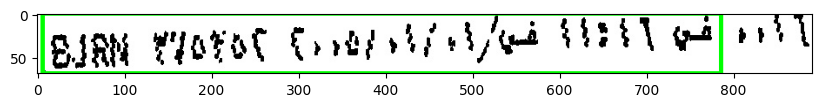

In [24]:
from matplotlib import pyplot as plt

img = cv2.imread('my_model/{}.jpg'.format(image_name))
img = cv2.rectangle(img, top_left, bottom_right,(0,255,0),3)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()